In [49]:
import os
import numpy as np
import pandas as pd
import desispec.io
from desispec.coaddition import coadd_cameras
from astropy.io import fits
import h5py
import random

# Combine QSO + LAE (ELG) to lenses

np.random.seed(123)  # Set seed for NumPy's random generator
random.seed(123)  # Set seed for Python's random module


# Function to extract data from HDF5 files
def extract_data_from_hdf5(file_path):
    with h5py.File(file_path, "r") as hdf5_file:
        classifier = hdf5_file["classifier"][:].astype(str)
        name = hdf5_file["name"][:].astype(str)
        redshift = hdf5_file["redshift"][:]
        intflux = hdf5_file["intflux"][:]
        spectra = hdf5_file["spectrum"][:]
    return classifier, name, redshift, intflux, spectra


# Function to process and modify QSO fluxes
def process_qso_fluxes(fits_directory, hdf5_directory, output_directory, lens_percentage=.1, num_files=None):
    # List all HDF5 files in the directory and sort them by name
    hdf5_files = sorted([f for f in os.listdir(hdf5_directory) if f.endswith(".h5")])

    # Initialize arrays to store data
    all_classifierLAE, all_namesLAE, all_redshiftsLAE, all_intfluxLAE, all_spectraLAE = [], [], [], [], []

    # Iterate over HDF5 files in the directory
    for filename in hdf5_files:
        file_path = os.path.join(hdf5_directory, filename)
        print(f"add LAE spectra {filename}")

        # Extract data from the HDF5 file without filtering
        classifier, name, redshift, intflux, spectra = extract_data_from_hdf5(file_path)

        # Append the data to the respective arrays
        all_classifierLAE.extend(classifier)
        all_namesLAE.extend(name)
        all_redshiftsLAE.extend(redshift)
        all_intfluxLAE.extend(intflux)
        all_spectraLAE.extend(spectra)

    all_classifierLAE, all_namesLAE, all_redshiftsLAE, all_intfluxLAE, all_spectraLAE = np.array(all_classifierLAE), np.array(all_namesLAE), np.array(all_redshiftsLAE), np.array(all_intfluxLAE), np.array(all_spectraLAE)

    print(f"Total LAE entries: {len(all_redshiftsLAE)}")

    # List all QSO FITS files in the directory
    fits_files = sorted([f for f in os.listdir(fits_directory) if f.endswith(".fits")])

    if num_files is not None:
        fits_files = fits_files[:num_files]

    # Initialize arrays to store aggregated QSO data
    all_qso_fluxes = []
    all_targetids_qso = []
    all_redshifts_qso = []
    all_ivar = []
    file_qso_indices = []

    # Iterate over FITS files to aggregate data
    for fits_file in fits_files:
        file_path = os.path.join(fits_directory, fits_file)

        # Read the stacked spectra
        qsos = desispec.io.read_spectra(file_path)

        # Access the extra catalog data
        extra_catalog = qsos.extra_catalog

        # Extract TARGETID and Z arrays
        targetids_qso = extra_catalog['TARGETID']
        redshifts_qso = extra_catalog['Z']

        # Combine camera spectra for QSOs
        qso_fluxes = []
        qso_ivar = []
        for i2 in range(len(qsos)):
            coadd = coadd_cameras(qsos[i2])
            qso_fluxes.append(coadd.flux['brz'][0])
            qso_ivar.append(coadd.ivar['brz'][0])

        # Append data to the aggregated arrays
        all_qso_fluxes.extend(qso_fluxes)
        all_ivar.extend(qso_ivar)
        all_targetids_qso.extend(targetids_qso)
        all_redshifts_qso.extend(redshifts_qso)
        file_qso_indices.append(len(all_qso_fluxes))

    all_qso_fluxes = np.array(all_qso_fluxes)
    all_ivar = np.array(all_ivar)
    all_targetids_qso = np.array(all_targetids_qso)
    all_redshifts_qso = np.array(all_redshifts_qso)

    print(f"Total QSO entries: {len(all_redshifts_qso)}")

    # Initialize a labels array with zeros
    num_qsos = len(all_qso_fluxes)
    labels = np.zeros(num_qsos, dtype=int)
    LAE_redshifts_for_qsos = np.zeros(num_qsos)
    LAE_intflux_for_qsos = np.zeros(num_qsos)
    LAE_names_for_qsos = np.array([""] * num_qsos, dtype=object)

    # Handling 100% lensing when lens_percentage is 1.0
    if lens_percentage == 1.0:
        valid_qso_indices = np.where(all_redshifts_qso <= 3.0)[0]
        print(f"Number of valid QSOs for lensing: {len(valid_qso_indices)}")
    else:
        # Randomly sample a percentage of the QSOs, regardless of redshift
        num_modify = int(lens_percentage * num_qsos)
        valid_qso_indices = random.sample(range(num_qsos), num_modify)

    # List to keep track of successfully modified indices
    modified_indices = []

    print(np.max(valid_qso_indices))
    print(len(valid_qso_indices))

    # Superimpose LAE fluxes onto QSO fluxes based on the redshift condition
    for i in valid_qso_indices:
        #if i >= len(all_redshiftsLAE):
        #    print(f"QSO index {i} exceeds LAE redshift data size, skipping.")
        #    continue

        elg_candidates = np.where(all_redshiftsLAE > all_redshifts_qso[i])[0]
        if elg_candidates.size > 0:
            elg_idx = random.choice(elg_candidates)
            elg_flux = all_spectraLAE[elg_idx]

            # Generate adjusted_factor from a normal distribution
            while True:
                adjusted_factor = np.random.normal(4, 2)
                if adjusted_factor >= 2 and adjusted_factor <= 4:
                    break

            all_qso_fluxes[i] += elg_flux * adjusted_factor*100
            labels[i] = 1  # Set the label to 1 to indicate modification
            LAE_redshifts_for_qsos[i] = all_redshiftsLAE[elg_idx]
            LAE_intflux_for_qsos[i] = all_intfluxLAE[elg_idx]
            LAE_names_for_qsos[i] = all_namesLAE[elg_idx]
            modified_indices.append(i)

    print(f"Number of modified QSOs: {len(modified_indices)}")

    # Output the modified data into separate files based on the original distribution
    start_idx = 0
    for idx, fits_file in enumerate(fits_files):
        end_idx = file_qso_indices[idx]

        # Create a new HDUList object for the modified data
        hdu_list = fits.HDUList()

        # Create a Primary HDU
        primary_hdu = fits.PrimaryHDU()
        hdu_list.append(primary_hdu)

        # Create a BinaryTableHDU for the modified fluxes
        col1 = fits.Column(name='TARGETID', format='K', array=all_targetids_qso[start_idx:end_idx])
        col2 = fits.Column(name='Z', format='D', array=all_redshifts_qso[start_idx:end_idx])
        col3 = fits.Column(name='FLUX', format='QD()', array=all_qso_fluxes[start_idx:end_idx])
        col4 = fits.Column(name='ivar', format='QD()', array=all_ivar[start_idx:end_idx])
        col5 = fits.Column(name='LABEL', format='I', array=labels[start_idx:end_idx])  # Add labels column
        col6 = fits.Column(name='ELG_Z', format='D', array=LAE_redshifts_for_qsos[start_idx:end_idx])  # Add ELG redshift column
        col7 = fits.Column(name='ELG_NAME', format='A40', array=LAE_names_for_qsos[start_idx:end_idx])  # Add ELG name column
        col8 = fits.Column(name='LAE_intflux', format='D', array=LAE_intflux_for_qsos[start_idx:end_idx])  # Add LAE intflux
        cols = fits.ColDefs([col1, col2, col3, col4, col5, col6, col7, col8])
        hdu = fits.BinTableHDU.from_columns(cols)

        hdu_list.append(hdu)

        # Write to a new FITS file
        output_file_path = os.path.join(output_directory, f"modified_minsignal1_{fits_file}")
        hdu_list.writeto(output_file_path, overwrite=True)

        start_idx = end_idx

    # Output the results
    print("Original QSO fluxes shape:", all_qso_fluxes.shape)
    print("Labels array shape:", labels.shape)
    print("Number of modified fluxes:", np.sum(labels))

    # Ensure the changes are reflected in a new array for further analysis
    resulting_fluxes = all_qso_fluxes


# Example usage
fits_directory = os.path.expandvars('$SCRATCH/MainQSO/A')
hdf5_directory = os.path.expandvars('$SCRATCH/augLAE_minsignal1_hdf5')
output_directory = os.path.expandvars('$SCRATCH/modifiedMainQSO_minsignal1/B')
# I directly indicate what percentage of the files I want to be lensed and select the number of files
# i want to use from the MainQSO directory (whereever the QSO files are located
process_qso_fluxes(fits_directory, hdf5_directory, output_directory, lens_percentage=.1, num_files=1)


add LAE spectra SPHINX_augLAE_minsignal1_batch0.h5
add LAE spectra SPHINX_augLAE_minsignal1_batch1.h5
add LAE spectra SPHINX_augLAE_minsignal1_batch2.h5
add LAE spectra SPHINX_augLAE_minsignal1_batch3.h5
add LAE spectra SPHINX_augLAE_minsignal1_batch4.h5
add LAE spectra ZoomSim_augLAE_minsignal1_batch0.h5
add LAE spectra ZoomSim_augLAE_minsignal1_batch1.h5
add LAE spectra ZoomSim_augLAE_minsignal1_batch2.h5
add LAE spectra ZoomSim_augLAE_minsignal1_batch3.h5
add LAE spectra ZoomSim_augLAE_minsignal1_batch4.h5
Total LAE entries: 205835
INFO:spectra.py:451:read_spectra: iotime 12.032 sec to read spectra from:  desi_bright_qso_batch1.fits at 2025-04-22T13:09:04.694074
Total QSO entries: 12295
12290
1229
Number of modified QSOs: 1229
Original QSO fluxes shape: (12295, 7781)
Labels array shape: (12295,)
Number of modified fluxes: 1229


------------------------------------------------------------------------------------------

# Lets try to open a file

In [22]:
import os
import numpy as np
import pandas as pd
import desispec.io
from desispec.coaddition import coadd_cameras
from astropy.io import fits
import h5py
import random
import matplotlib.pyplot as plt

In [54]:

# Define the path to the FITS file you want to open
fits_file_path = os.path.join(os.path.expandvars('$SCRATCH/'), 
                              'modifiedMainQSO_minsignal1/A/modified_minsignal1_desi_bright_qso_batch1.fits')

# Open the FITS file
with fits.open(fits_file_path) as hdul:
    # Print the HDU (Header/Data Unit) list
    hdul.info()
    
    # Access the primary HDU
    primary_hdu = hdul[0]
    print("Primary HDU Header:")
    print(primary_hdu.header)
    
    # Access the binary table HDU
    binary_table_hdu = hdul[1]
    data = binary_table_hdu.data

    # Print the column names
    print("\nColumn names in the binary table HDU:")
    print(data.columns.names)
    
    # Access data from columns
    target_ids = data['TARGETID']
    redshifts = data['Z']
    fluxes = data['FLUX']
    labels = data['LABEL']
    elg_redshift = data['ELG_Z']
    lae_intflux = data['LAE_intflux']
    ename = data['ELG_NAME']
    ivar = data['ivar']

    print()
    print(len(labels))
    print(np.sum(labels))
    print(np.sum(labels)/len(labels))

    # Print some example data
    print("\nExample data:")
    print("TARGETID:", target_ids[:20])
    print("Redshifts:", redshifts[:20])
    print("Fluxes:", fluxes[:20])
    print("Labels:", labels[:20])
    print("LAE Redshift:", elg_redshift[:20])
    print("LAE_intflux:", lae_intflux[:20])
    print("LAE name:", ename[:20])

# Output some information about the data
print("\nNumber of entries:", len(data))
print(np.sum(labels))

Filename: /pscratch/sd/j/jspiller/modifiedMainQSO_minsignal1/A/modified_minsignal1_desi_bright_qso_batch1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     24   12295R x 8C   [K, D, QD(7781), QD(7781), I, D, 40A, D]   
Primary HDU Header:
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                             

In [55]:
i = 15
print("\nExample data:")
print("TARGETID:", target_ids[i])
print("Redshift:", redshifts[i])
print("Fluxes:", fluxes[i])
print("ivar", ivar[i])
print("Labels:", labels[i])
print("LAE Redshift:", elg_redshift[i])
print("LAE NAME", ename[i])
print("LAE intflux", lae_intflux[i])

#np.where(redshifts[elg_fluxes>0]>elg_fluxes[elg_fluxes>0])


Example data:
TARGETID: 39627791519453248
Redshift: 0.8071953302596596
Fluxes: [6.96885252 0.3865574  6.00543261 ... 0.80266595 0.76999104 0.83527732]
ivar [ 0.18919371  0.22163348  0.19649509 ... 35.27795792 50.09638214
 70.98058319]
Labels: 0
LAE Redshift: 0.0
LAE NAME 
LAE intflux 0.0



Example data:
TARGETID: 39627785479657905
Redshift: 2.2720482677597102
Fluxes: [ 2.92757392  1.33180869 -2.13434601 ...  0.14275423  0.59149265
  0.16131462]
ivar [  0.23747601   0.27311665   0.23198228 ...  56.70696259  82.48036194
 116.1554718 ]
Labels: 1
LAE Redshift: 4.24861907052714
LAE NAME SPHINX_z6_haloid374152_dir_0
LAE intflux 1.6710059570063547



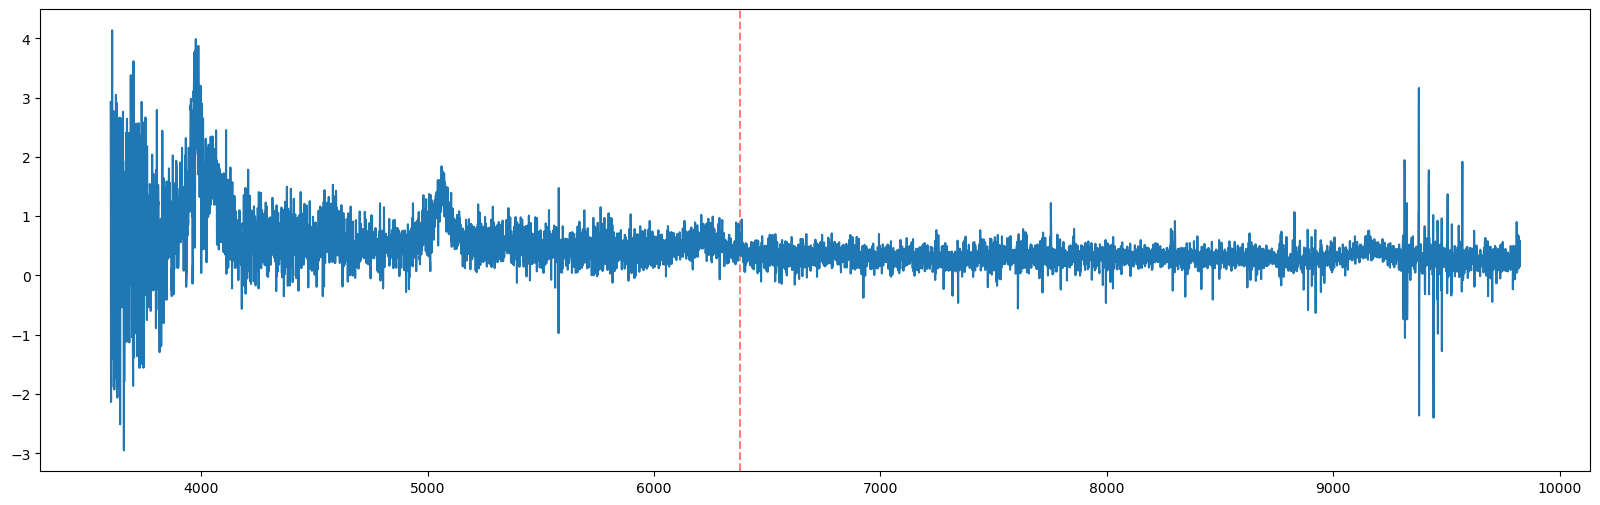


Example data:
TARGETID: 39627791519451554
Redshift: 2.424253189588172
Fluxes: [1.62336361 2.25327134 1.71481788 ... 0.87713361 0.6197592  0.56122124]
ivar [ 0.34239745  0.38021794  0.3482517  ... 50.69142151 69.64778137
 99.91153717]
Labels: 1
LAE Redshift: 5.287545511338595
LAE NAME SPHINX_z4_haloid375162_dir_0
LAE intflux 1.0501006845682674



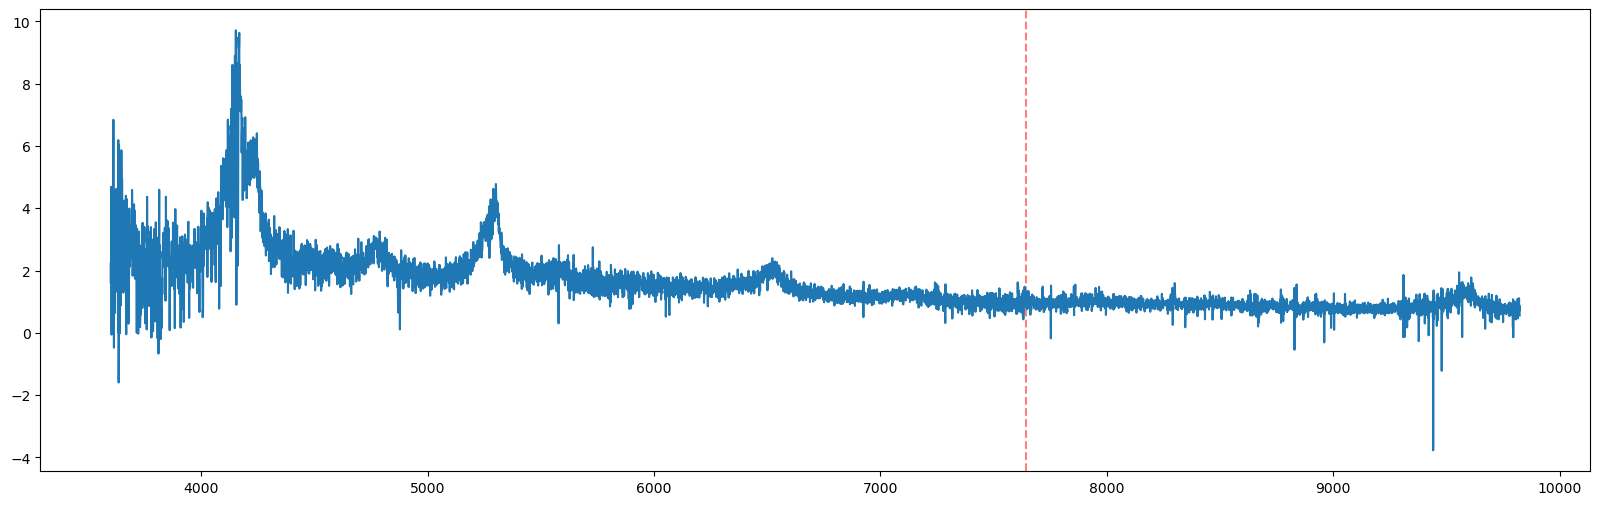


Example data:
TARGETID: 39627791523645551
Redshift: 2.2253433958106337
Fluxes: [2.24688864 1.09208059 5.44843292 ... 0.4621681  0.71402401 0.6290831 ]
ivar [ 0.11714567  0.15760887  0.11364912 ... 42.79365921 60.86875916
 71.73603821]
Labels: 1
LAE Redshift: 5.42022280776538
LAE NAME SPHINX_z4_haloid231666_dir_0
LAE intflux 2.999012920653055



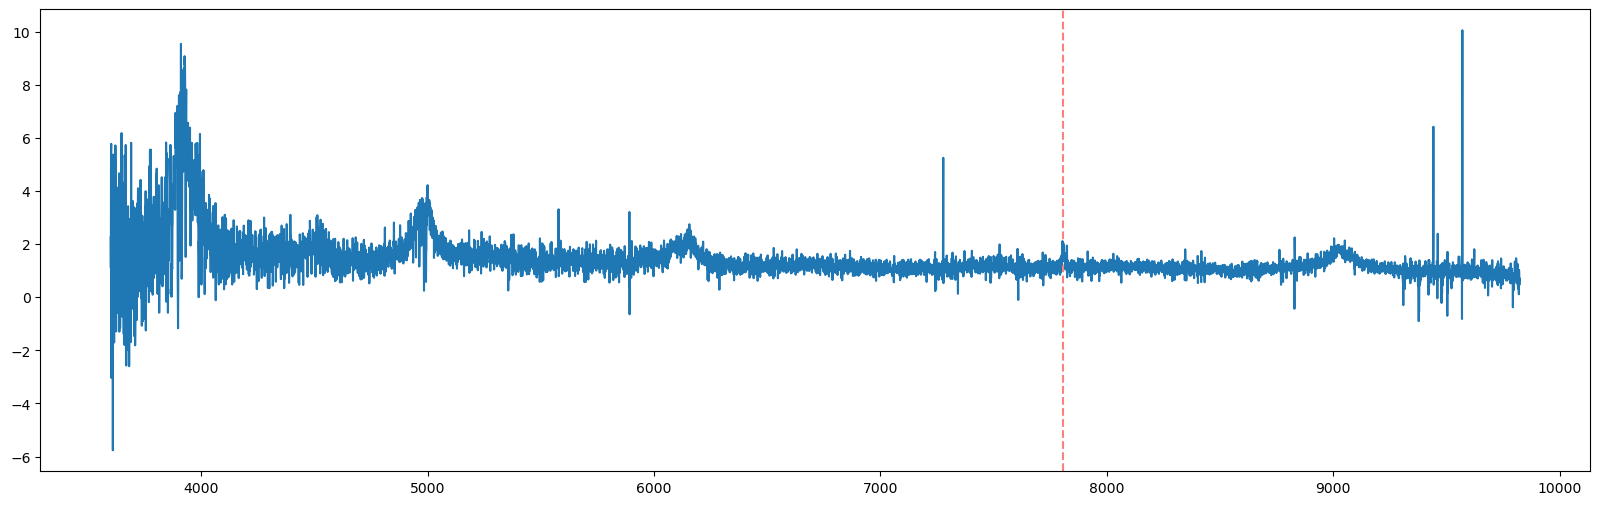


Example data:
TARGETID: 39627791527837903
Redshift: 1.7556950719047177
Fluxes: [3.83236861 3.58639002 1.49007118 ... 1.30822241 0.17368501 0.17234288]
ivar [ 0.14074662  0.11956325  0.11121073 ... 14.79483795 18.36615562
 21.60545731]
Labels: 1
LAE Redshift: 5.435440587566471
LAE NAME SPHINX_z6_haloid998_dir_3
LAE intflux 1.9316645542805013



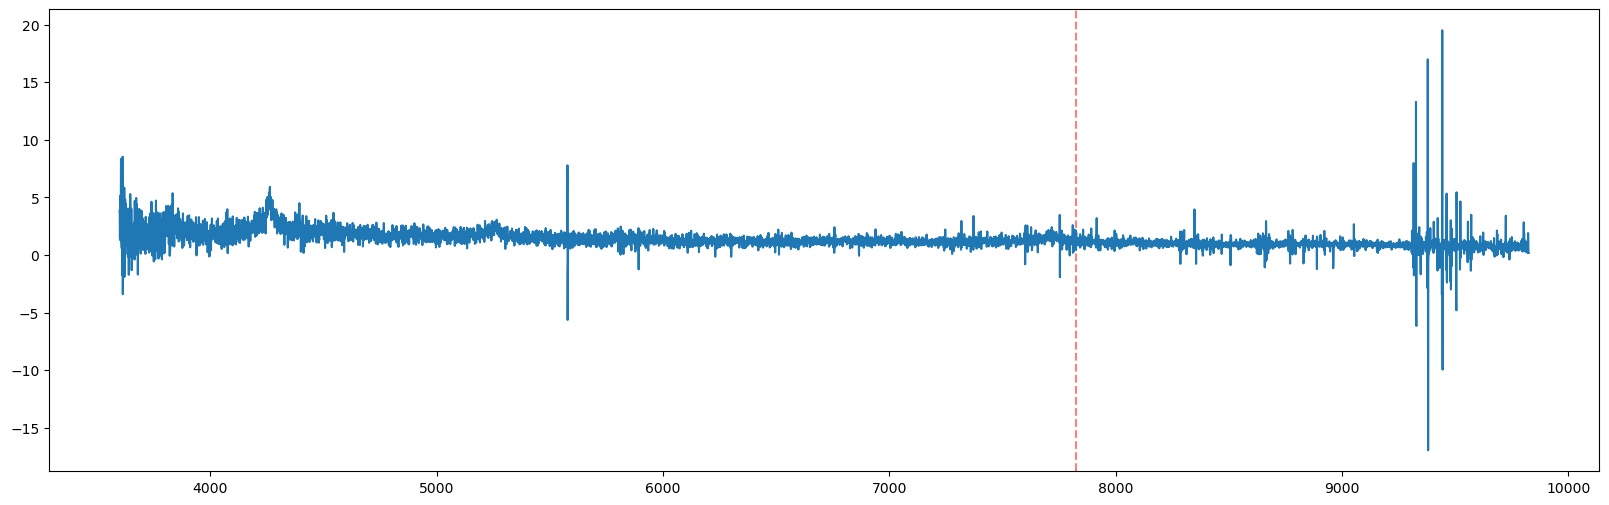


Example data:
TARGETID: 39627797555053654
Redshift: 0.6627734049148777
Fluxes: [10.78589058  2.77652454  3.09023857 ...  2.13384485  2.68721843
  1.92417395]
ivar [ 0.10460521  0.10417196  0.09783319 ...  9.71827412 12.08632946
 14.00525665]
Labels: 1
LAE Redshift: 5.8894296788595835
LAE NAME SPHINX_z5_haloid75598_dir_7
LAE intflux 2.5684084721385796



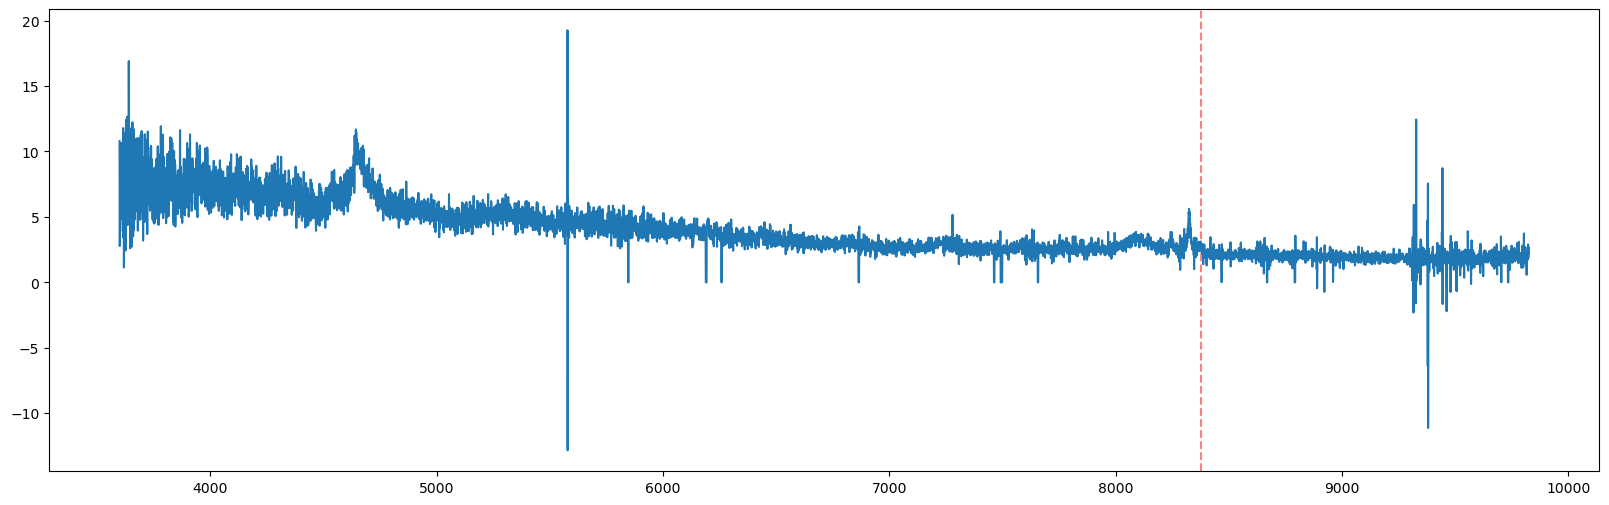


Example data:
TARGETID: 39627797555054647
Redshift: 2.440285759389295
Fluxes: [-2.9629581   1.46447682 -0.5903964  ...  0.04897699  0.05002328
  0.35101497]
ivar [  0.73043853   0.68597895   0.72610921 ...  61.38679123 106.52305603
 155.74316406]
Labels: 1
LAE Redshift: 3.524003348771085
LAE NAME ZoomSim_timestep103_direction85
LAE intflux 1.195035460262792



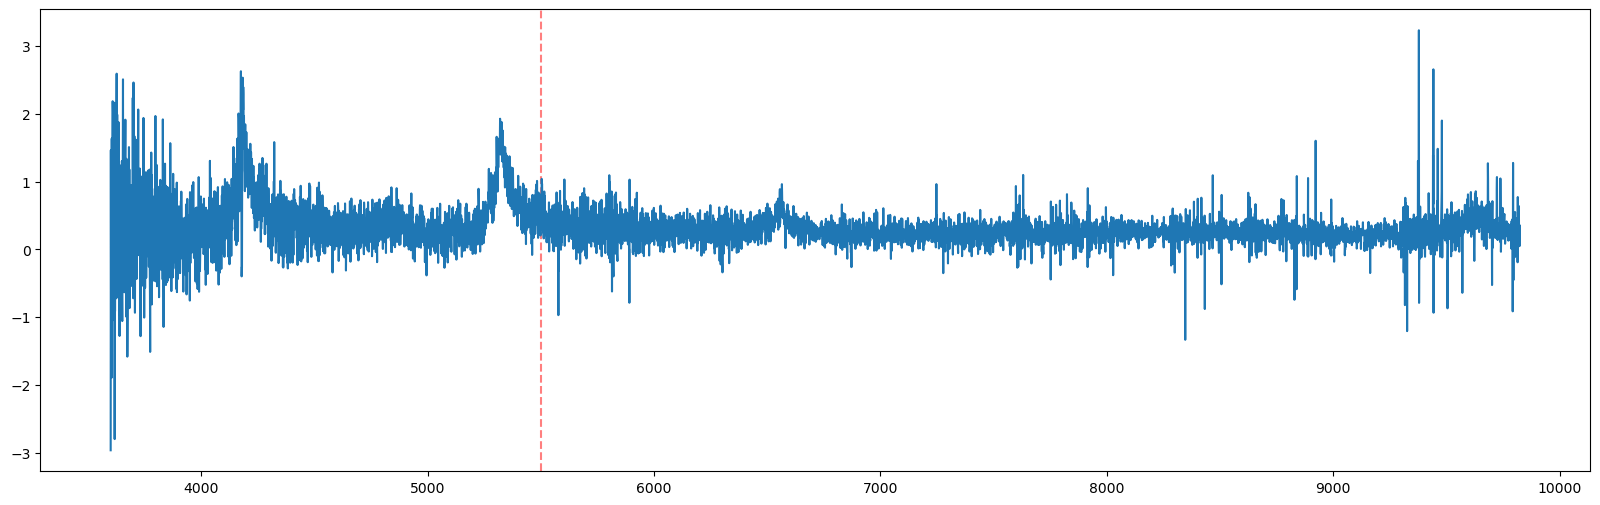


Example data:
TARGETID: 39627797559248203
Redshift: 1.669795571055015
Fluxes: [ 0.59946442 -1.71379793 -0.6259948  ...  0.45574296  0.4897351
 -0.16578493]
ivar [9.16956365e-02 1.74676448e-01 1.74594596e-01 ... 4.44523048e+01
 8.83020020e+01 1.36101288e+02]
Labels: 1
LAE Redshift: 2.9705612681293063
LAE NAME ZoomSim_timestep131_direction113
LAE intflux 1.3555151884808787



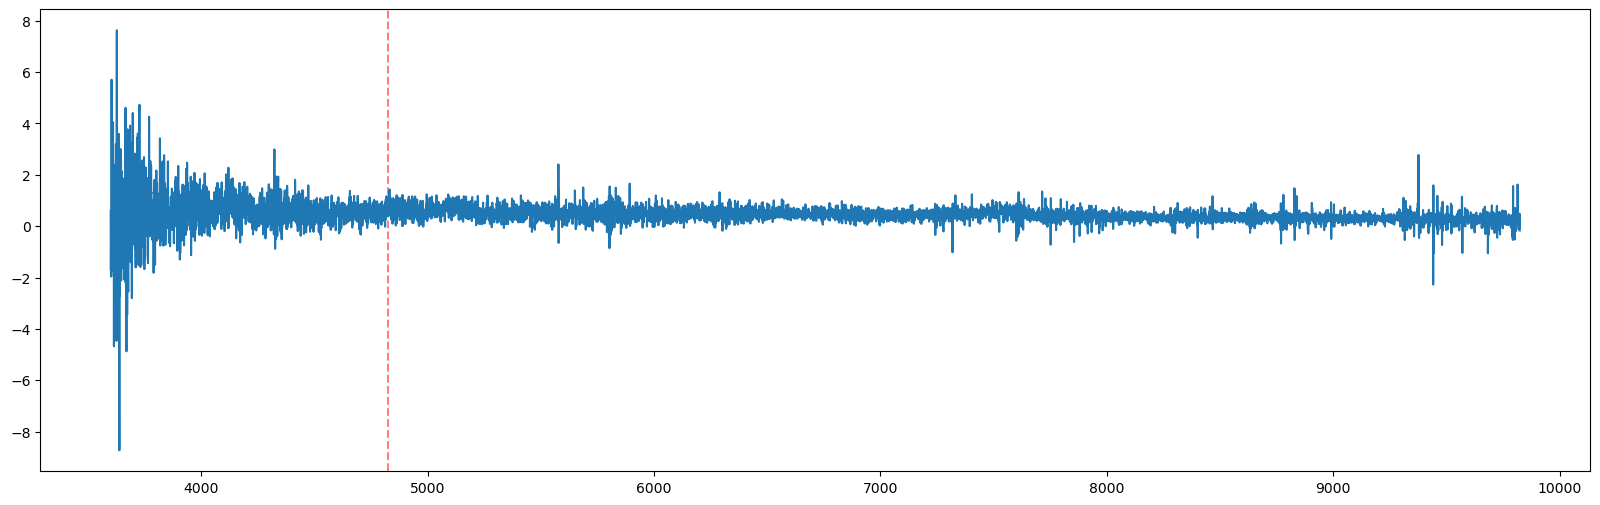


Example data:
TARGETID: 39627797563443523
Redshift: 1.910885998543885
Fluxes: [-0.21402653 -3.39907217  0.8692773  ... -0.01479959 -0.07407226
  0.31597885]
ivar [ 0.12113632  0.13391656  0.13649464 ... 13.89771175 20.01966095
 24.75171089]
Labels: 1
LAE Redshift: 4.722889484567277
LAE NAME SPHINX_z6_haloid44576_dir_7
LAE intflux 1.8396039365109926



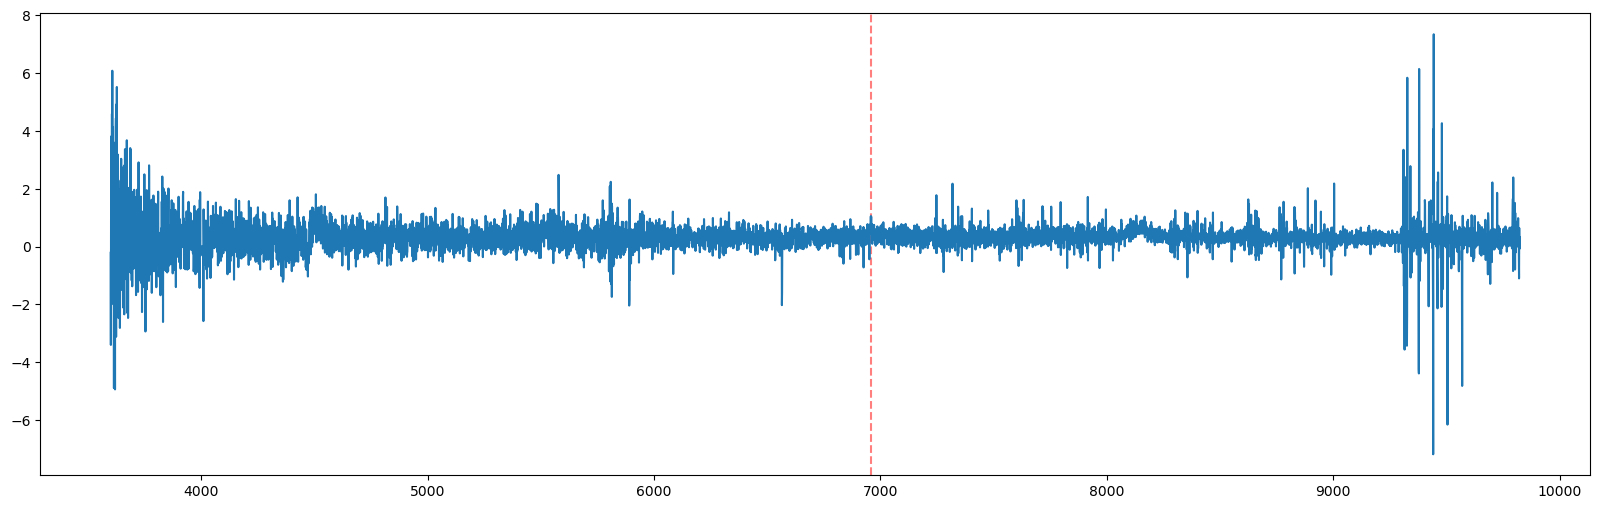


Example data:
TARGETID: 39627797563444053
Redshift: 2.7832458898823735
Fluxes: [  5.71635628   8.52505684 -10.24416924 ...  -0.07044277   0.24316408
   0.35174596]
ivar [2.38776114e-02 3.58005762e-02 3.49589325e-02 ... 2.80715065e+01
 4.94733276e+01 6.51653290e+01]
Labels: 1
LAE Redshift: 4.416617727104313
LAE NAME SPHINX_z4_haloid371640_dir_0
LAE intflux 2.134325072049714



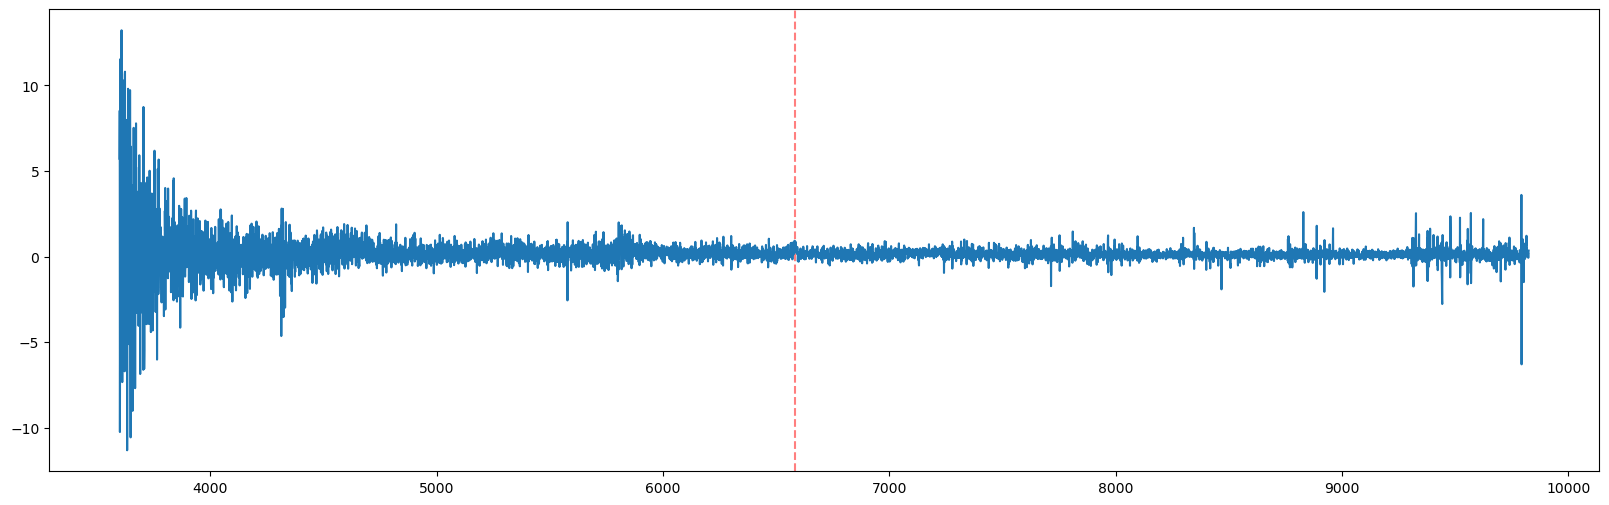


Example data:
TARGETID: 39627797563445905
Redshift: 1.7315894766979352
Fluxes: [ 6.46036148 12.9536829  10.75959778 ...  2.01460028  1.29789209
  1.81812572]
ivar [ 0.11409122  0.09868716  0.08732635 ... 11.89989376 15.81864929
 18.36301422]
Labels: 1
LAE Redshift: 3.9337154053836834
LAE NAME ZoomSim_timestep159_direction92
LAE intflux 3.0579618644964968



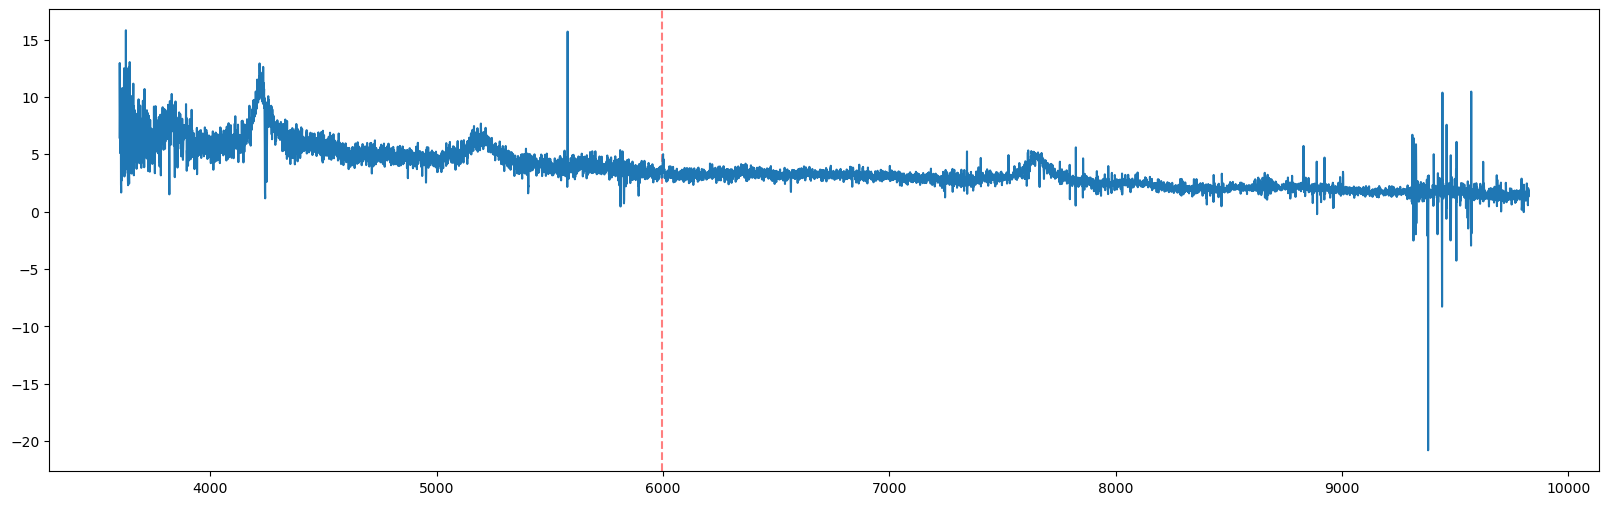


Example data:
TARGETID: 39627797563447018
Redshift: 2.3942786148646604
Fluxes: [11.10700703  7.10396671  5.44521713 ...  2.30022693  2.33003426
  2.16178823]
ivar [ 0.30468836  0.33447069  0.33619231 ... 52.50706482 62.01354599
 66.41043854]
Labels: 1
LAE Redshift: 4.940906101756361
LAE NAME SPHINX_z4_haloid382381_dir_4
LAE intflux 3.4065059120673



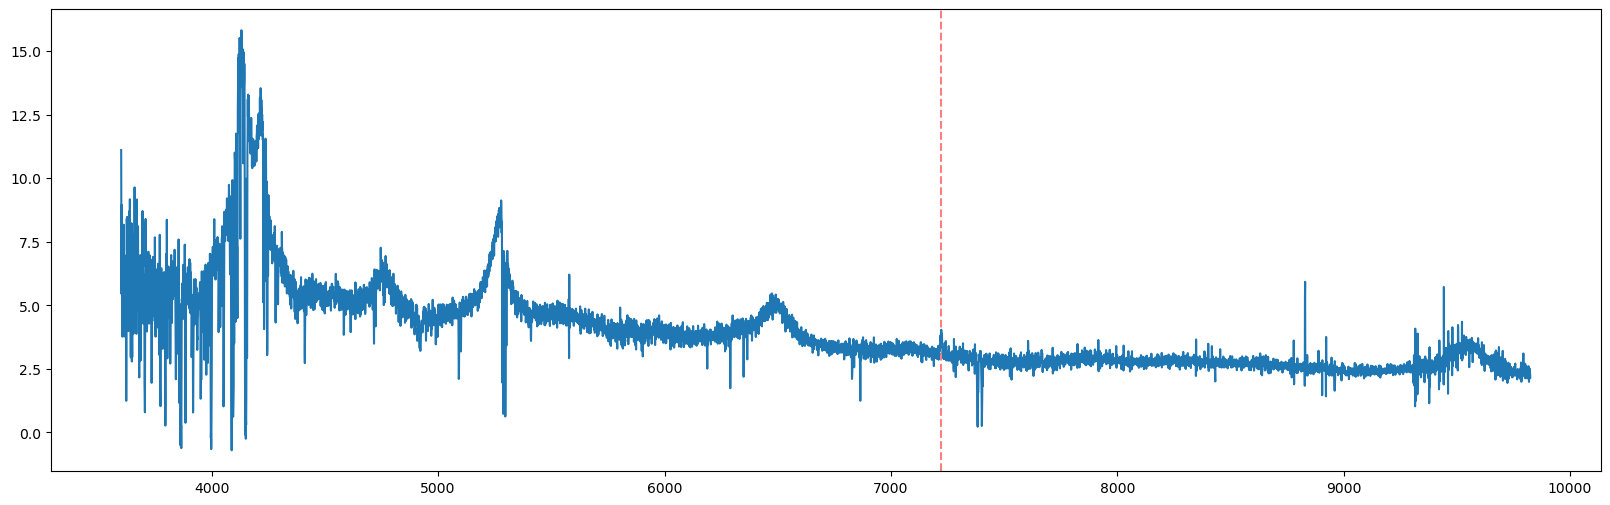


Example data:
TARGETID: 39627797571830402
Redshift: 0.47557447453536483
Fluxes: [-3.24605536  0.03596781 -1.79334712 ...  2.06637645  3.38073897
  1.98382127]
ivar [ 0.09520149  0.07015714  0.07831889 ... 13.96947575 12.49296093
 17.24605942]
Labels: 1
LAE Redshift: 3.0494635651114486
LAE NAME ZoomSim_timestep127_direction73
LAE intflux 2.715141480518547



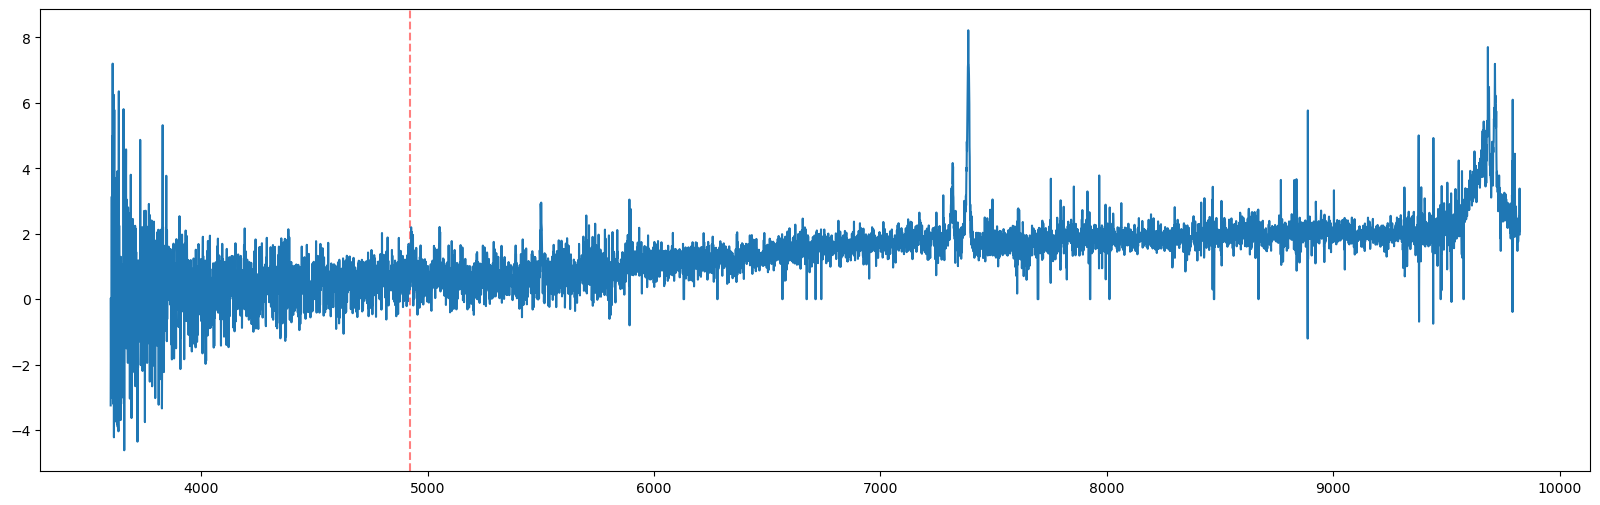


Example data:
TARGETID: 39627803594855891
Redshift: 3.455605202908148
Fluxes: [ 0.40408766  2.51738548  2.77730131 ...  0.01078495 -0.20998619
  0.1769757 ]
ivar [ 0.24019626  0.20958827  0.21690339 ... 13.55576992 19.98399734
 29.40764046]
Labels: 1
LAE Redshift: 4.762597950966038
LAE NAME SPHINX_z5_haloid209595_dir_3
LAE intflux 5.12621174982437



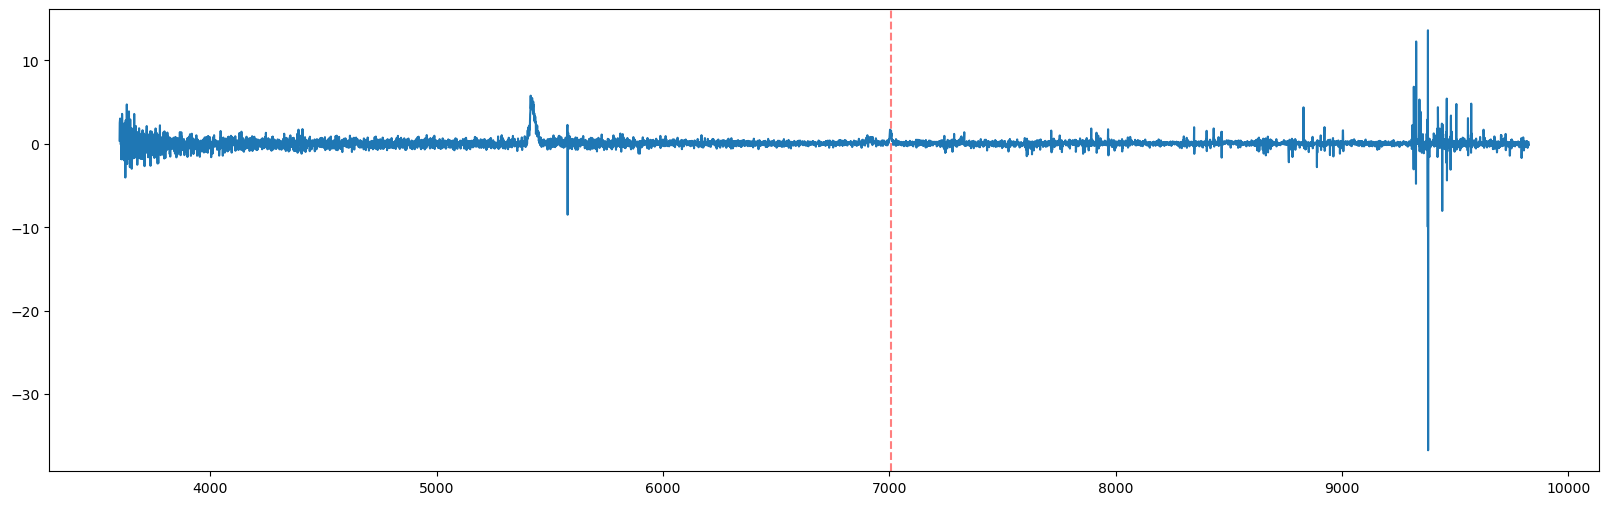


Example data:
TARGETID: 39627803594858063
Redshift: 1.316441755364365
Fluxes: [10.47695446 10.25797462 12.54648209 ...  0.88980901  0.4884032
  1.27901316]
ivar [ 0.19748966  0.17104495  0.16573124 ... 11.56600094 16.03403664
 20.6664772 ]
Labels: 1
LAE Redshift: 2.222422993594993
LAE NAME ZoomSim_timestep107_direction259
LAE intflux 1.5095851817551709



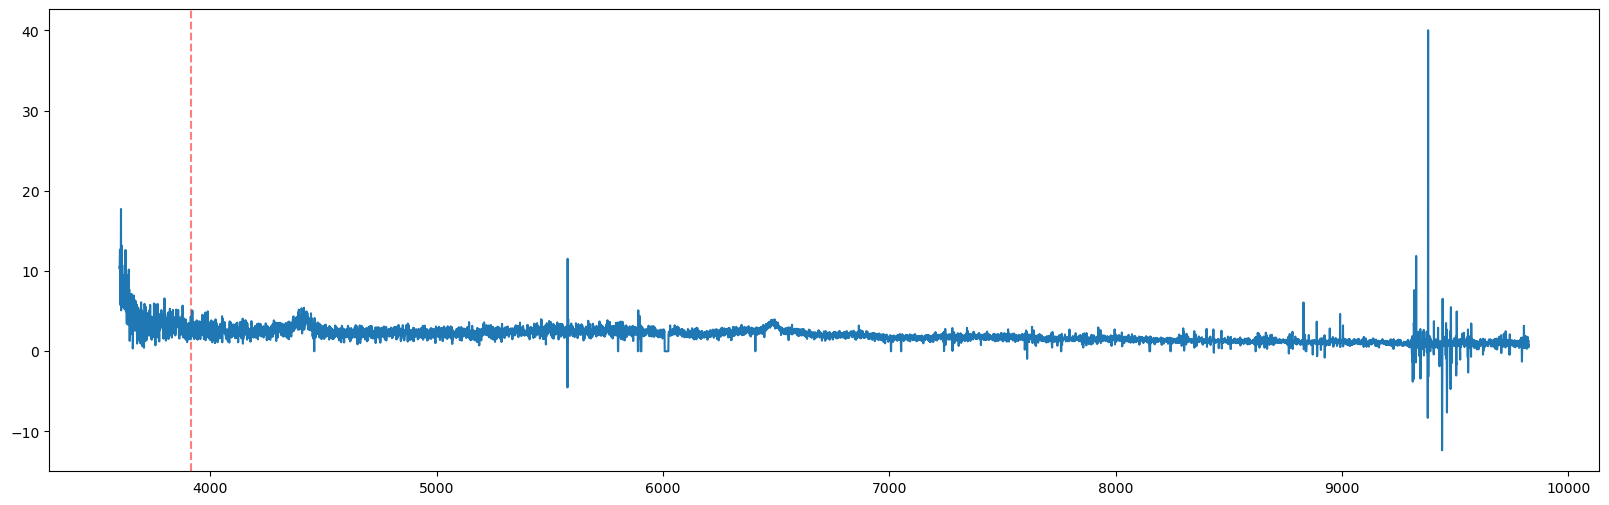


Example data:
TARGETID: 39627803599051141
Redshift: 2.4826062952083725
Fluxes: [ 0.33585453  0.11447369  0.22234078 ... -0.05003219  0.27399507
  0.07592456]
ivar [  0.57109731   0.59491998   0.60067809 ...  78.23766327 120.57592773
 185.32884216]
Labels: 1
LAE Redshift: 5.755136455367981
LAE NAME SPHINX_z6_haloid9630_dir_1
LAE intflux 1.311039545781263



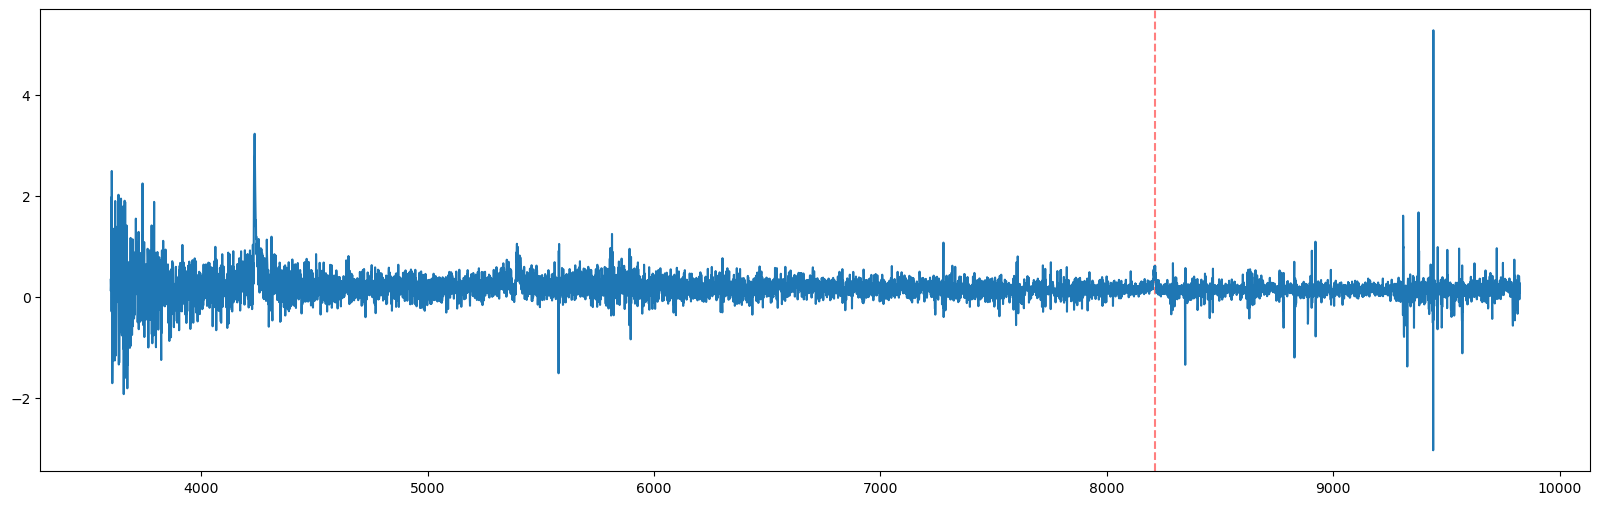


Example data:
TARGETID: 39627803603239338
Redshift: 0.9868380887204151
Fluxes: [5.40256262 3.26853204 8.10112095 ... 0.75063467 1.39706981 0.90453887]
ivar [ 0.17361233  0.21514016  0.20676534 ... 13.21021652 16.82844734
 25.50572777]
Labels: 1
LAE Redshift: 5.281901668288092
LAE NAME SPHINX_z4_haloid214722_dir_3
LAE intflux 2.00351262899929



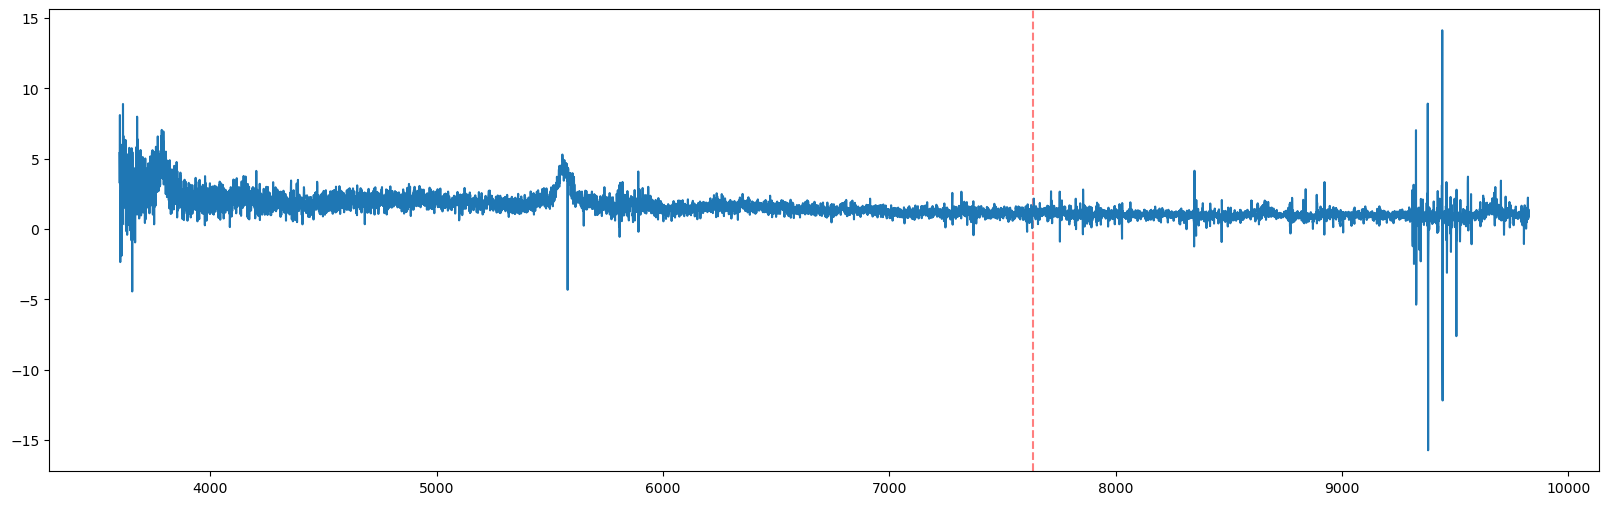


Example data:
TARGETID: 39627803603244063
Redshift: 3.6175650613181602
Fluxes: [-1.39429903  1.23267162  0.74362957 ...  1.07839012  0.94665003
  0.76580685]
ivar [ 0.54543048  0.54837877  0.54712546 ... 56.35974884 67.72743225
 95.60357666]
Labels: 1
LAE Redshift: 4.008969072305535
LAE NAME ZoomSim_timestep146_direction156
LAE intflux 1.1281381997137219



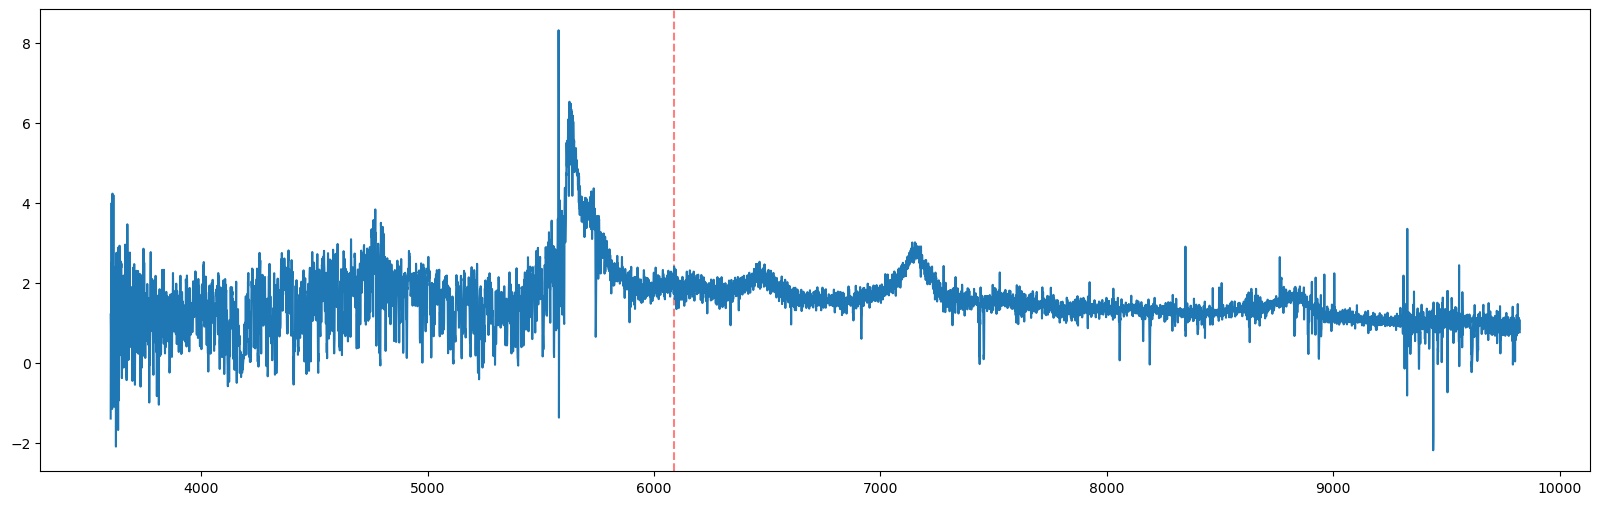


Example data:
TARGETID: 39627803603244682
Redshift: 1.4414459527822865
Fluxes: [0.54496694 0.83551741 2.78284669 ... 0.83539081 0.47117138 1.0007112 ]
ivar [ 0.27673468  0.21055111  0.22219795 ... 18.11182404 22.42534256
 26.63709068]
Labels: 1
LAE Redshift: 4.952055493546458
LAE NAME SPHINX_z6_haloid241352_dir_9
LAE intflux 2.0436625466574023



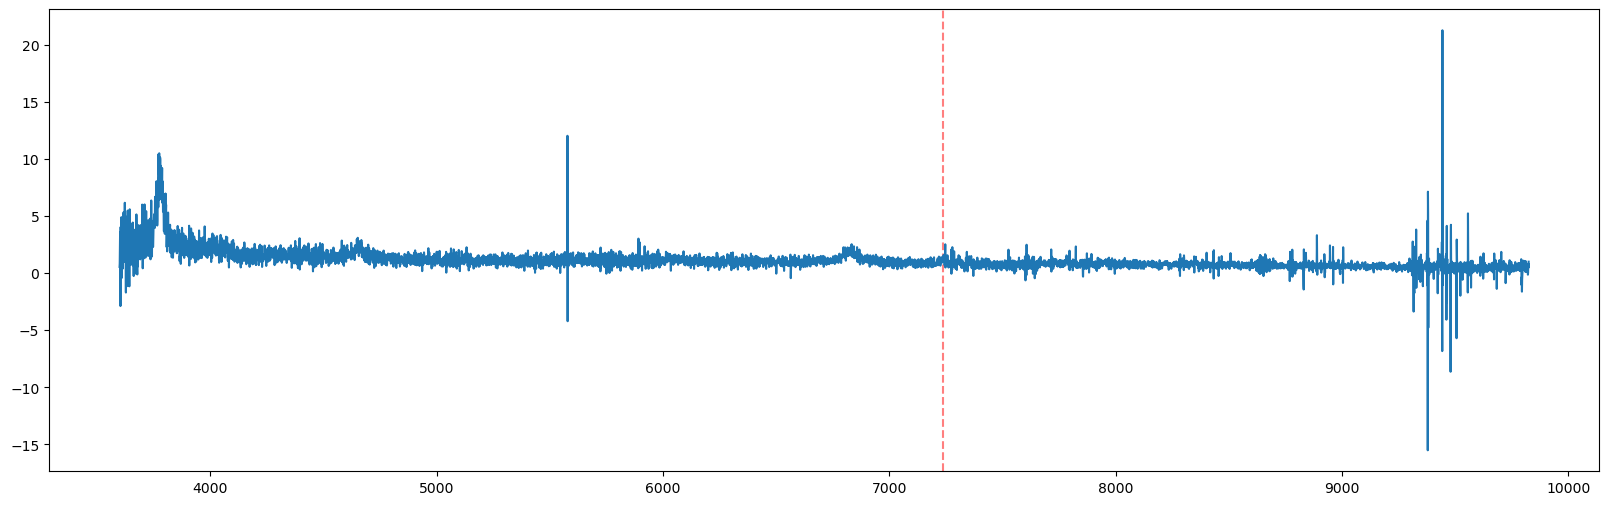


Example data:
TARGETID: 39627803607438808
Redshift: 1.7867759668469592
Fluxes: [-0.06638882  2.08390403 -1.19913077 ...  0.07841748 -0.05490659
  0.31480652]
ivar [ 0.11399476  0.11655317  0.07955576 ... 19.34537697 24.51758957
 29.54369545]
Labels: 1
LAE Redshift: 4.725984368688535
LAE NAME SPHINX_z6_haloid379664_dir_0
LAE intflux 1.1909420346257522



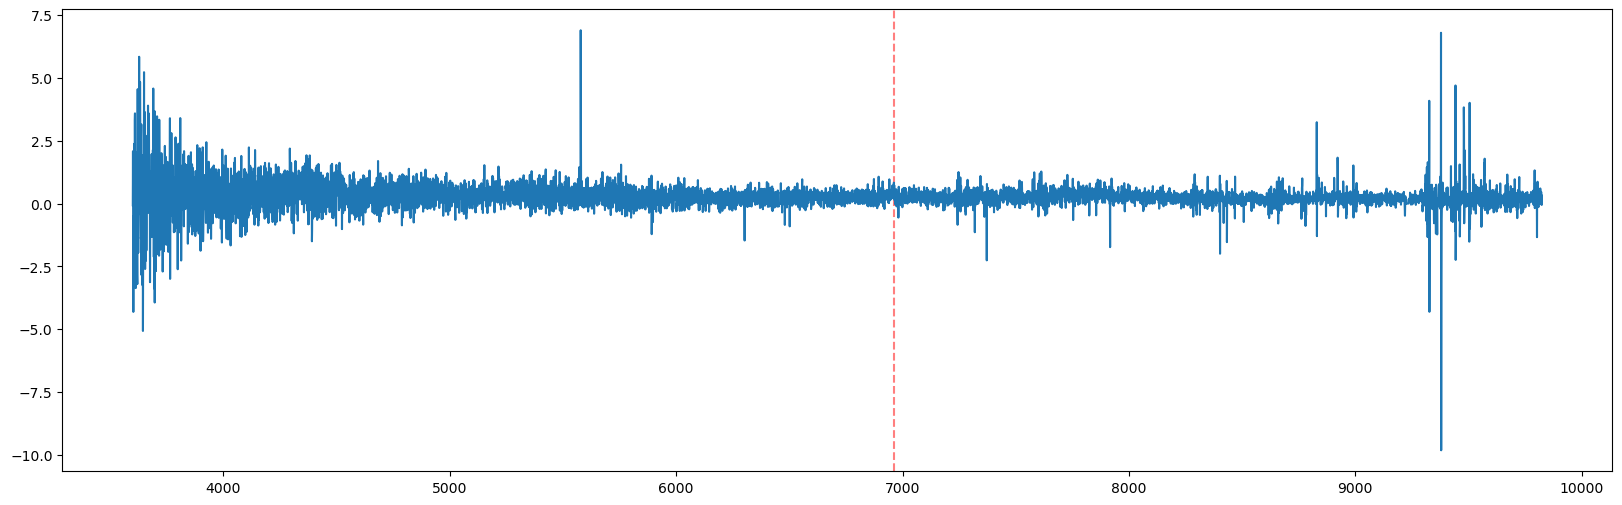


Example data:
TARGETID: 39627803615826875
Redshift: 1.9743654276731197
Fluxes: [-1.85286248  0.54963368  3.18244338 ...  0.48374745  0.39304447
  1.16167283]
ivar [ 0.11614018  0.08824274  0.099493   ... 17.4348793  25.24120331
 25.94279099]
Labels: 1
LAE Redshift: 2.8692896133061345
LAE NAME ZoomSim_timestep125_direction40
LAE intflux 2.9067773468635747



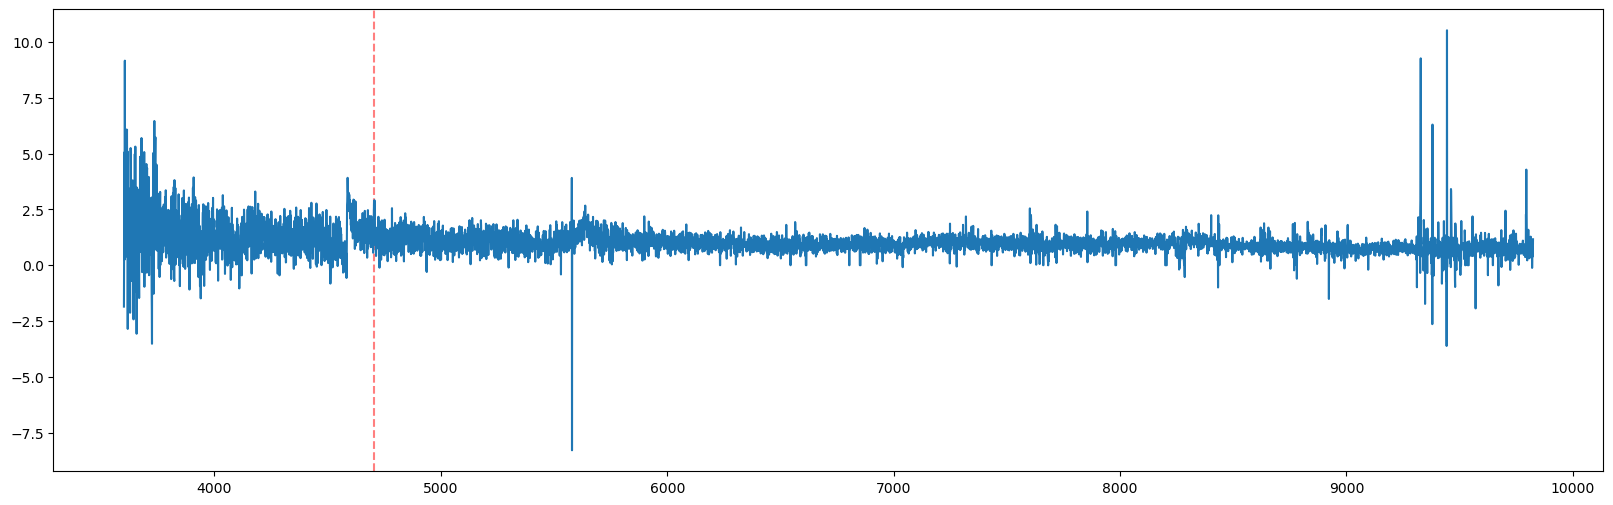


Example data:
TARGETID: 39627809622070725
Redshift: 3.121261329010193
Fluxes: [-2.69866014 -0.19097358  1.14818418 ...  0.37496328 -0.09037578
  0.37826189]
ivar [ 0.19283018  0.19940232  0.1983586  ... 28.18932915 38.49230957
 45.8459549 ]
Labels: 1
LAE Redshift: 3.405227573136165
LAE NAME ZoomSim_timestep147_direction266
LAE intflux 1.742403511959493



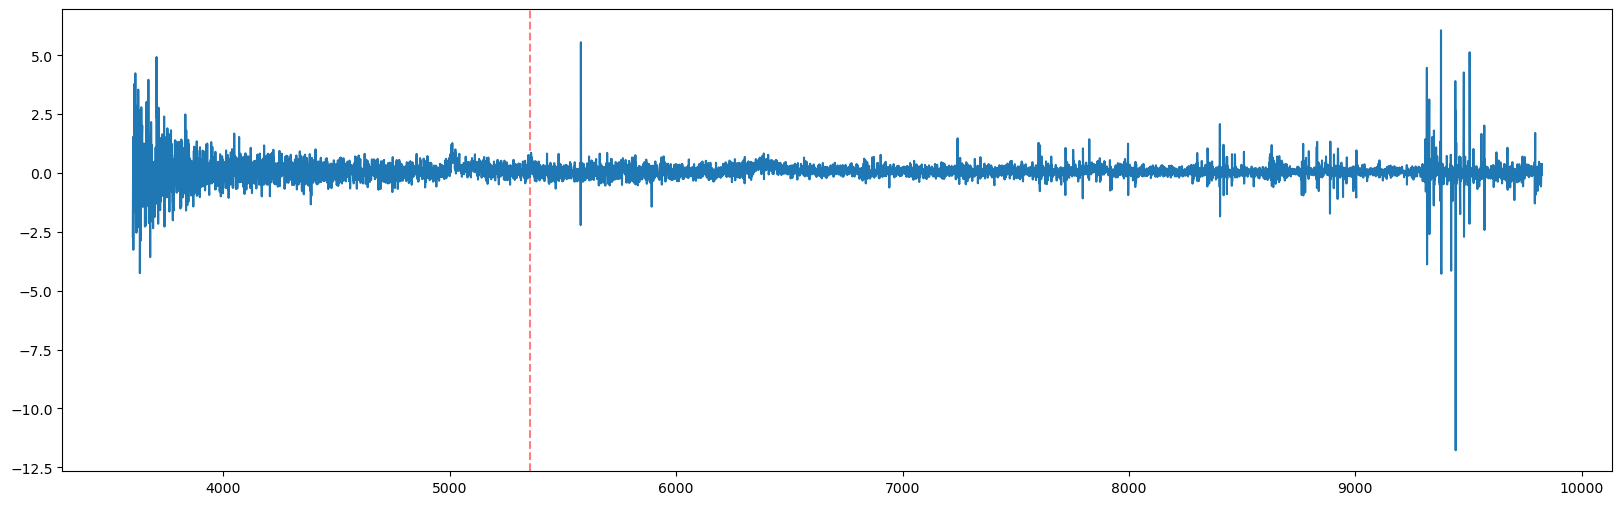


Example data:
TARGETID: 39627809622071005
Redshift: 2.3036770095129357
Fluxes: [-3.24469471  2.45040011  4.3990593  ...  0.34521407  0.6185981
  0.18563537]
ivar [ 0.11770546  0.12320095  0.12446477 ... 13.84444427 18.18253326
 22.62537003]
Labels: 1
LAE Redshift: 4.652215994943058
LAE NAME SPHINX_z6_haloid33641_dir_8
LAE intflux 1.8150729936118835



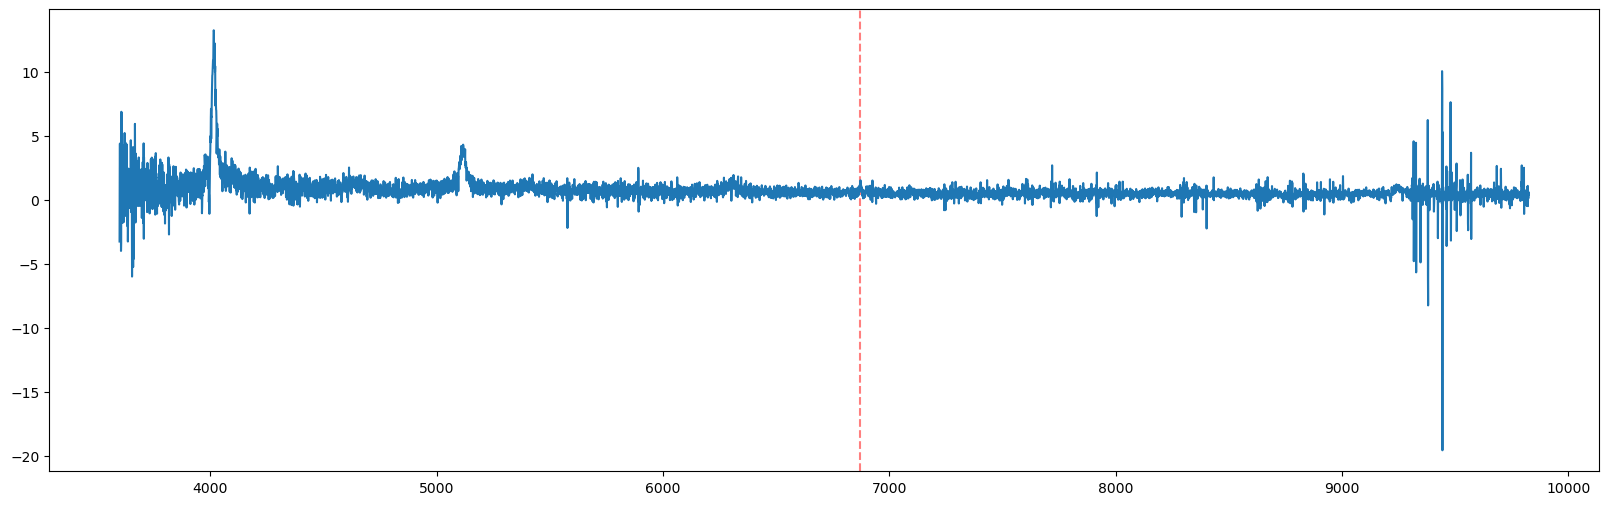


Example data:
TARGETID: 39627809630454089
Redshift: 2.200024112159155
Fluxes: [5.62706041 3.25319886 1.63318634 ... 0.91210687 0.73188704 0.89682972]
ivar [ 0.42516801  0.3205612   0.33920294 ... 45.84553909 64.99063873
 94.522995  ]
Labels: 1
LAE Redshift: 2.4549421519728765
LAE NAME ZoomSim_timestep149_direction186
LAE intflux 1.140060763376866



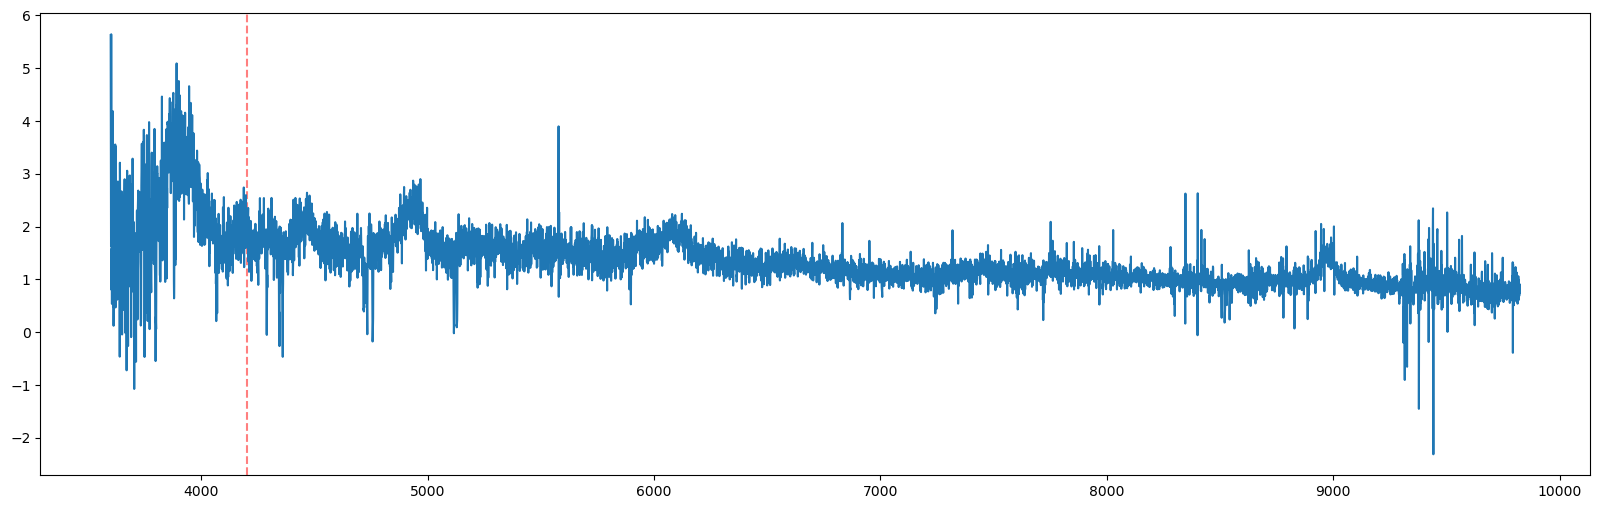


Example data:
TARGETID: 39627809630457611
Redshift: 2.1113455736488254
Fluxes: [0.6131115  0.4547213  2.68383455 ... 0.18854387 0.20470826 0.65498304]
ivar [ 0.35600951  0.35937482  0.35686594 ... 48.6460228  66.14372253
 82.68571472]
Labels: 1
LAE Redshift: 4.183041546029497
LAE NAME ZoomSim_timestep137_direction24
LAE intflux 3.6237692661491696



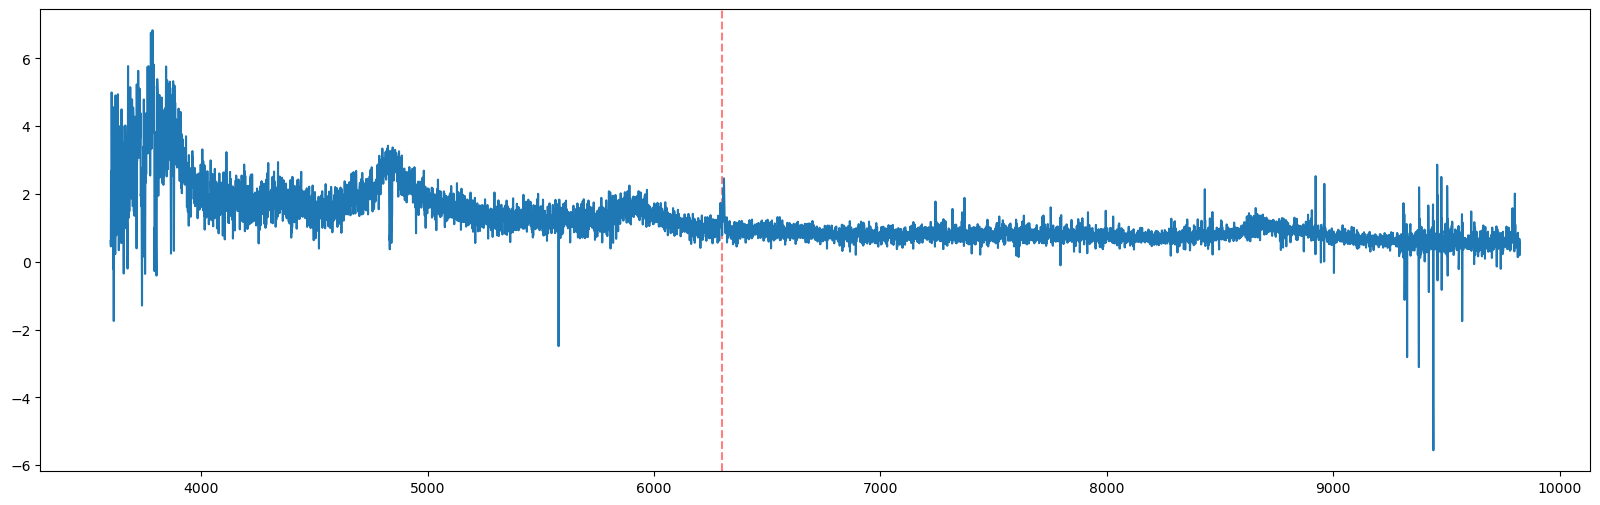


Example data:
TARGETID: 39627809630459592
Redshift: 1.625275269471693
Fluxes: [ 0.09889565  3.41660833 -0.17309606 ...  0.52877134  0.31705302
  0.85092276]
ivar [ 0.20427179  0.17592601  0.17426105 ... 12.82189655 17.67680168
 20.4519577 ]
Labels: 1
LAE Redshift: 4.973601951514575
LAE NAME SPHINX_z4_haloid205898_dir_4
LAE intflux 1.0650665081253055



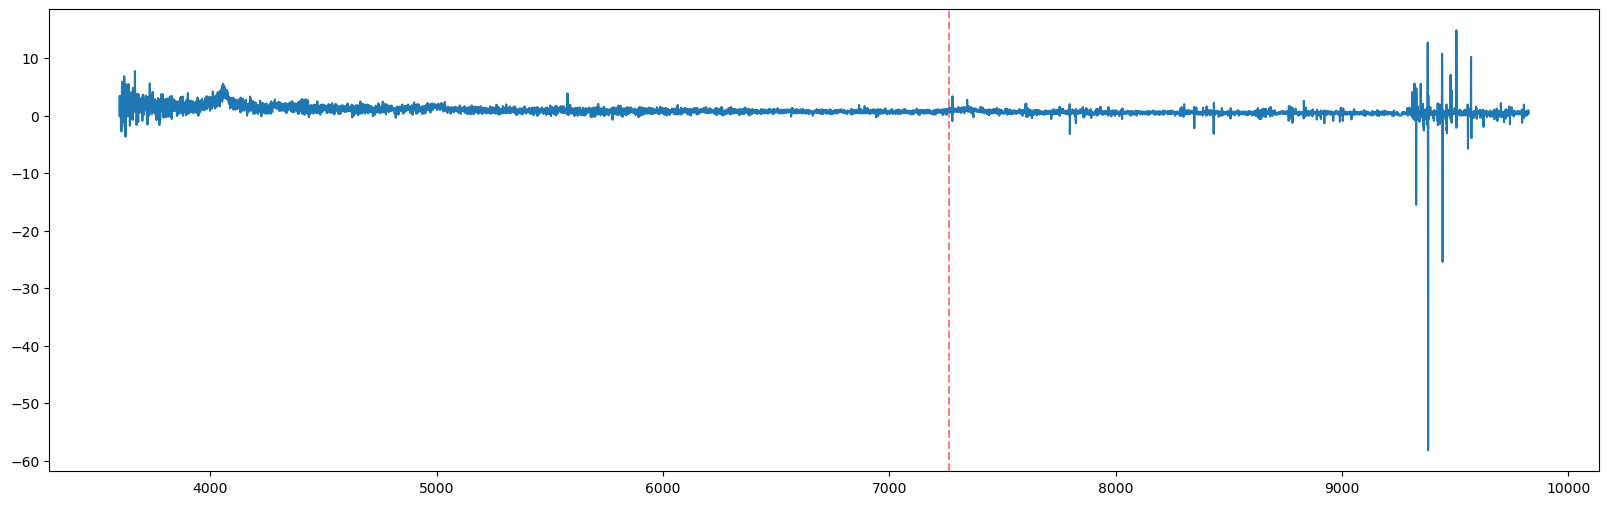


Example data:
TARGETID: 39627809638849263
Redshift: 1.2659158854610817
Fluxes: [-0.55001485  0.76918334 -1.66206574 ... -0.40387332 -0.24570164
  0.22942358]
ivar [ 0.07947749  0.07590646  0.08511493 ... 11.7065897  13.17763996
 15.27812004]
Labels: 1
LAE Redshift: 5.892968166641702
LAE NAME SPHINX_z6_haloid219211_dir_1
LAE intflux 2.480209073017702



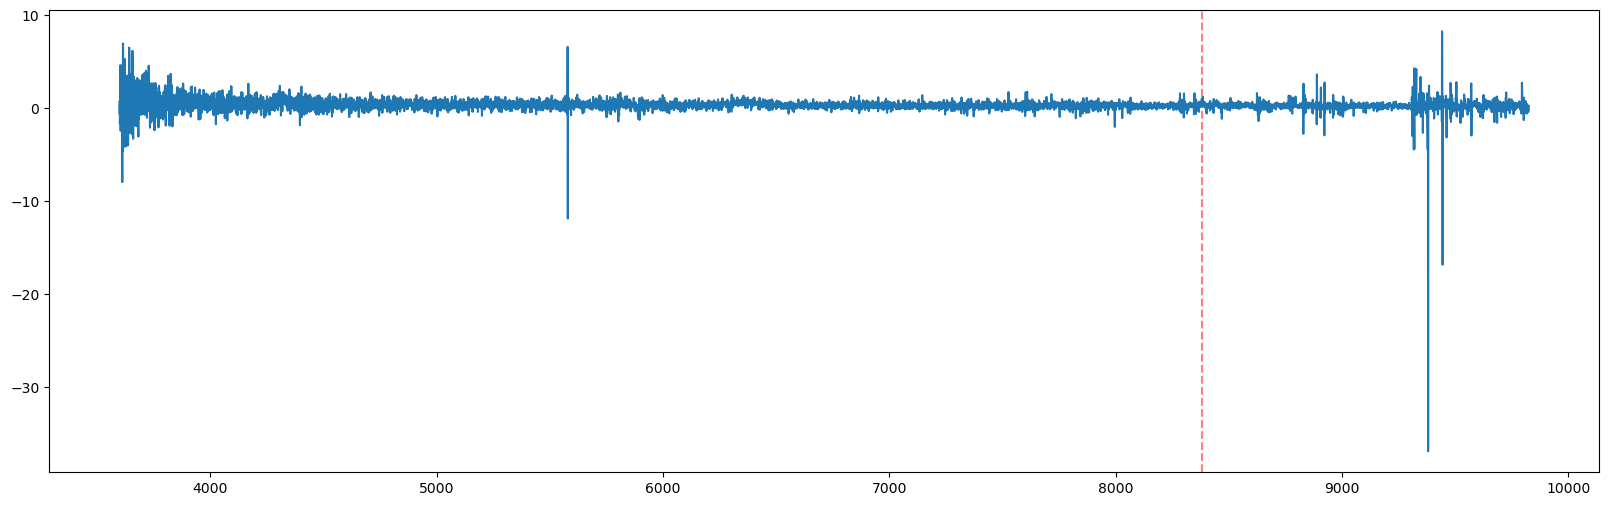


Example data:
TARGETID: 39627809647231306
Redshift: 1.806227505391834
Fluxes: [-1.51225817 -0.29622641 -3.49177933 ...  0.48708421  0.09222072
  0.47907561]
ivar [ 0.1158803   0.10737243  0.09947643 ... 11.44819546 13.04015064
 16.32178879]
Labels: 1
LAE Redshift: 2.406831626306032
LAE NAME ZoomSim_timestep91_direction64
LAE intflux 2.0677574419496767



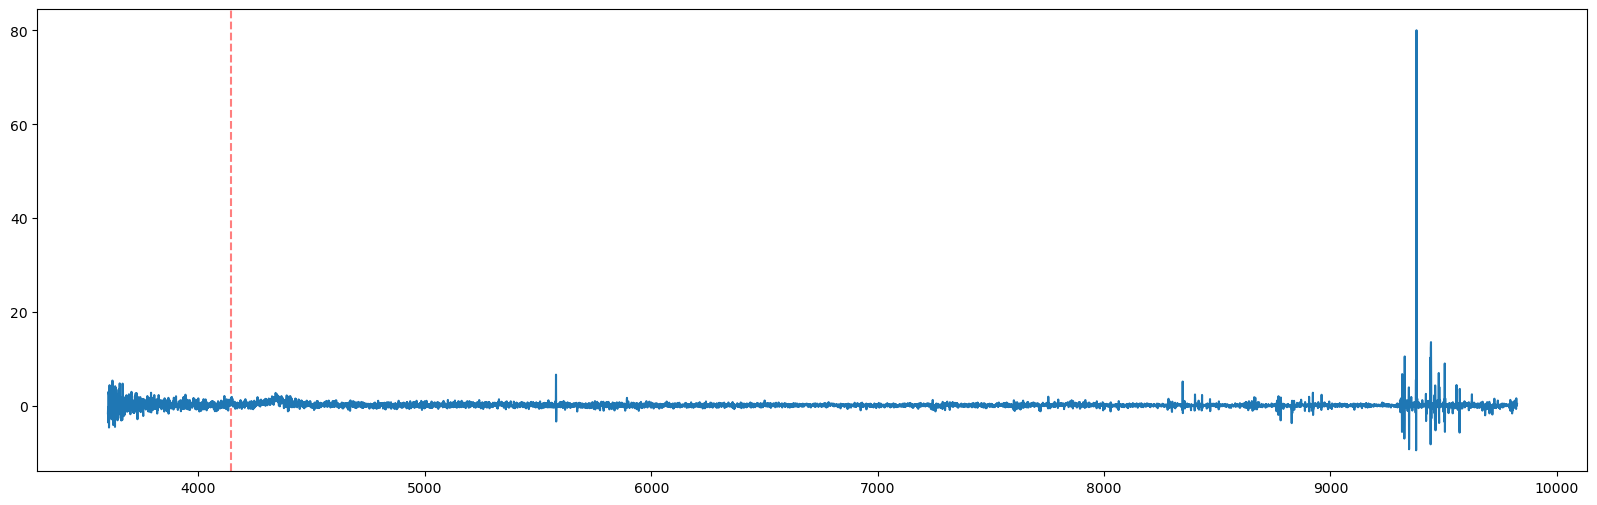


Example data:
TARGETID: 39627809647231952
Redshift: 1.0328569655217872
Fluxes: [3.43567085 0.88610208 0.33746138 ... 0.68788749 0.81066757 0.78466564]
ivar [ 0.19479316  0.22788596  0.21871218 ... 18.57795334 21.42013931
 32.40951538]
Labels: 1
LAE Redshift: 3.488955687126219
LAE NAME ZoomSim_timestep119_direction216
LAE intflux 1.3999386388383106



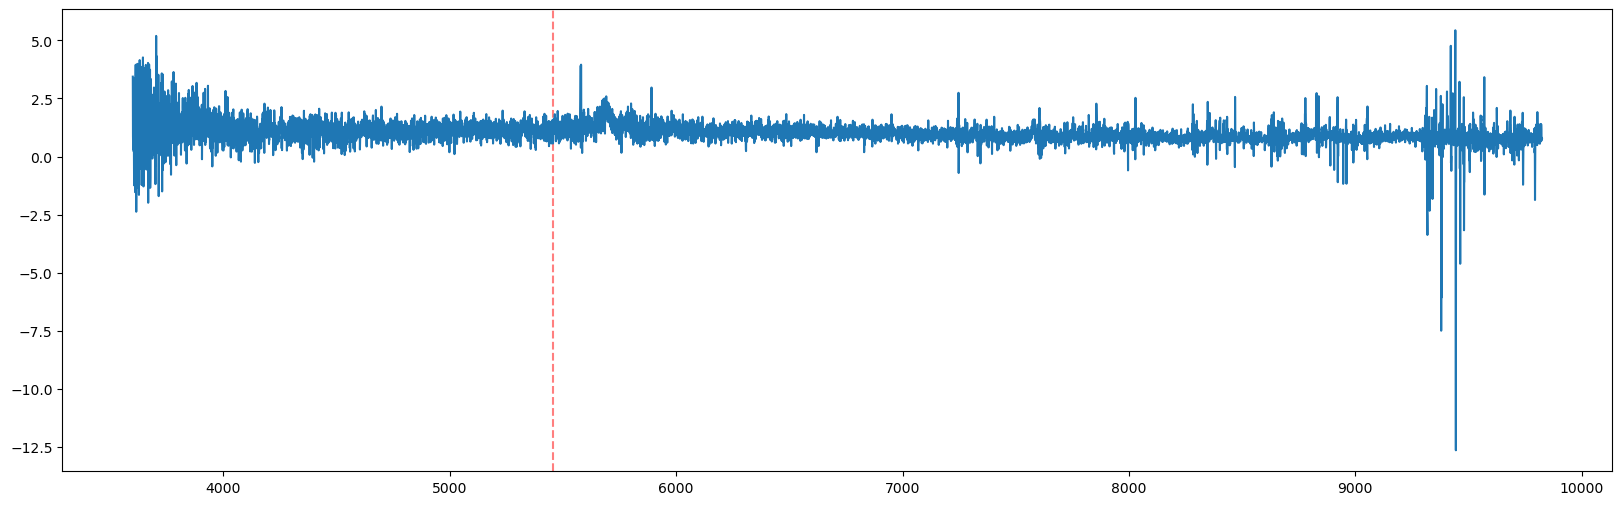


Example data:
TARGETID: 39627809659816026
Redshift: 1.446907028476483
Fluxes: [ 9.03961754  1.14299357 -0.88748032 ...  0.83745259  0.54902995
  1.52053642]
ivar [ 0.16231465  0.17180534  0.17105655 ... 12.34938622 14.45109558
 17.43344498]
Labels: 1
LAE Redshift: 3.1678832276931725
LAE NAME ZoomSim_timestep123_direction71
LAE intflux 1.238229037984594



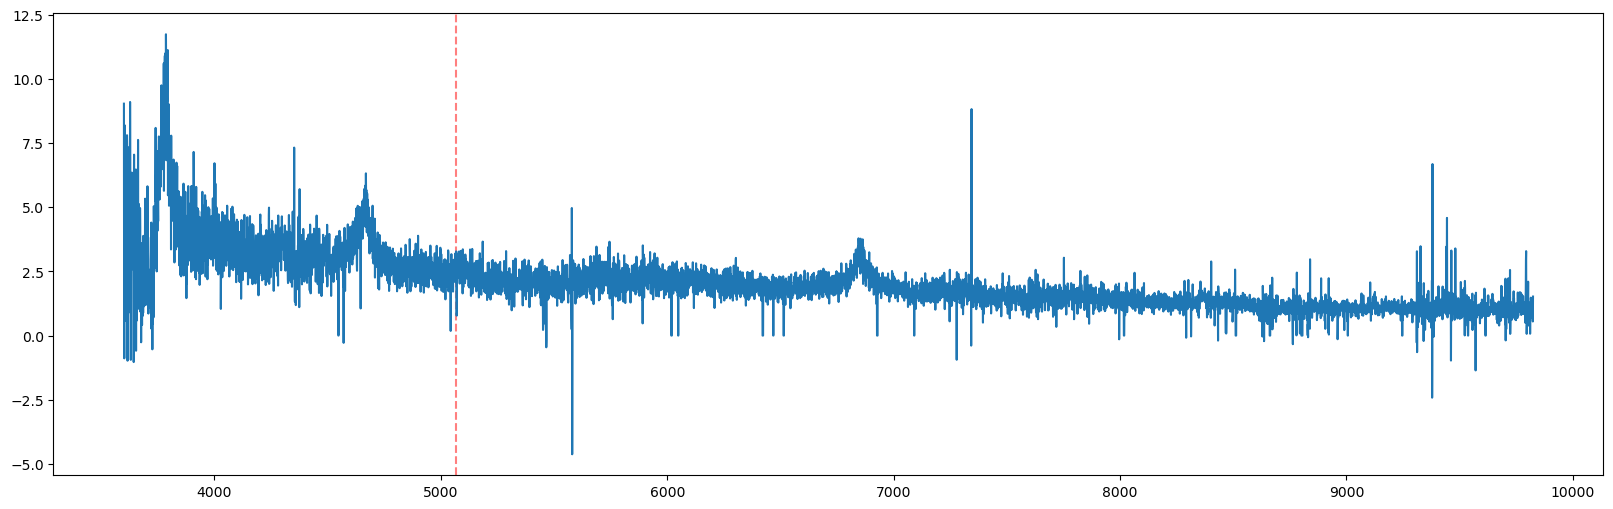


Example data:
TARGETID: 39627815661866288
Redshift: 1.7382052993284647
Fluxes: [ 4.19698429 -2.34548807  4.48038054 ...  0.02746237  0.21949525
  0.26796585]
ivar [ 0.27047217  0.24608713  0.27820069 ... 33.58465576 51.92389679
 73.41552734]
Labels: 1
LAE Redshift: 5.7798731245749355
LAE NAME SPHINX_z4_haloid409478_dir_3
LAE intflux 1.091032994321445



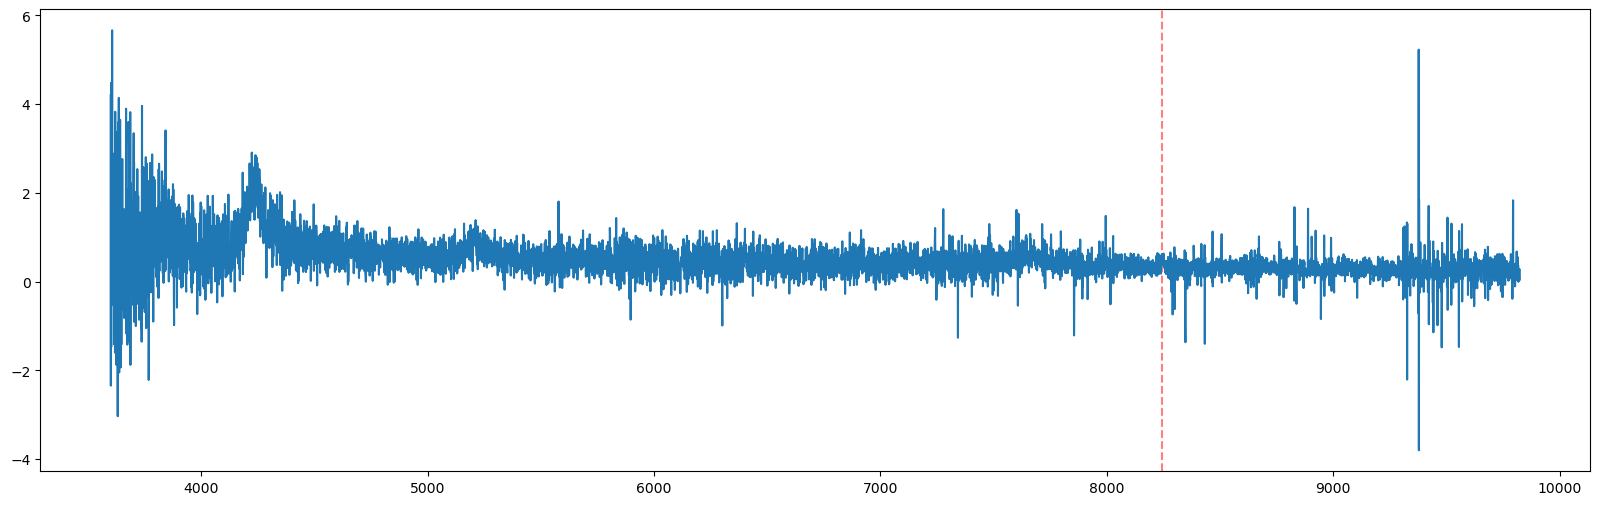


Example data:
TARGETID: 39627815666057864
Redshift: 2.1438349400160477
Fluxes: [-0.17847377 -1.57315993 -2.0953784  ...  0.10335454 -0.04542559
  0.17993319]
ivar [  0.3698135    0.34327164   0.37246358 ...  52.67158127  75.13822174
 108.46058655]
Labels: 1
LAE Redshift: 4.478575932913635
LAE NAME SPHINX_z4_haloid492593_dir_1
LAE intflux 2.7200314127375944



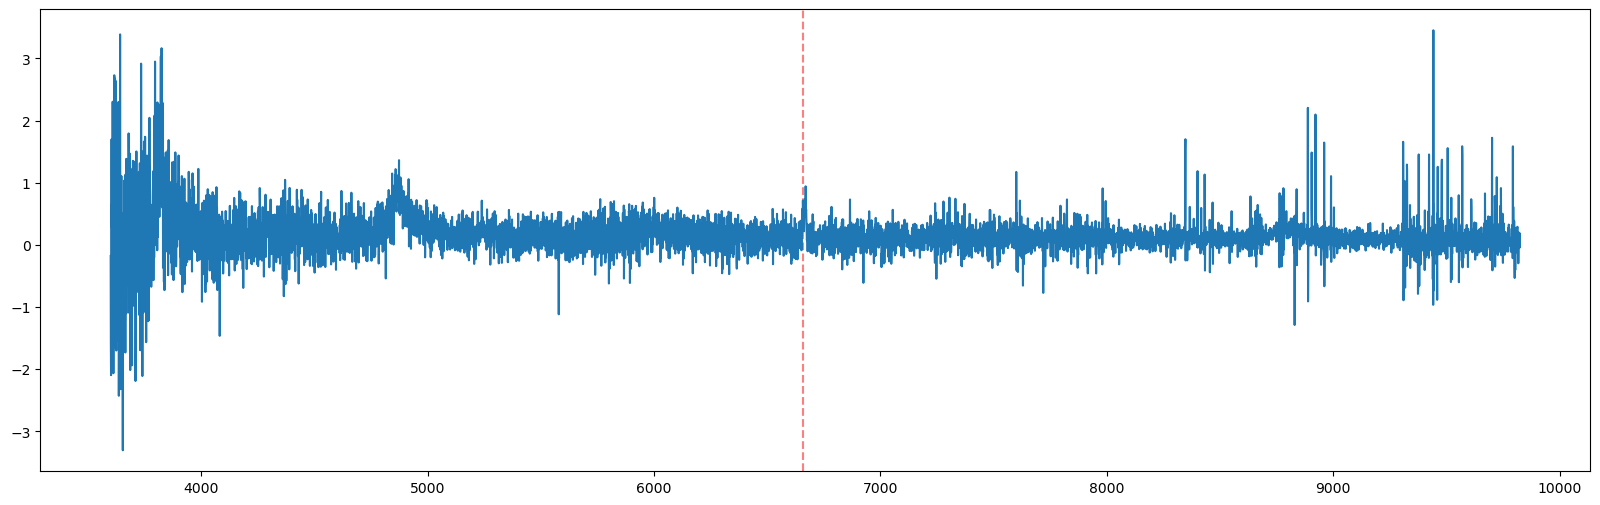


Example data:
TARGETID: 39627815666059149
Redshift: 1.7066387480167493
Fluxes: [-2.54628038  2.36442637  1.69285476 ...  0.27657846  0.03120102
  0.4252232 ]
ivar [ 0.10116994  0.11635442  0.10448453 ... 15.44197464 20.82991028
 22.61413383]
Labels: 1
LAE Redshift: 3.8324480565304144
LAE NAME ZoomSim_timestep113_direction275
LAE intflux 1.212708833217406



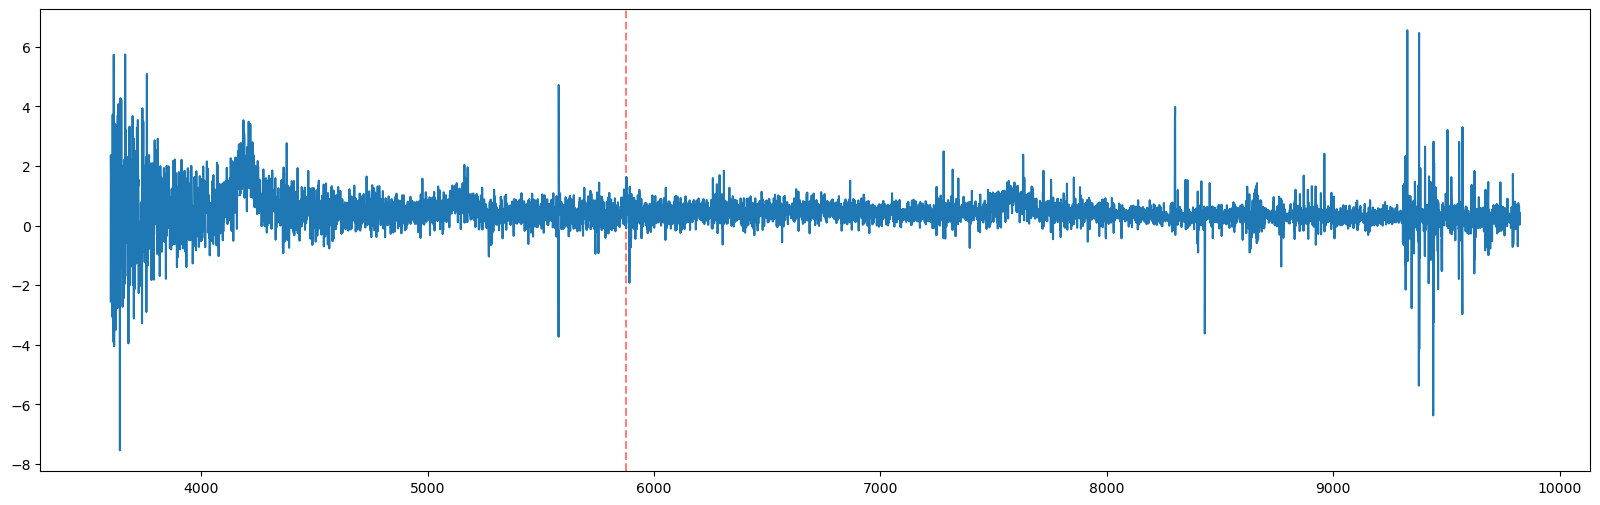


Example data:
TARGETID: 39627815670258961
Redshift: 4.24933135974333
Fluxes: [-0.03377359  0.26179484 -2.83648682 ...  2.20658803  1.78715789
  1.97515047]
ivar [ 0.55096948  0.45951205  0.46398041 ... 40.44709778 49.60276031
 54.57069016]
Labels: 1
LAE Redshift: 4.689119396024717
LAE NAME SPHINX_z5_haloid27024_dir_6
LAE intflux 1.1155386464089327



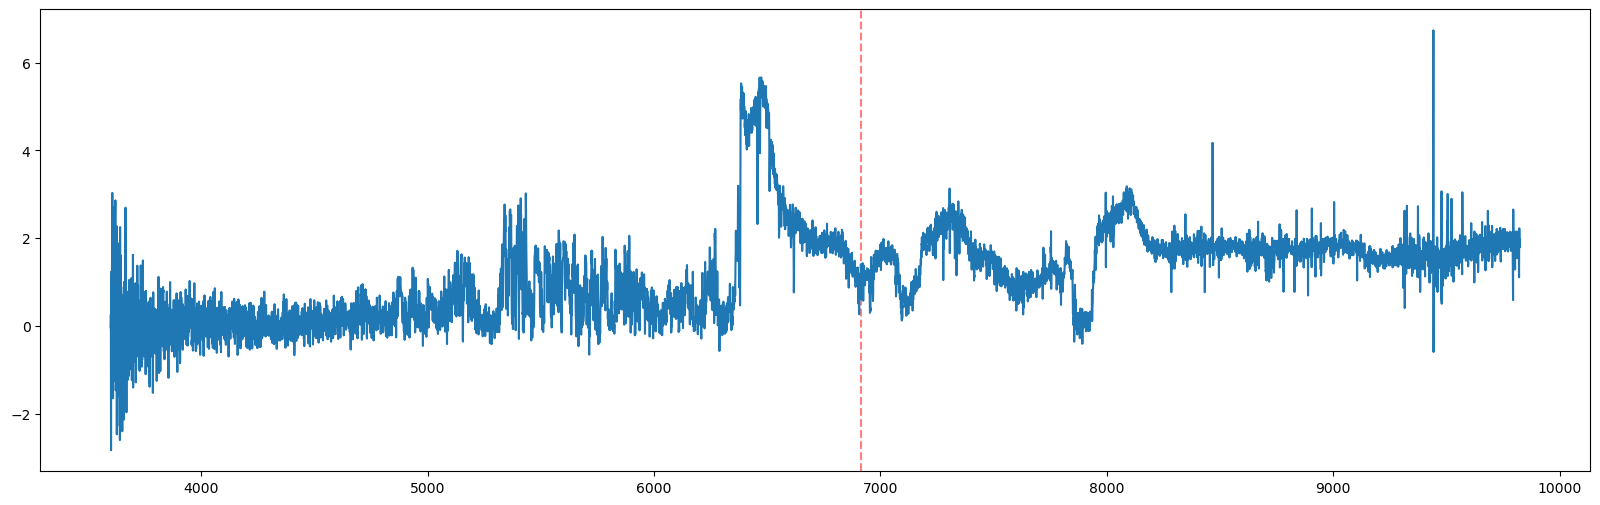


Example data:
TARGETID: 39627815670259482
Redshift: 2.288435064121272
Fluxes: [-1.02636075 -2.44337463 -1.76660311 ...  0.20540375  0.39676738
  0.25106171]
ivar [ 0.42109194  0.31059378  0.30410928 ... 43.51927948 68.88868713
 84.28684235]
Labels: 1
LAE Redshift: 2.4462767708256568
LAE NAME ZoomSim_timestep151_direction107
LAE intflux 5.178395869676351



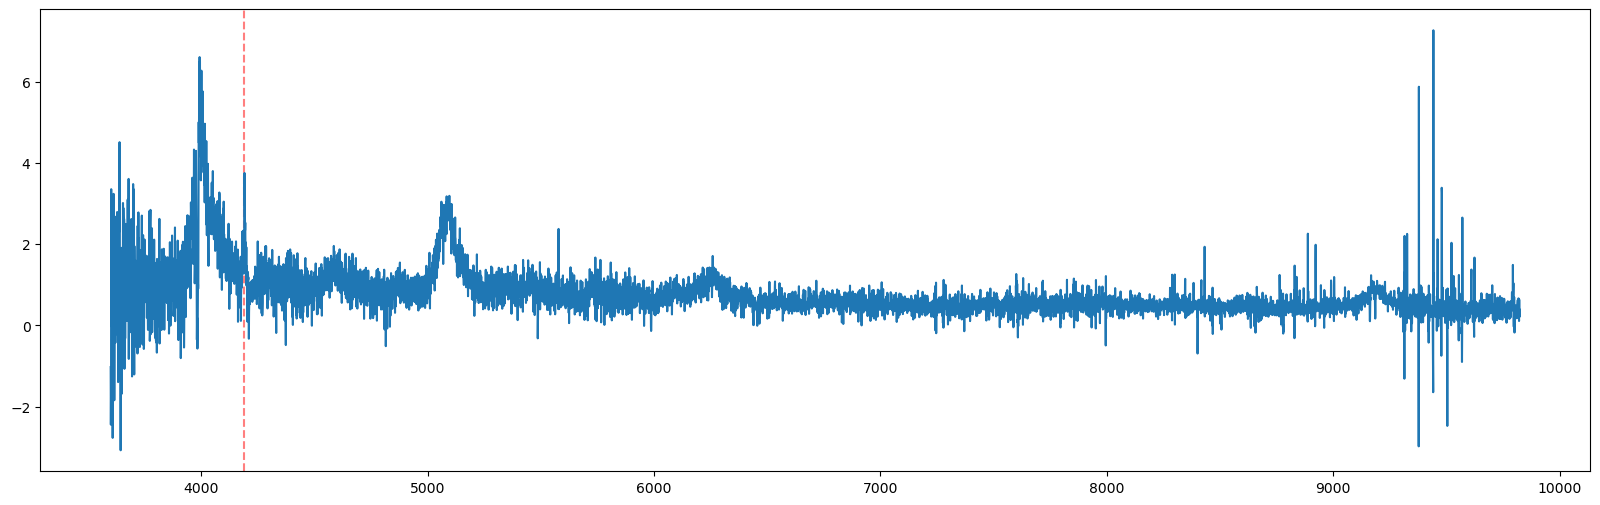


Example data:
TARGETID: 39627815678647323
Redshift: 2.6625168792229776
Fluxes: [ 1.83213997 -0.77236474  1.36952615 ... -0.11284793  0.50666541
  0.14116374]
ivar [ 0.2325498   0.18573758  0.18587181 ... 32.3174324  45.26107025
 69.11691284]
Labels: 1
LAE Redshift: 3.0978477908612194
LAE NAME ZoomSim_timestep91_direction263
LAE intflux 1.119120036965036



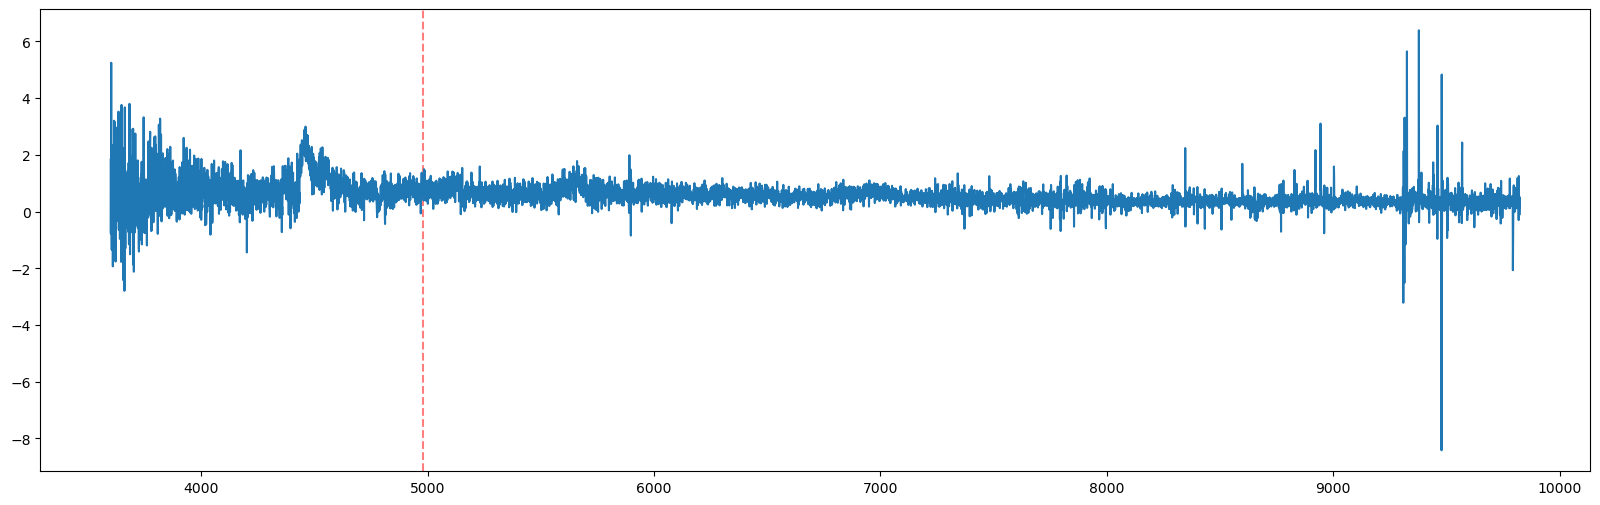


Example data:
TARGETID: 39627815678648262
Redshift: 1.0375227874740753
Fluxes: [ 8.05490017 -0.74547249  0.02151505 ...  0.9901526   1.00956154
  0.68646848]
ivar [ 0.27804905  0.24326688  0.2023049  ... 17.39840698 22.24279976
 25.56033325]
Labels: 1
LAE Redshift: 4.627665447897296
LAE NAME SPHINX_z4_haloid86220_dir_1
LAE intflux 1.2547443301847396



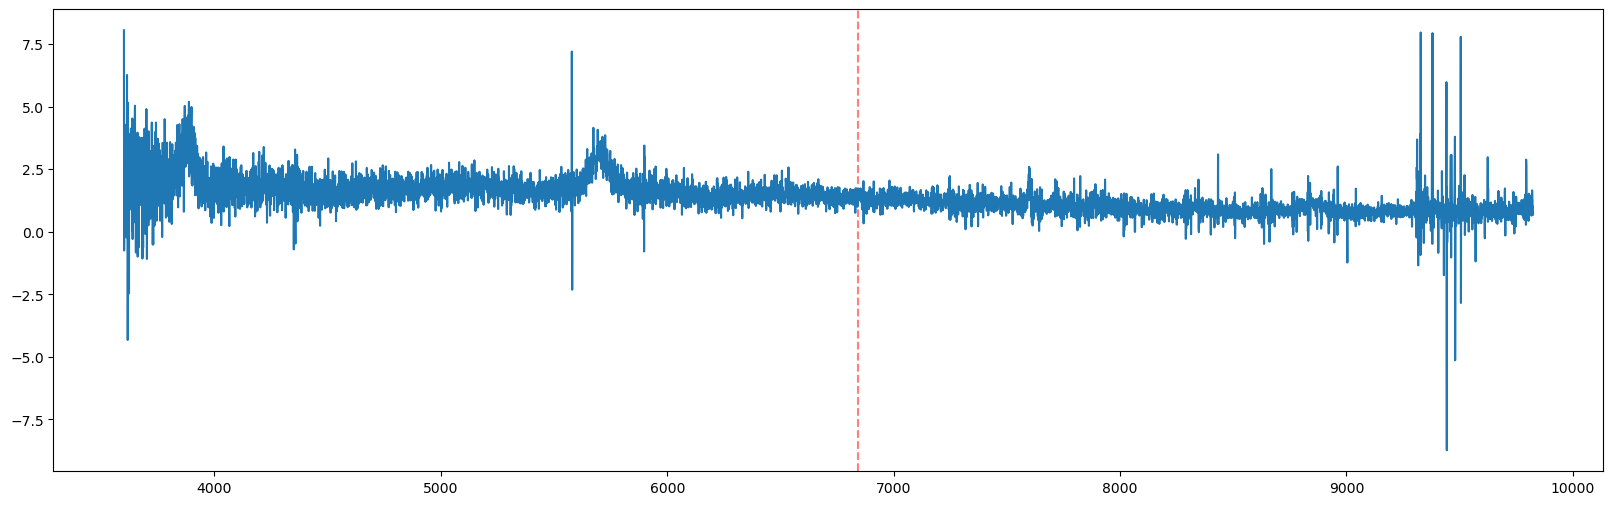


Example data:
TARGETID: 39627815682839132
Redshift: 1.2304411307476069
Fluxes: [10.64431953 12.31402016 15.29645824 ...  1.55821669  2.7274456
  1.69822574]
ivar [ 0.1258323   0.10921865  0.1043147  ... 11.54316044 10.2777338
 15.78365231]
Labels: 1
LAE Redshift: 5.636867199753294
LAE NAME SPHINX_z6_haloid81639_dir_5
LAE intflux 1.346312268828112



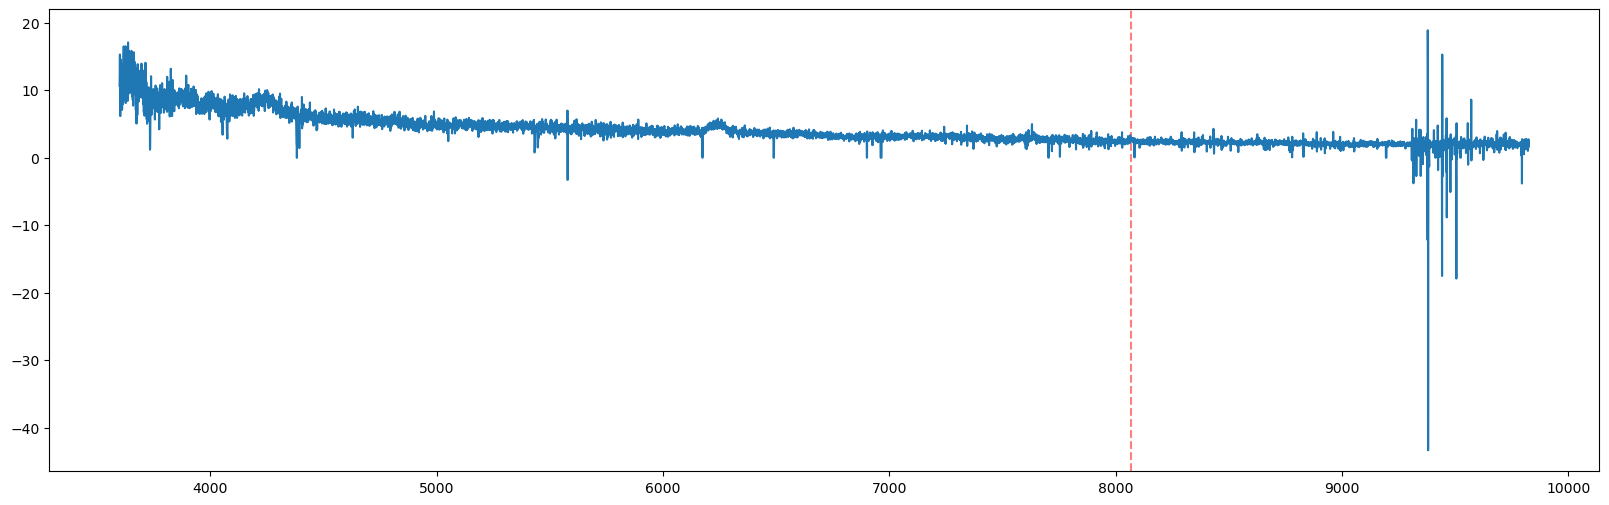


Example data:
TARGETID: 39627815691223731
Redshift: 2.2465576888774907
Fluxes: [4.83837223 3.07875013 2.41803765 ... 1.18625009 0.53687471 0.93459654]
ivar [ 0.286504    0.2288218   0.25894952 ... 40.60909271 57.57782745
 76.19468689]
Labels: 1
LAE Redshift: 3.9131126765436743
LAE NAME ZoomSim_timestep117_direction292
LAE intflux 1.0699903754522546



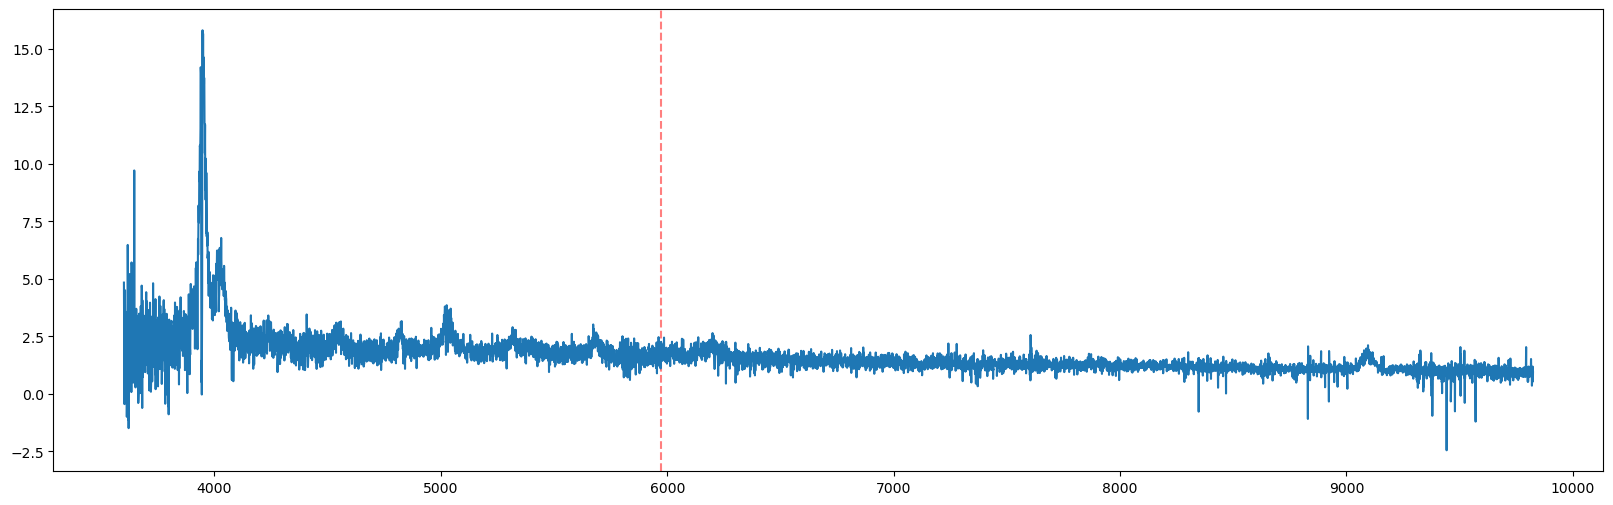


Example data:
TARGETID: 39627815691224645
Redshift: 2.1200344487541725
Fluxes: [0.4316707  0.16624388 2.24769664 ... 0.04153024 0.00247262 0.22905253]
ivar [ 0.29139495  0.27442774  0.26585567 ... 36.93843079 57.4221611
 90.77806091]
Labels: 1
LAE Redshift: 4.941500931894752
LAE NAME SPHINX_z4_haloid349071_dir_5
LAE intflux 1.490791939475852



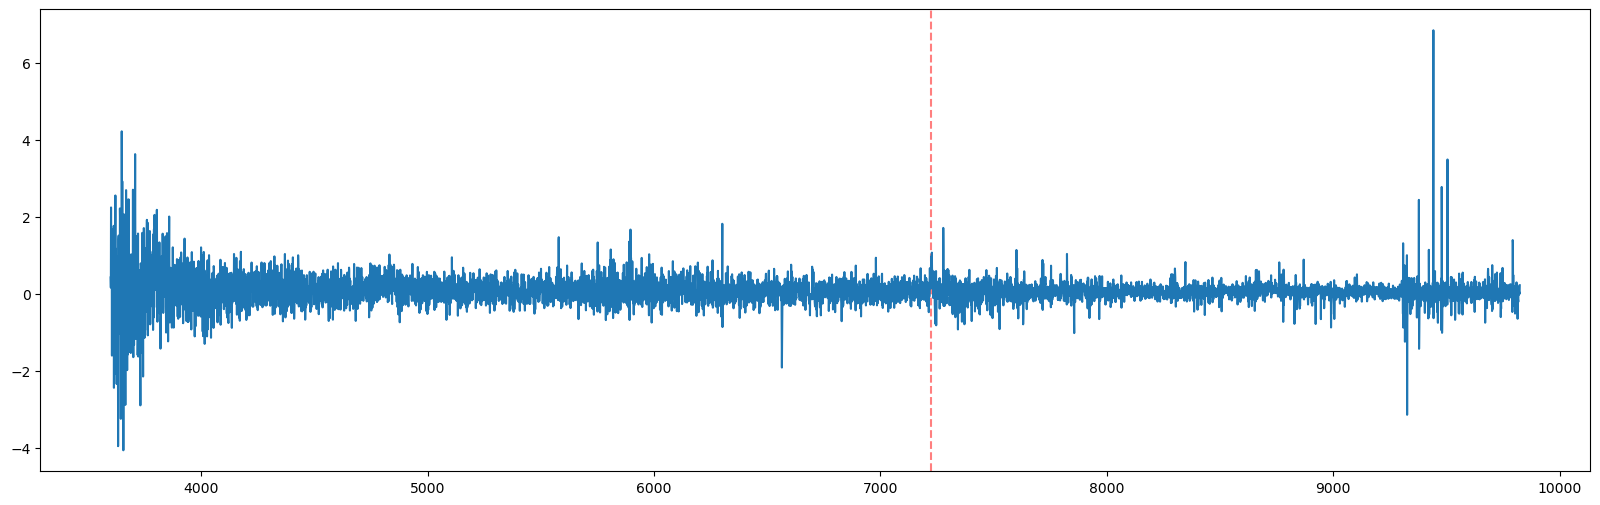


Example data:
TARGETID: 39627815691226425
Redshift: 1.6992528790700936
Fluxes: [-1.77756071 -1.15075469 -0.24586886 ... -0.00391773  0.15900315
 -0.1112676 ]
ivar [  0.51970619   0.50537503   0.51726353 ...  51.72734833  68.40460205
 109.62851715]
Labels: 1
LAE Redshift: 4.298566894998553
LAE NAME SPHINX_z4_haloid263000_dir_0
LAE intflux 3.0276442262378964



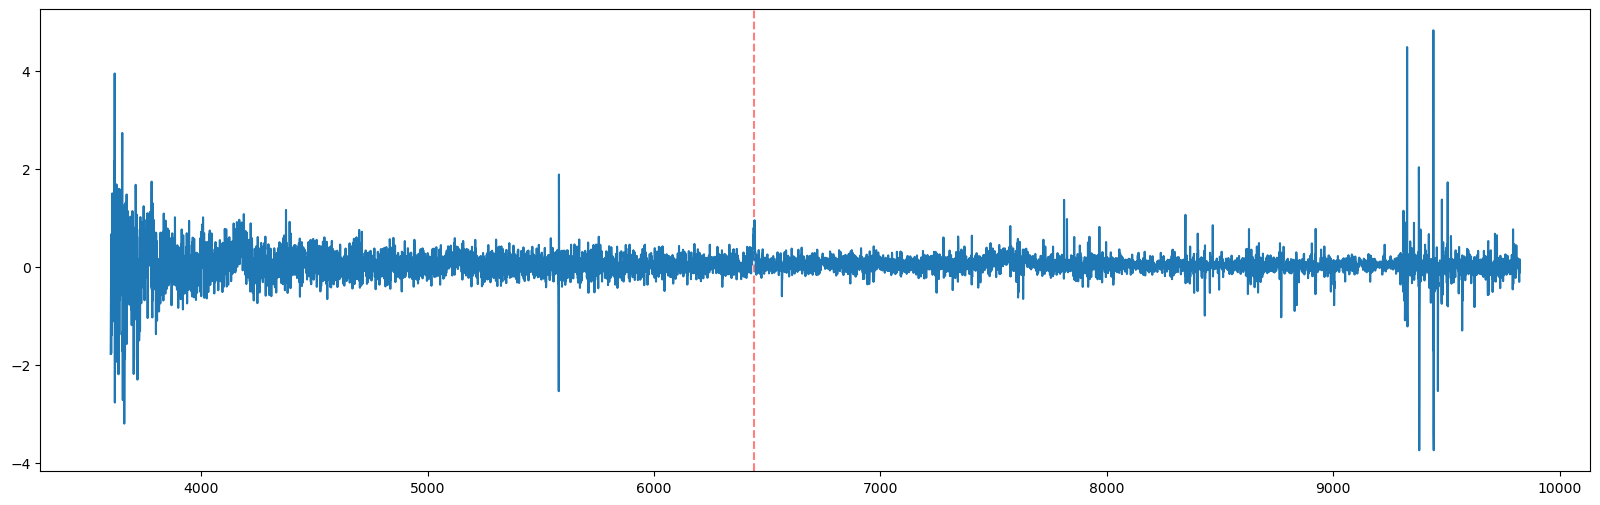


Example data:
TARGETID: 39627815695419013
Redshift: 0.7594223072315205
Fluxes: [ 1.88794017 -0.50939512 -2.70172238 ...  0.09339759  0.03707549
  0.50699401]
ivar [ 0.08544269  0.11290597  0.11595034 ... 13.18799496 17.17433357
 21.73207664]
Labels: 1
LAE Redshift: 3.222517107300658
LAE NAME ZoomSim_timestep93_direction0
LAE intflux 1.0953757401333695



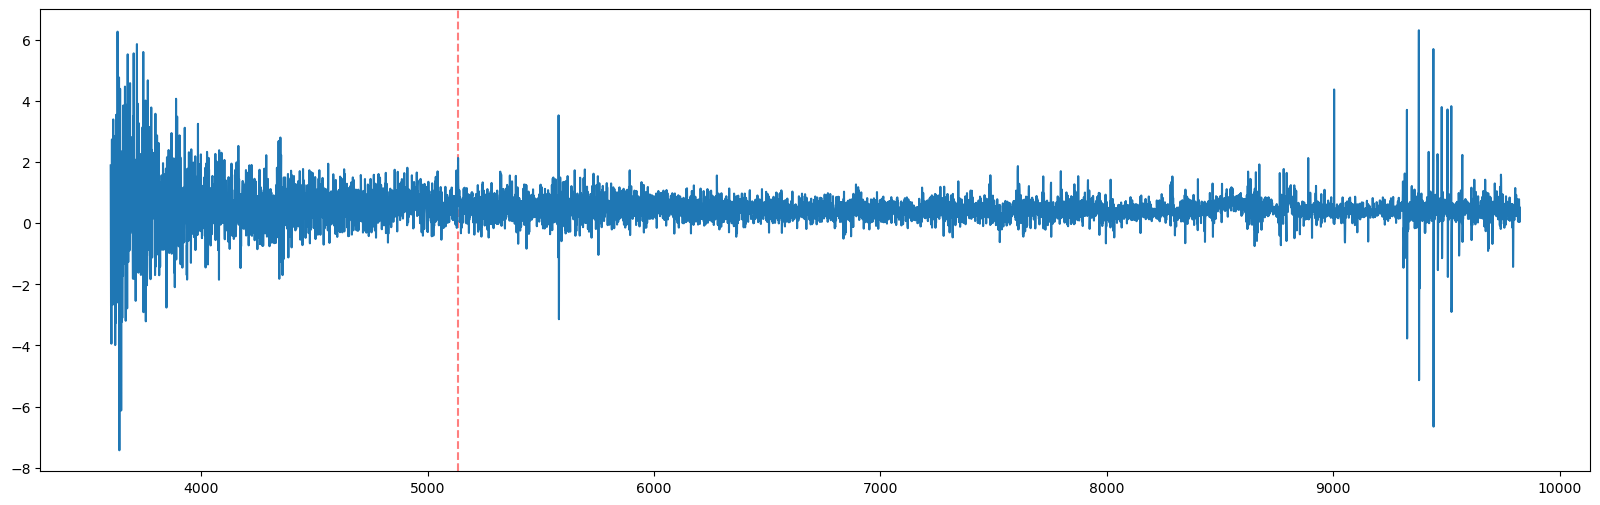


Example data:
TARGETID: 39627815695420514
Redshift: 1.3359280894163084
Fluxes: [ 5.36496544  7.22221613  2.49727988 ... -0.24019256  0.56105858
  0.71400791]
ivar [ 0.36100224  0.33219585  0.29457432 ... 18.14283562 21.35720825
 26.61704254]
Labels: 1
LAE Redshift: 5.0380734431563035
LAE NAME SPHINX_z5_haloid96750_dir_9
LAE intflux 3.764348071287067



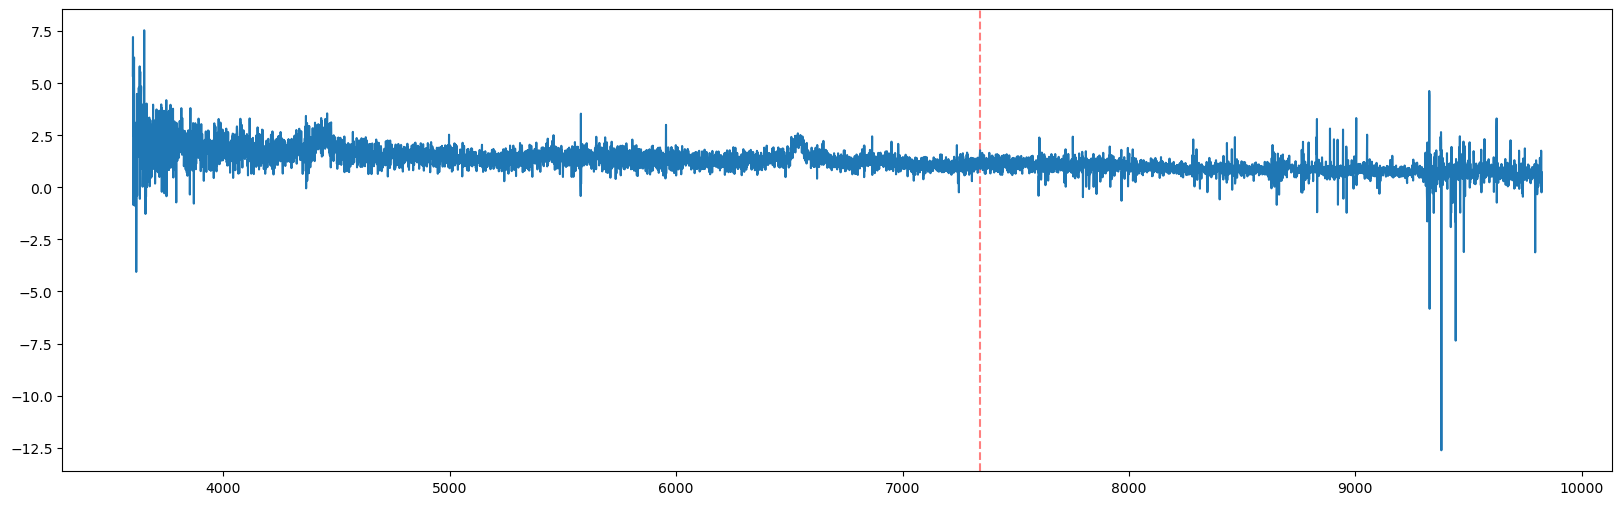


Example data:
TARGETID: 39627815703805999
Redshift: 2.467971207921107
Fluxes: [ 0.23599216  0.91681564 -0.3405982  ... -0.04433291 -0.12450172
  0.19073002]
ivar [  0.50900483   0.49529541   0.44774988 ...  37.42855072  52.79477692
 100.68652344]
Labels: 1
LAE Redshift: 4.632663657104828
LAE NAME SPHINX_z5_haloid246404_dir_3
LAE intflux 1.2532754753061244



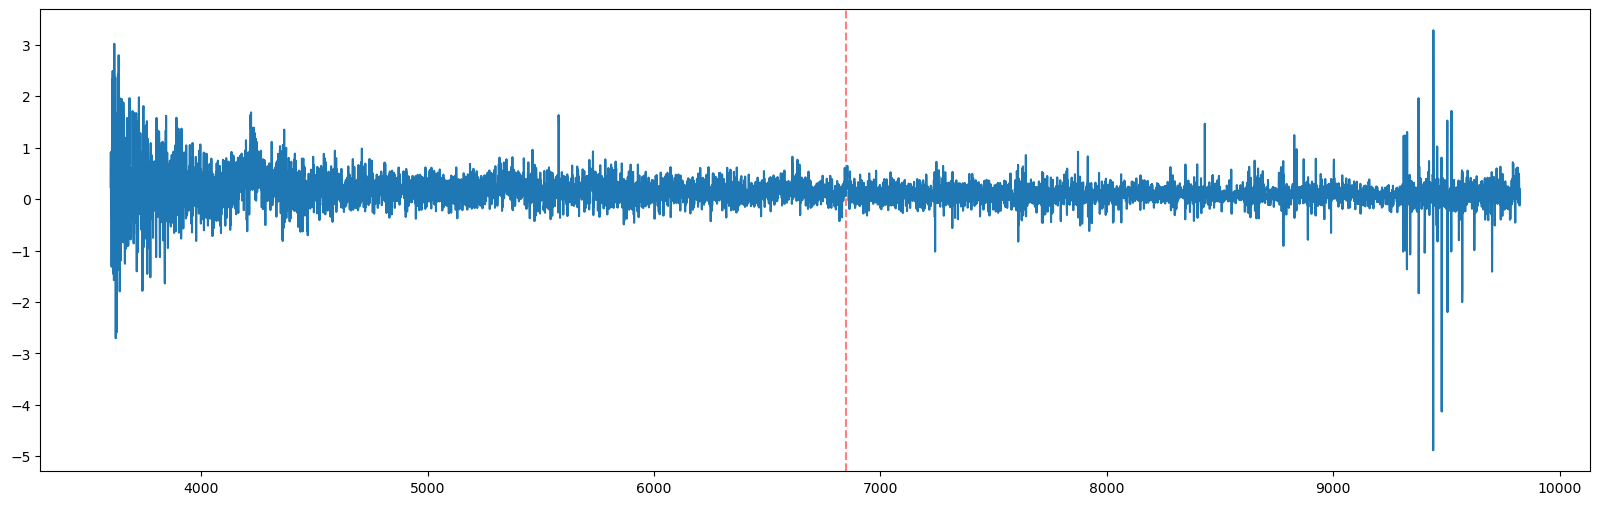


Example data:
TARGETID: 39627815703810481
Redshift: 1.4173202085926049
Fluxes: [ 2.18413115 -2.15492868  3.03448534 ...  0.07609015  0.23913977
  0.03931639]
ivar [ 0.10179236  0.09322511  0.10246556 ... 19.43936729 27.31553459
 45.2770195 ]
Labels: 1
LAE Redshift: 3.006827860784248
LAE NAME ZoomSim_timestep105_direction267
LAE intflux 1.4963929207281133



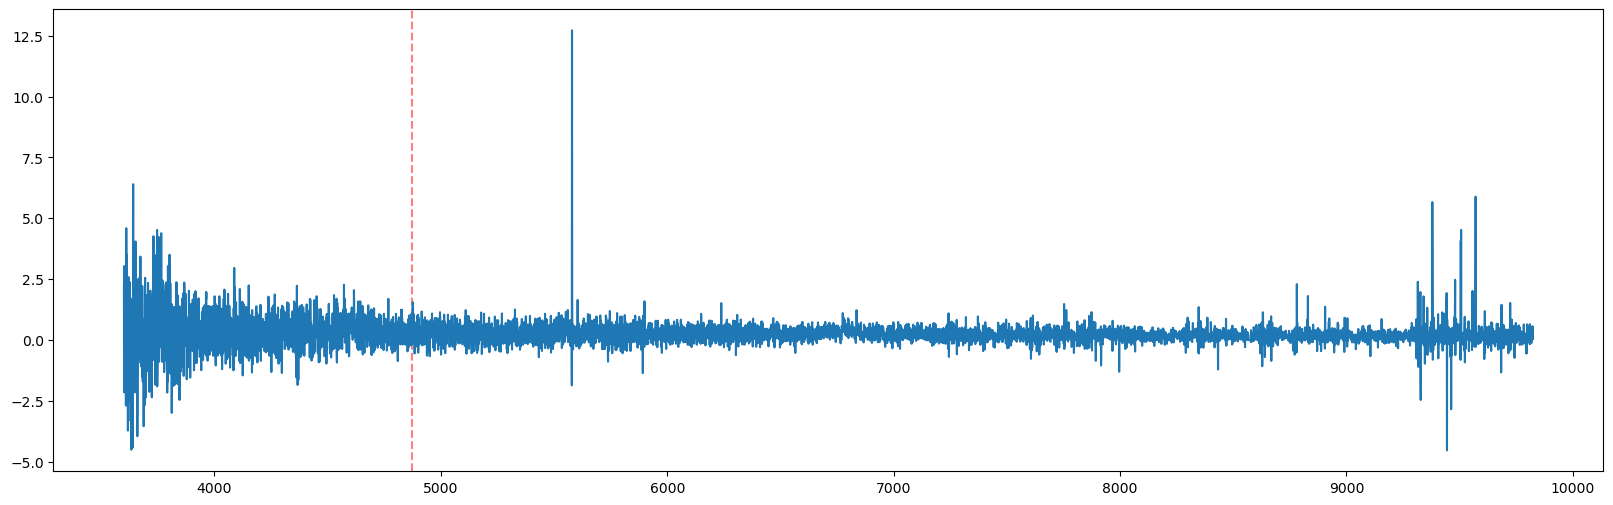


Example data:
TARGETID: 39627821693275040
Redshift: 1.9291095783757104
Fluxes: [-1.07952452 -0.33702615  1.54107368 ...  0.38731074 -0.03414527
  0.34826276]
ivar [ 0.40904704  0.3898221   0.4926956  ... 14.40810776 21.02562714
 27.83695793]
Labels: 1
LAE Redshift: 3.2847720129805427
LAE NAME ZoomSim_timestep104_direction151
LAE intflux 1.6006143557554706



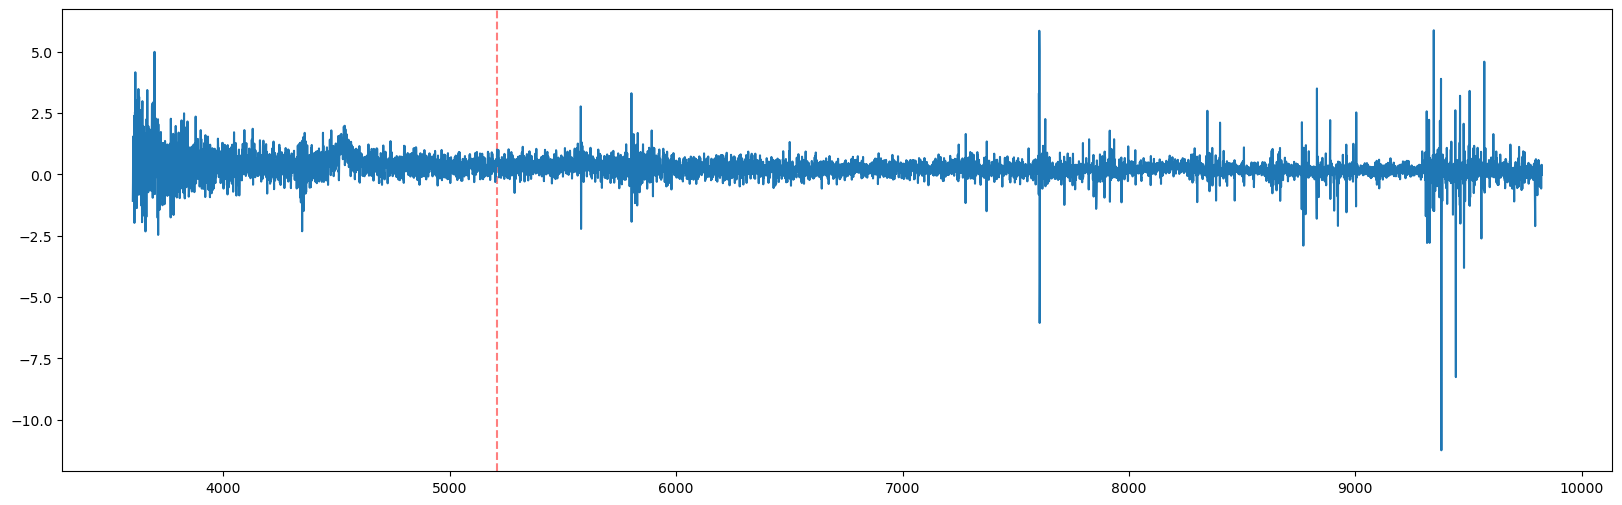


Example data:
TARGETID: 39627821697471982
Redshift: 1.431460657508436
Fluxes: [10.13290024 -1.47300303 -2.01865292 ... -0.20879477  0.72116381
  0.57859677]
ivar [ 0.09467189  0.07819329  0.08747776 ... 13.32034302 17.10879707
 18.73121834]
Labels: 1
LAE Redshift: 2.3484542317369095
LAE NAME ZoomSim_timestep115_direction286
LAE intflux 3.644653649086418



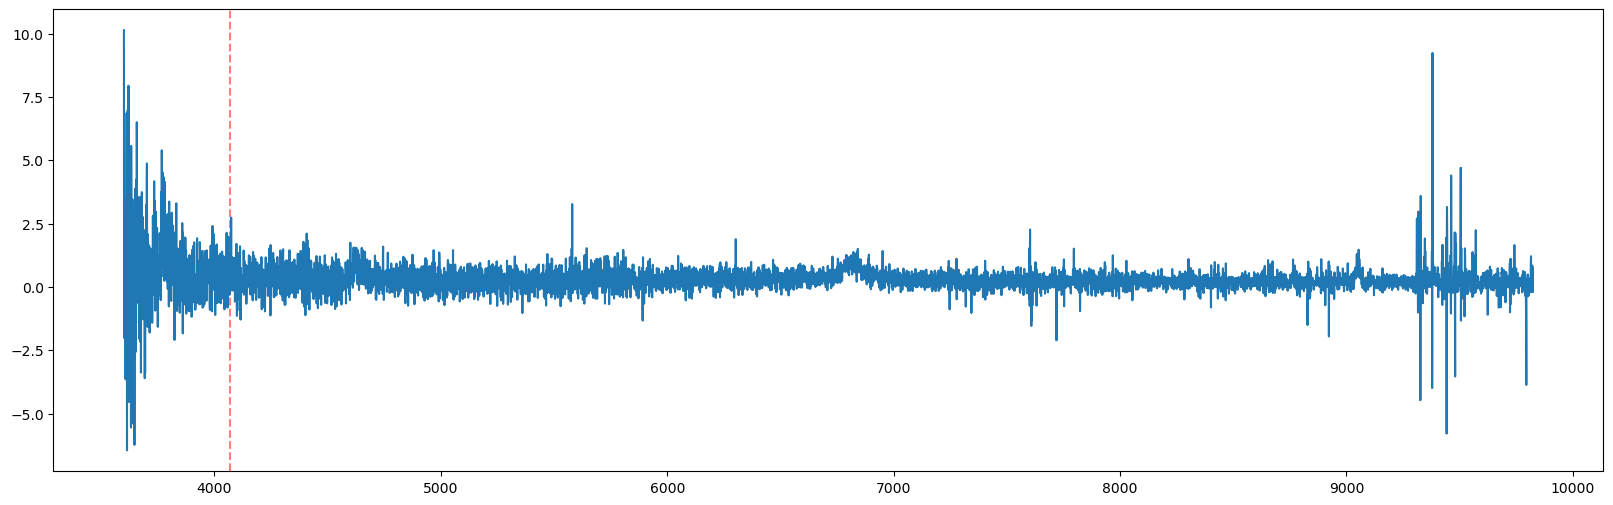


Example data:
TARGETID: 39627821705856504
Redshift: 3.0295364274339516
Fluxes: [-0.82335603 -3.28764844  6.20931339 ...  0.94332737  1.01771295
  1.16288376]
ivar [ 0.35058096  0.28647628  0.3183434  ... 45.27420425 60.65662003
 71.45342255]
Labels: 1
LAE Redshift: 4.289274087899487
LAE NAME SPHINX_z6_haloid147097_dir_5
LAE intflux 1.3352205583545251



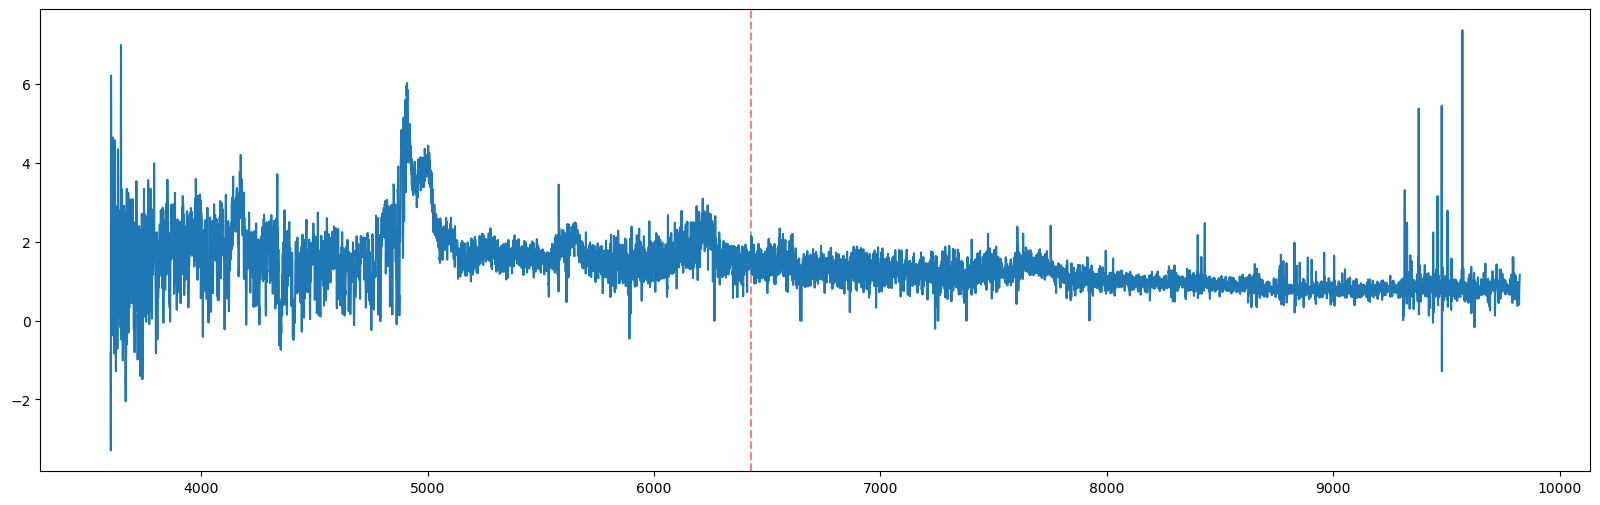


Example data:
TARGETID: 39627821705858755
Redshift: 0.6225017925800161
Fluxes: [1.53447175 0.88404983 4.25614405 ... 0.81585407 0.63142157 0.83458459]
ivar [ 0.20676064  0.15444444  0.1560943  ... 35.09967422 50.30780792
 59.31765747]
Labels: 1
LAE Redshift: 4.599725428772403
LAE NAME SPHINX_z6_haloid186603_dir_4
LAE intflux 1.4860417270270063



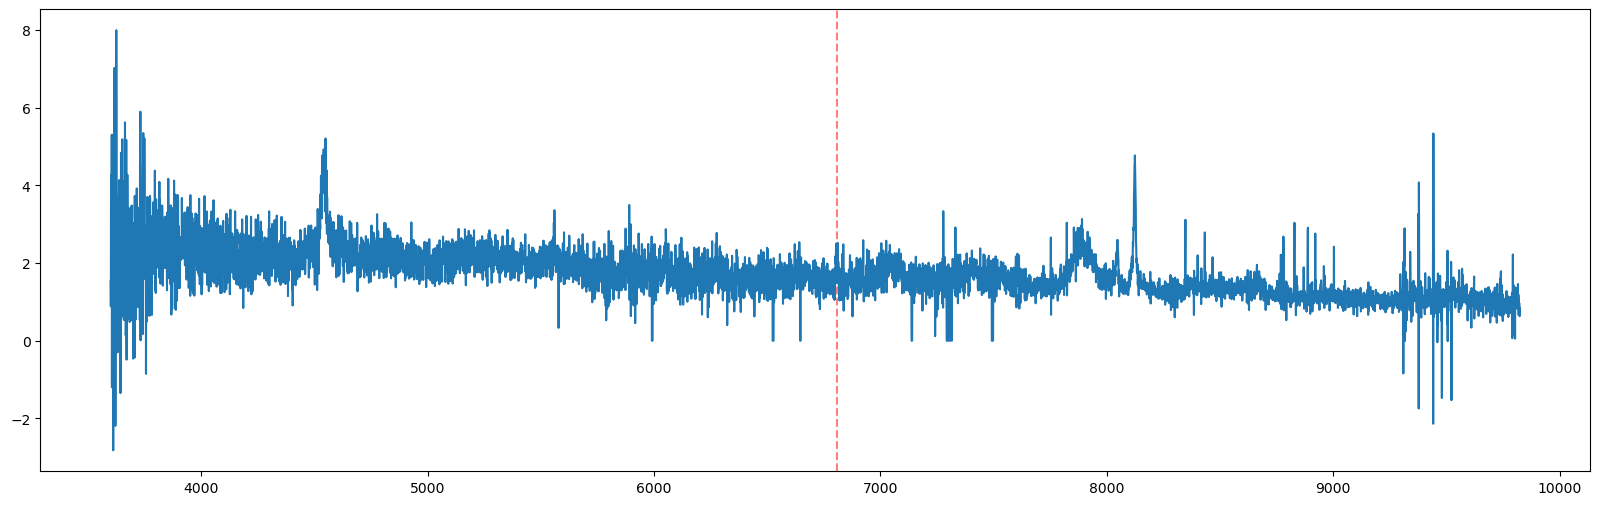


Example data:
TARGETID: 39627821710050325
Redshift: 2.174100786912318
Fluxes: [2.4971056  2.0910871  3.0733254  ... 1.27209198 0.77296972 1.14878929]
ivar [ 0.4106766   0.31618235  0.28807107 ... 30.11467171 43.089077
 56.67651367]
Labels: 1
LAE Redshift: 5.7968487522071905
LAE NAME SPHINX_z6_haloid51169_dir_8
LAE intflux 2.206166107517977



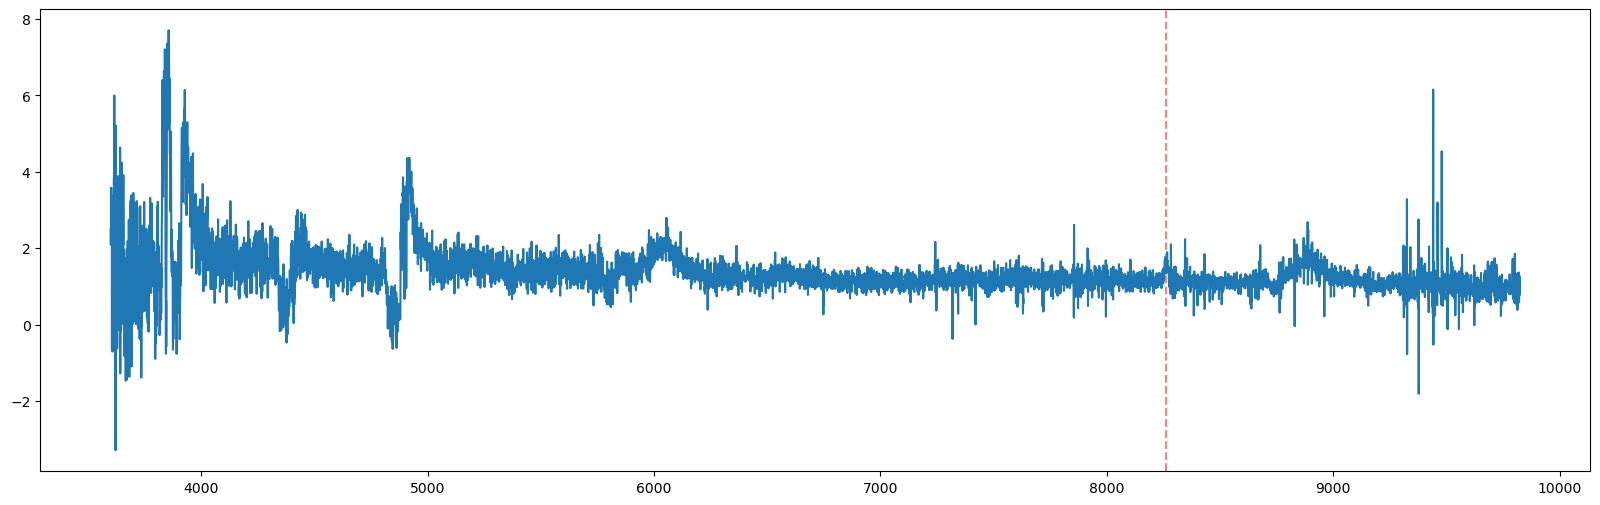


Example data:
TARGETID: 39627821710051763
Redshift: 2.8234745087162545
Fluxes: [-0.46916345  2.59586596  0.62513882 ...  0.00372654  0.30748439
 -0.00348178]
ivar [ 0.42630586  0.31772909  0.337901   ... 36.84990692 57.93901825
 70.13918304]
Labels: 1
LAE Redshift: 4.895629133982346
LAE NAME SPHINX_z6_haloid146417_dir_9
LAE intflux 1.0752642426305112



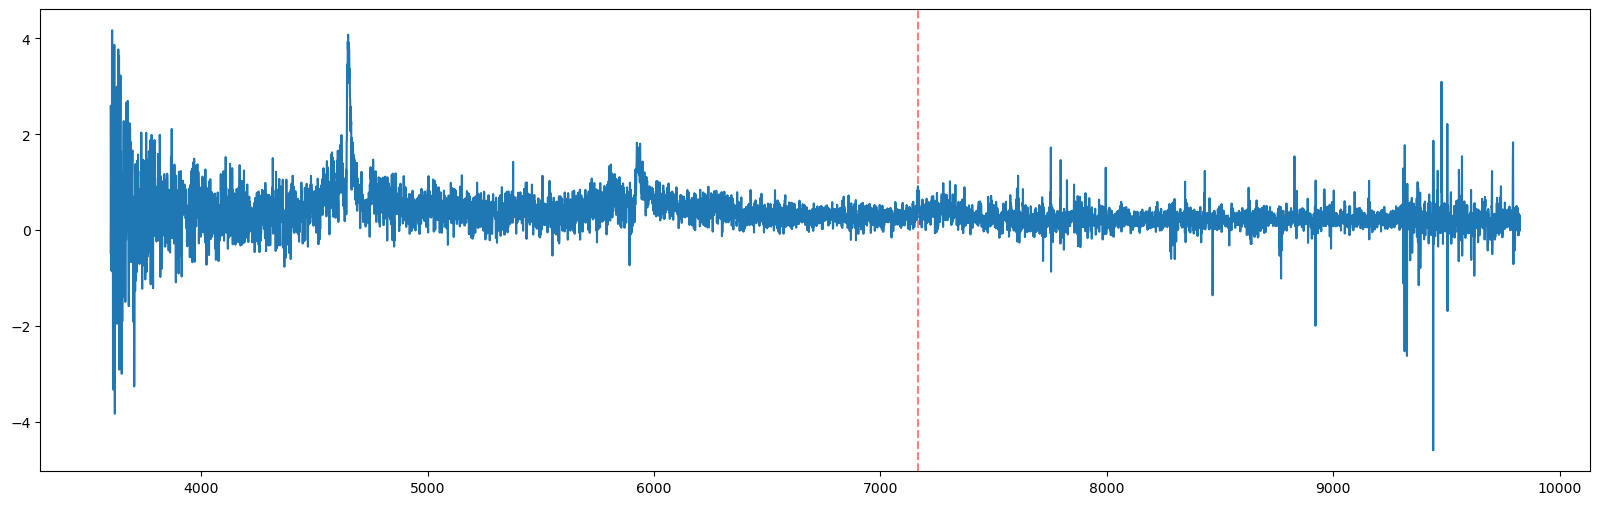


Example data:
TARGETID: 39627821710053433
Redshift: 2.357034302279312
Fluxes: [-0.24327922  0.85095739  2.09582376 ...  0.93166041  0.41288781
  0.60114634]
ivar [ 0.25058353  0.18194686  0.19785482 ... 38.07441711 55.601017
 80.83227539]
Labels: 1
LAE Redshift: 5.367308566933286
LAE NAME SPHINX_z6_haloid79160_dir_7
LAE intflux 3.4619726412320717



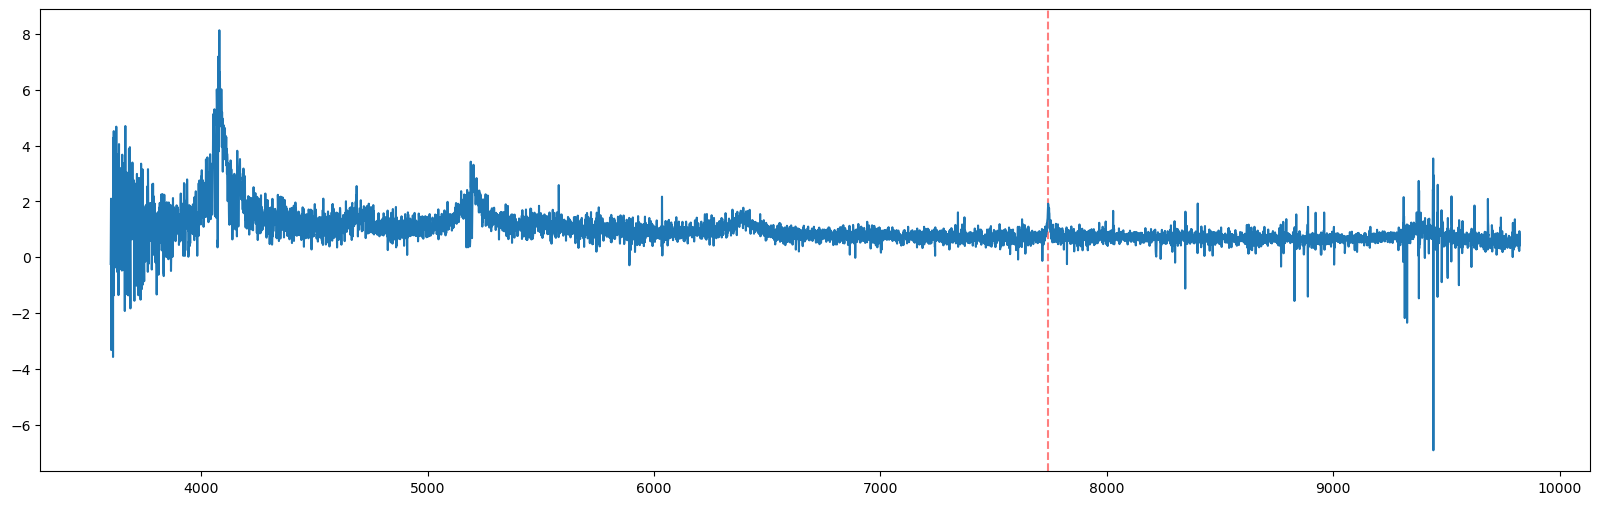


Example data:
TARGETID: 39627821714244196
Redshift: 2.772028607874142
Fluxes: [ 4.79633999 -0.35526216 -2.08630633 ... -0.23094344  0.45836031
 -0.01769887]
ivar [ 0.1584235   0.15491743  0.17091307 ... 12.92810154 12.43999767
 20.14328194]
Labels: 1
LAE Redshift: 2.855906178653414
LAE NAME ZoomSim_timestep152_direction243
LAE intflux 4.744626807957443



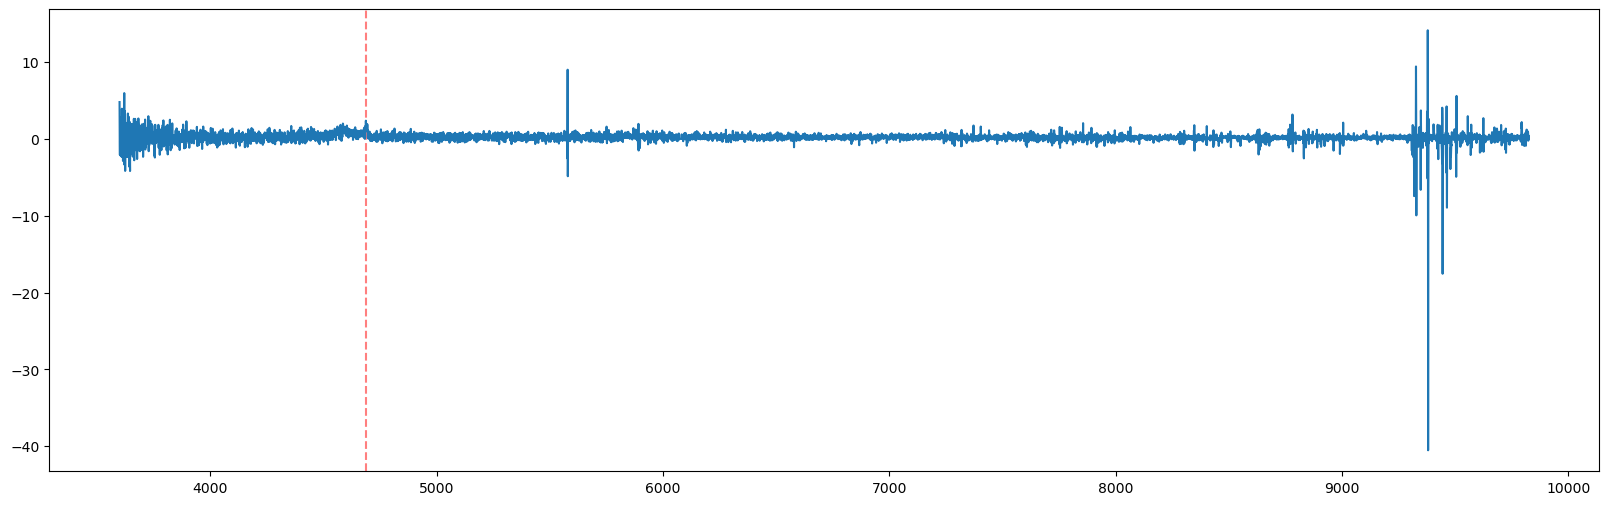


Example data:
TARGETID: 39627821714247334
Redshift: 2.948260673094172
Fluxes: [0.59582925 0.03431229 1.17278957 ... 0.48061994 0.78609866 0.09728873]
ivar [ 0.52680606  0.49345419  0.4677639  ... 52.93899155 63.38899994
 94.77097321]
Labels: 1
LAE Redshift: 3.981754331763751
LAE NAME ZoomSim_timestep135_direction176
LAE intflux 1.0903441243755905



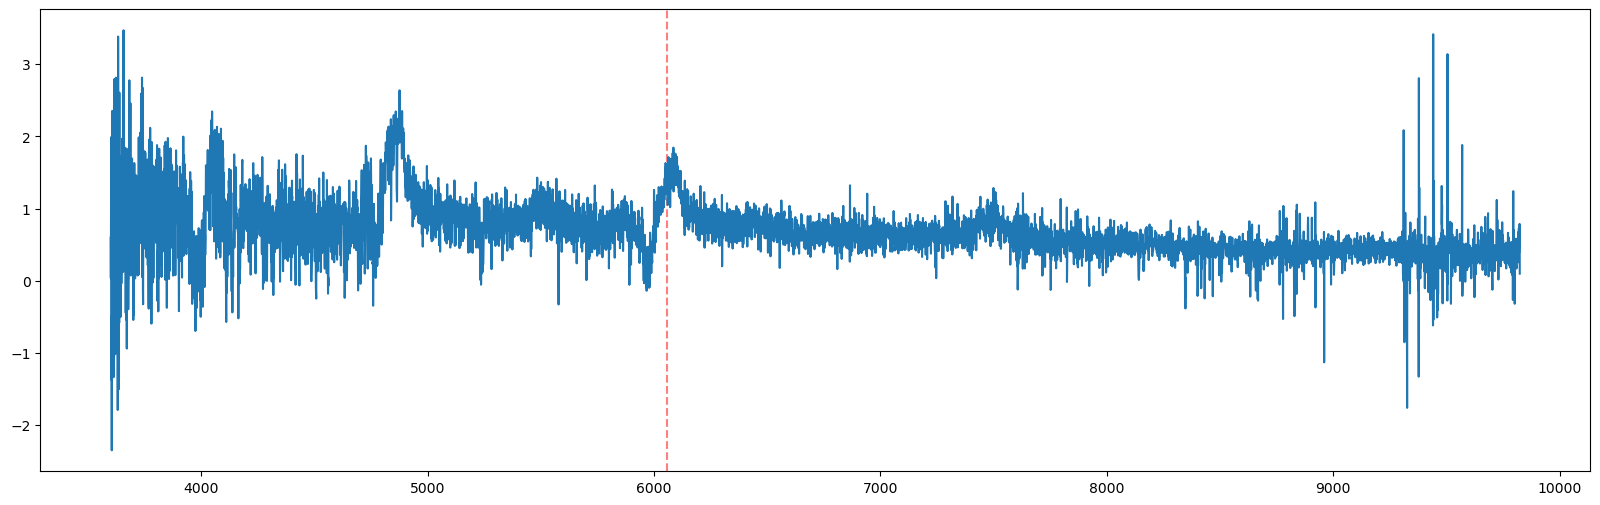


Example data:
TARGETID: 39627821714247728
Redshift: 2.2083973352197175
Fluxes: [ 0.04894639 -2.09119725  0.53942192 ...  0.38555548  0.21489921
  0.24228285]
ivar [  0.49497423   0.46562621   0.42833656 ...  60.03278732  83.69464111
 117.96473694]
Labels: 1
LAE Redshift: 2.3024639056186484
LAE NAME ZoomSim_timestep112_direction232
LAE intflux 3.7803783354438663



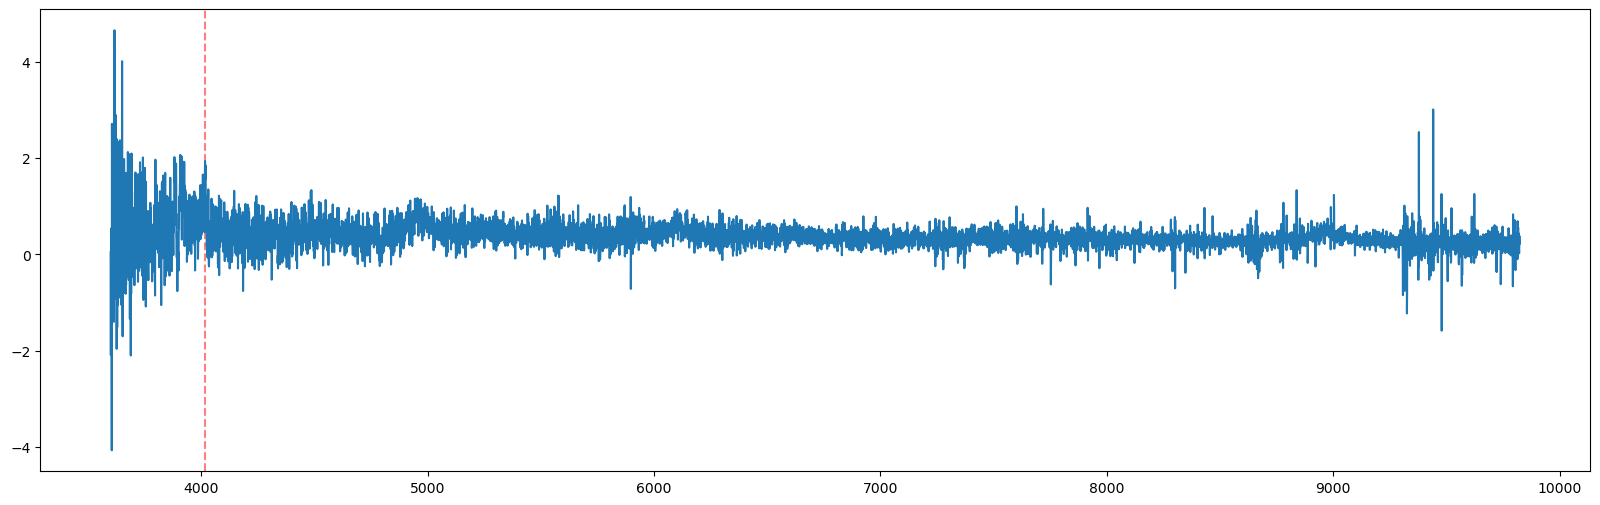


Example data:
TARGETID: 39627821714248259
Redshift: 0.902544913042549
Fluxes: [ 7.34882307 -1.6065737  -0.80157572 ...  1.36682713  0.75149924
  1.18848598]
ivar [ 0.17787743  0.16133927  0.16226436 ... 12.44592857 11.69941044
 18.8492794 ]
Labels: 1
LAE Redshift: 5.477743450367853
LAE NAME SPHINX_z6_haloid90519_dir_0
LAE intflux 1.0338474446147496



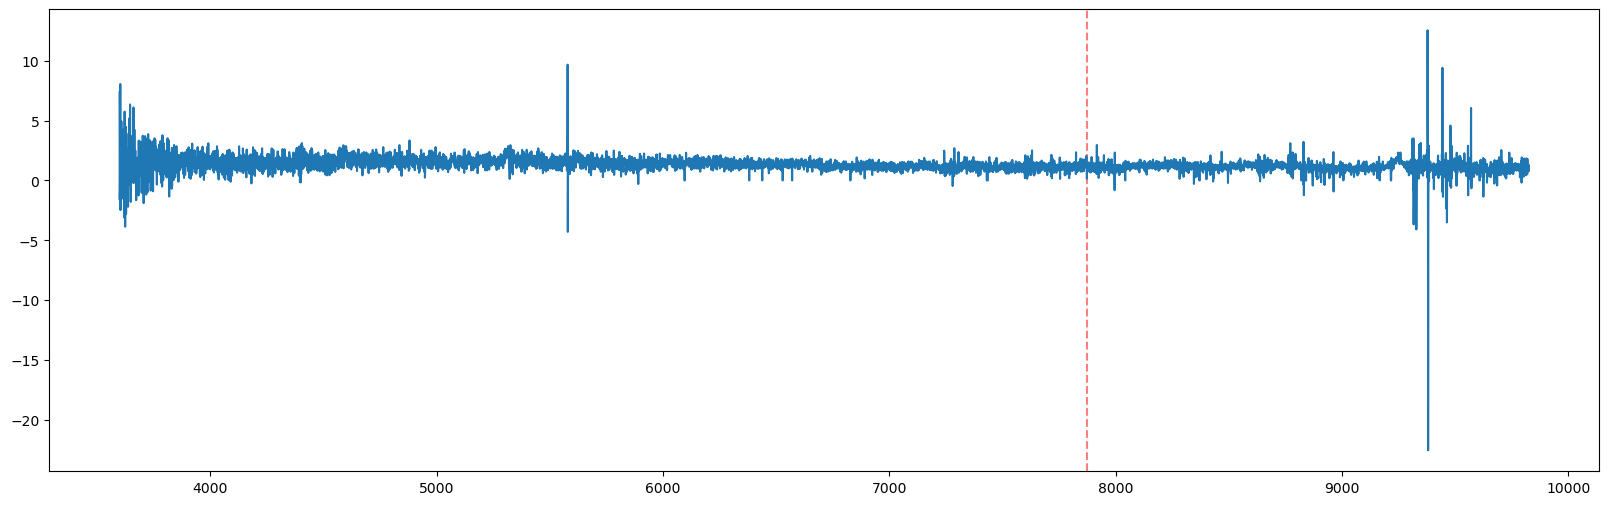


Example data:
TARGETID: 39627821722633017
Redshift: 2.0737715634235716
Fluxes: [ 5.44192505  0.58348501  4.3950491  ... -0.15586813  0.47503668
 -0.13389051]
ivar [ 0.15763077  0.18891889  0.15775403 ... 20.6079731  29.04761505
 31.75780296]
Labels: 1
LAE Redshift: 4.307419347124942
LAE NAME SPHINX_z5_haloid228457_dir_8
LAE intflux 1.037345788852654



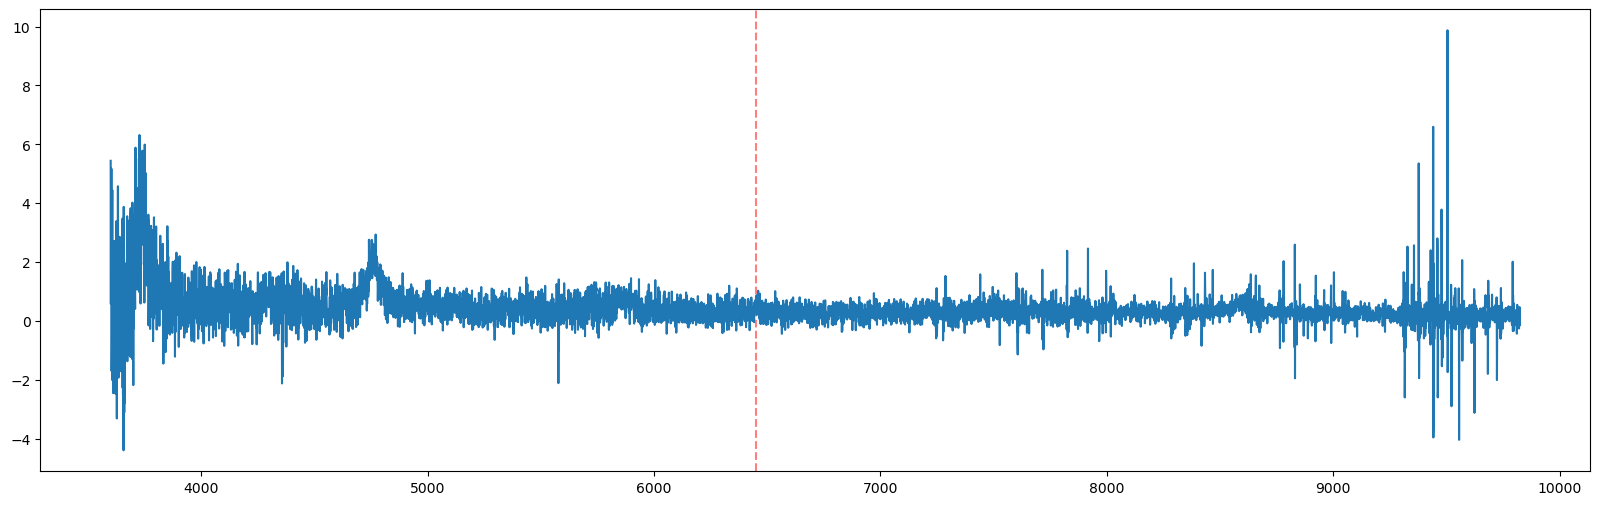


Example data:
TARGETID: 39627821726827225
Redshift: 1.2248183004736508
Fluxes: [ 2.6031189   1.59641111 -0.5670076  ...  0.12050786 -0.34659576
  0.42406195]
ivar [ 0.2185636   0.19522542  0.1884813  ... 12.98204231 17.2558651
 18.19664955]
Labels: 1
LAE Redshift: 3.684723576452882
LAE NAME ZoomSim_timestep122_direction98
LAE intflux 2.145049638269888



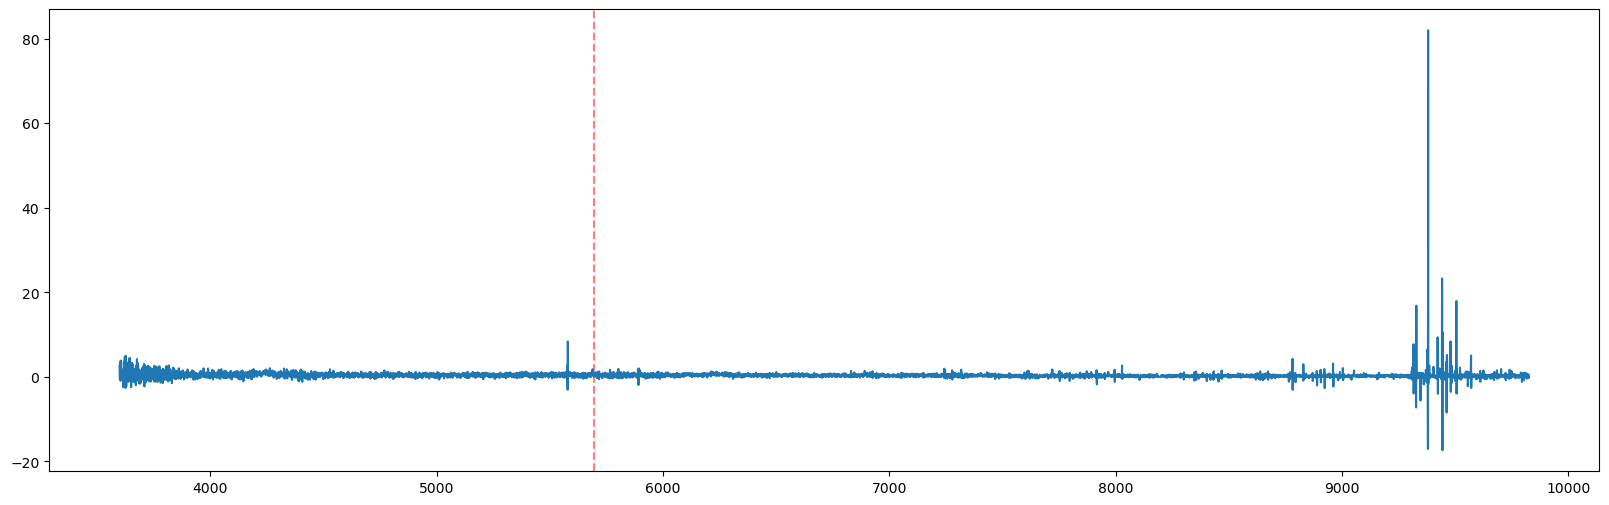


Example data:
TARGETID: 39627821731021778
Redshift: 0.7723454066261862
Fluxes: [ 0.39584735 -1.00110912  3.28581738 ...  0.56629175  1.09646297
  0.27051121]
ivar [ 0.130797    0.12007009  0.11638391 ... 11.30276585 14.70042801
 16.41867828]
Labels: 1
LAE Redshift: 2.297683246641488
LAE NAME ZoomSim_timestep103_direction271
LAE intflux 7.1251409878706005



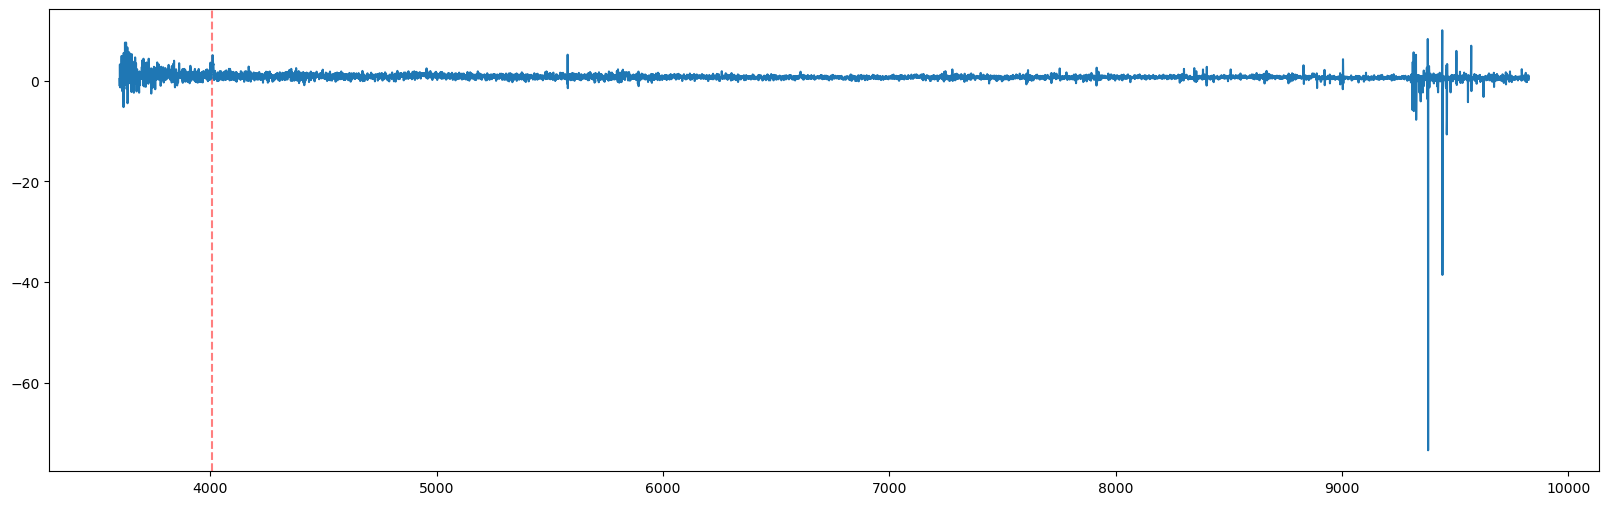


Example data:
TARGETID: 39627821731026076
Redshift: 2.081575558488354
Fluxes: [-1.54484403 -1.68383956  6.17092657 ...  0.05261575  0.06981806
  0.10997186]
ivar [ 0.20054451  0.22302075  0.21669067 ... 14.00616169 19.22499275
 39.37832642]
Labels: 1
LAE Redshift: 2.81746698903863
LAE NAME ZoomSim_timestep158_direction85
LAE intflux 1.4144277707404698



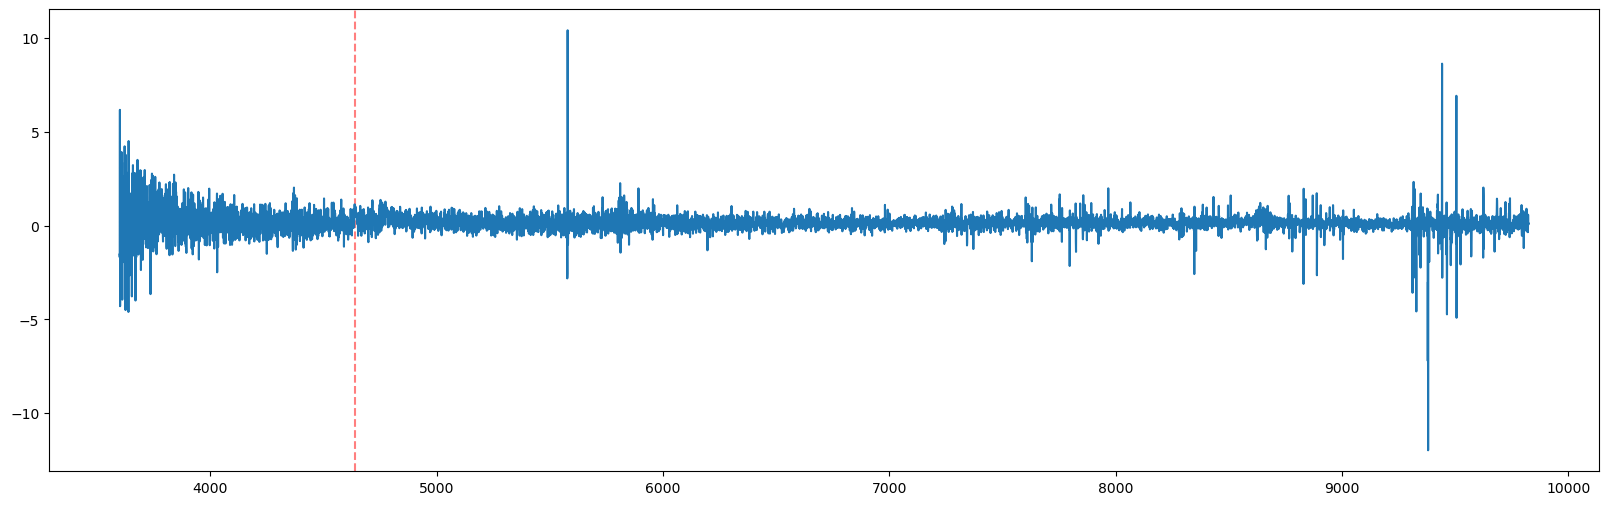


Example data:
TARGETID: 39627821735216084
Redshift: 1.6325226646285704
Fluxes: [ 0.20884678  1.96078014  0.07455544 ... -0.11131538  0.45146775
  0.07806579]
ivar [ 0.1131071   0.11509956  0.12379707 ... 11.09012699 14.03931618
 14.78359795]
Labels: 1
LAE Redshift: 3.180919050314976
LAE NAME ZoomSim_timestep103_direction133
LAE intflux 1.074783517065045



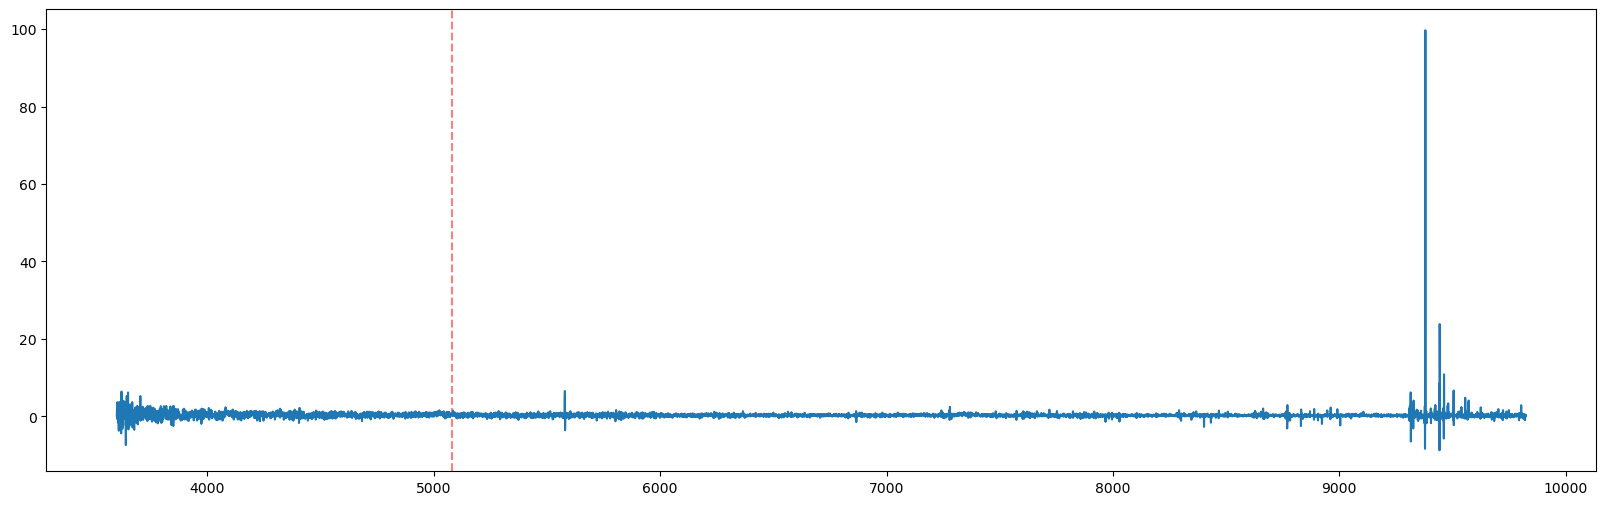


Example data:
TARGETID: 39627821735216818
Redshift: 2.8020472732269397
Fluxes: [-1.85141754 -4.71389008  5.72118187 ...  0.68678111  0.16336747
  0.46267062]
ivar [ 0.15925984  0.19868472  0.19843911 ... 12.50638294 17.20232201
 32.16519165]
Labels: 1
LAE Redshift: 4.622998246494584
LAE NAME SPHINX_z4_haloid84609_dir_5
LAE intflux 1.074316231974251



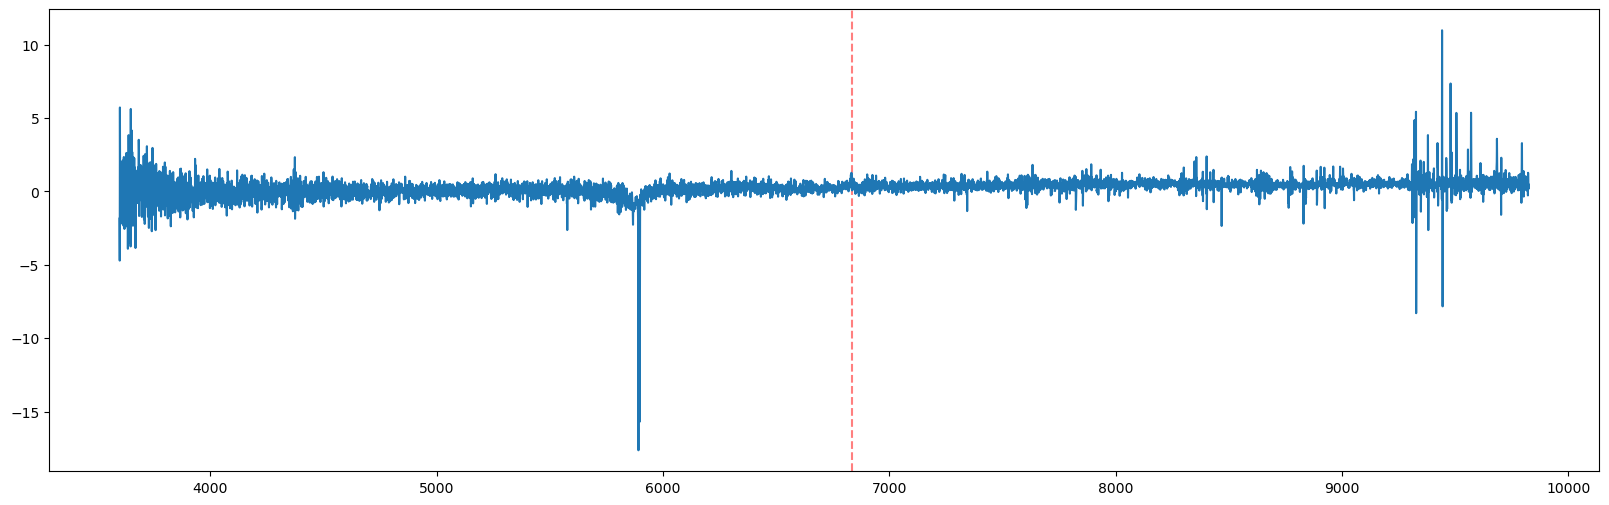


Example data:
TARGETID: 39627821743603857
Redshift: 1.7644293264240427
Fluxes: [ 0.59859651  1.04000211 -2.14141035 ...  0.33942264  0.24023518
  0.40178582]
ivar [ 0.2649256   0.25013876  0.2209799  ... 16.41827965 20.4997406
 30.23063278]
Labels: 1
LAE Redshift: 3.6366795534535177
LAE NAME ZoomSim_timestep96_direction45
LAE intflux 1.5882507468761302



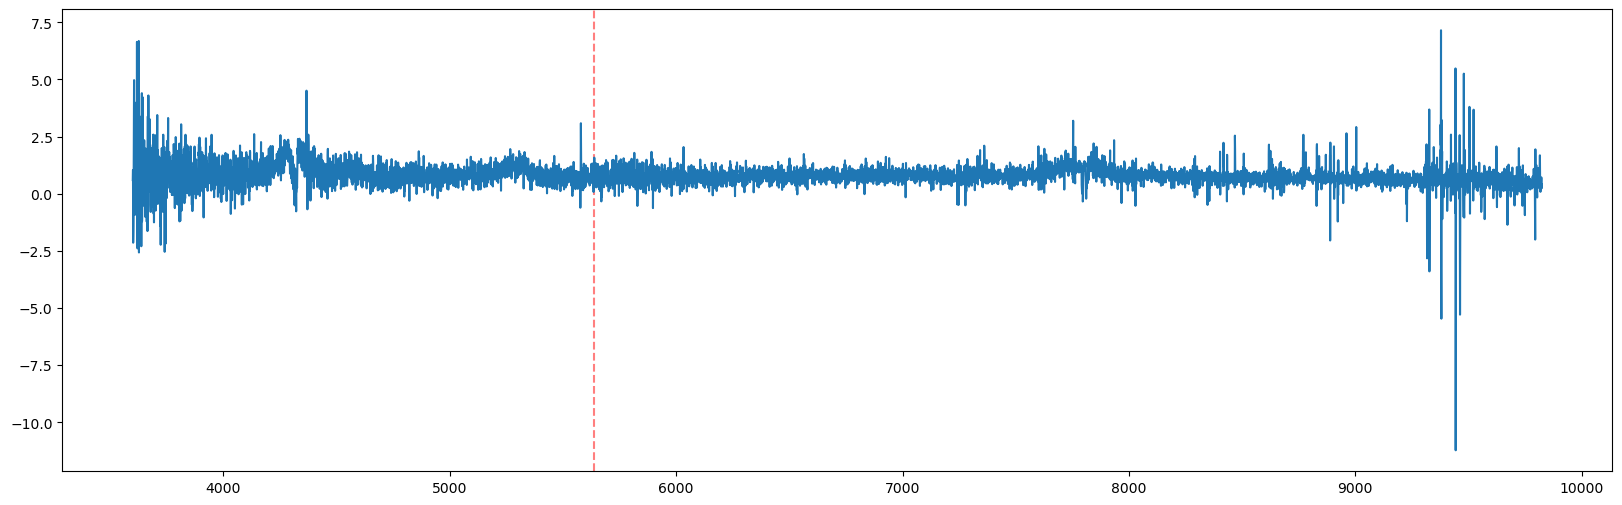


Example data:
TARGETID: 39627821743604623
Redshift: 1.8722460203838551
Fluxes: [-0.86368853 -0.64138216  7.77629566 ...  1.06390703  1.41884172
  1.01363325]
ivar [ 0.10138378  0.08149805  0.09324407 ... 17.53968239 20.53998184
 23.06855774]
Labels: 1
LAE Redshift: 5.83420507366274
LAE NAME SPHINX_z5_haloid206805_dir_7
LAE intflux 1.340799710208925



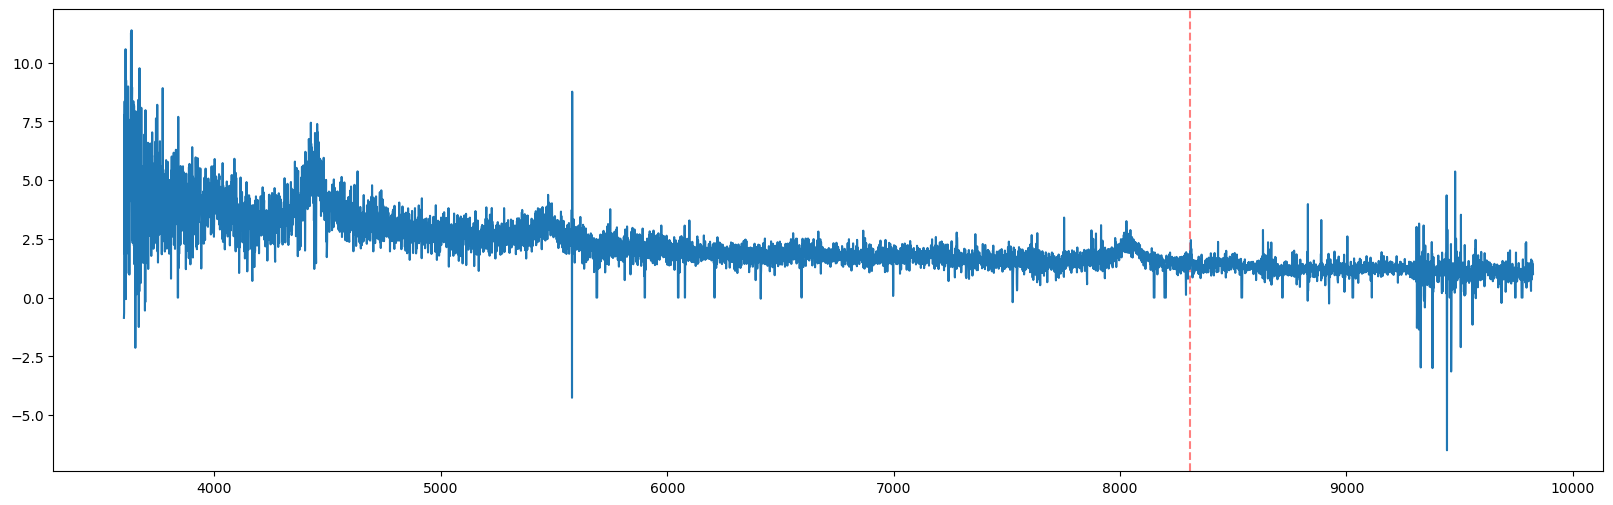


Example data:
TARGETID: 39627821743608449
Redshift: 1.462720190325481
Fluxes: [1.72191906 1.57196295 2.22619653 ... 0.97022074 0.69087029 0.74771267]
ivar [ 0.30537805  0.27381888  0.27597877 ... 17.56967926 22.67155647
 35.87237167]
Labels: 1
LAE Redshift: 4.225916117678798
LAE NAME SPHINX_z4_haloid96325_dir_5
LAE intflux 1.9799884861150665



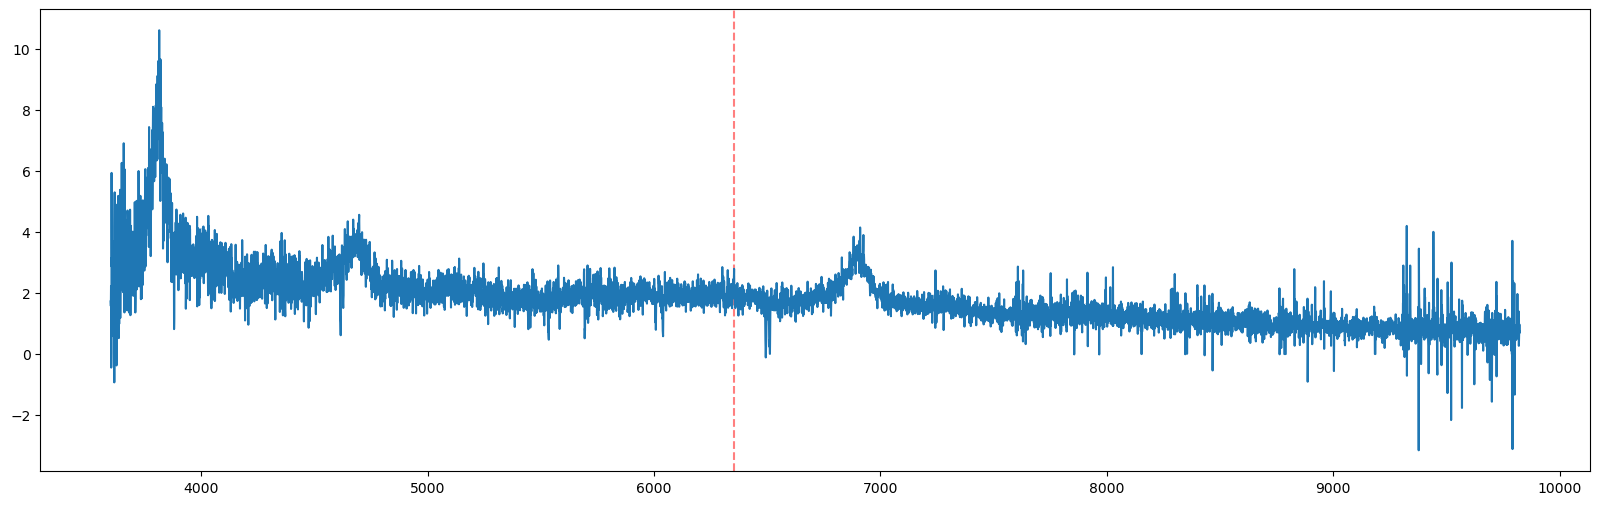


Example data:
TARGETID: 39627821747798405
Redshift: 1.729396601677511
Fluxes: [0.24659863 3.53633761 6.20819712 ... 1.34981847 1.24578774 1.71745431]
ivar [ 0.12449105  0.09851357  0.09309252 ... 17.63454819 22.22068405
 22.43116951]
Labels: 1
LAE Redshift: 5.406079218314159
LAE NAME SPHINX_z6_haloid186534_dir_1
LAE intflux 1.491002873519112



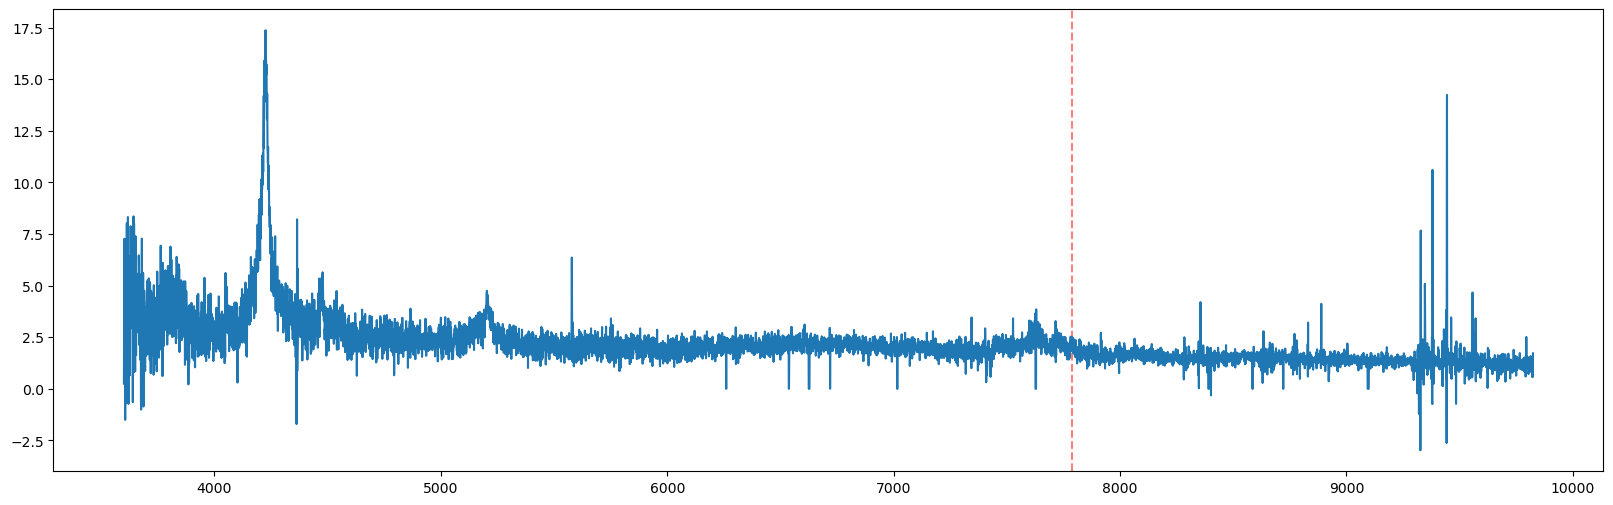


Example data:
TARGETID: 39627827724687705
Redshift: 1.2104755917458585
Fluxes: [-1.37076545  2.93385553 -2.92346478 ...  0.03045905 -0.41175568
  0.62740266]
ivar [ 0.11262818  0.08850088  0.10910343 ... 15.23554516 18.02141953
 24.21590042]
Labels: 1
LAE Redshift: 2.6589411933609326
LAE NAME ZoomSim_timestep103_direction92
LAE intflux 1.0871362678980228



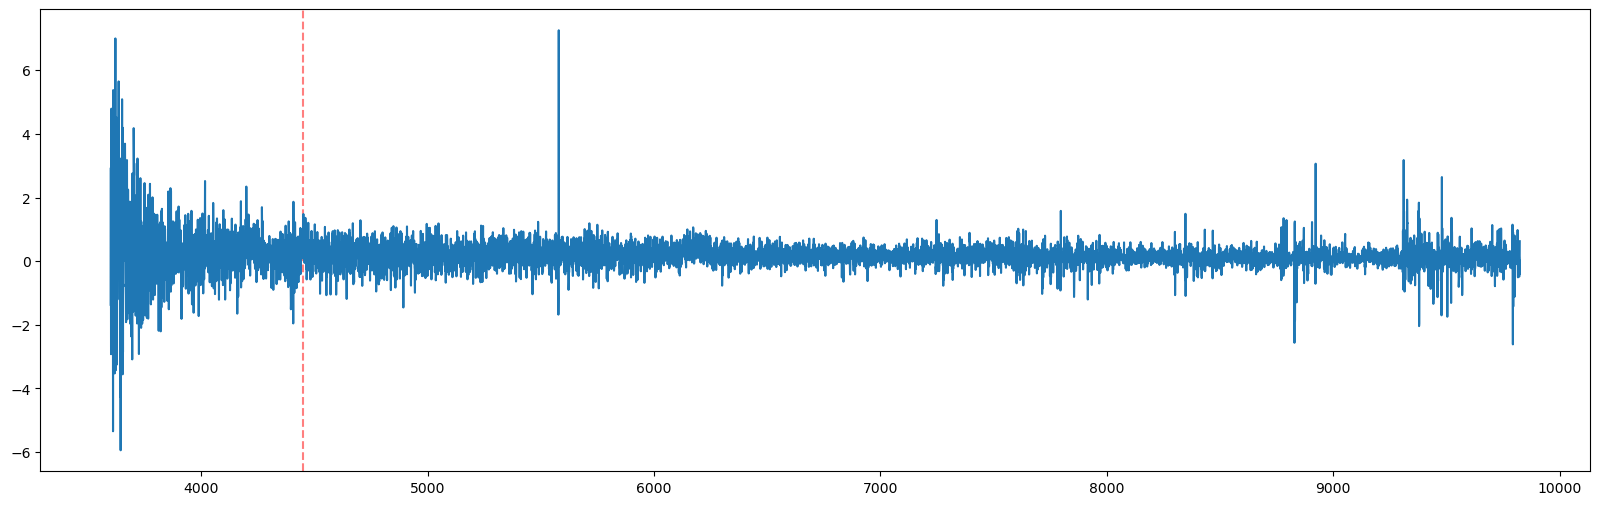


Example data:
TARGETID: 39627827724688458
Redshift: 2.7756753471290065
Fluxes: [5.19458294 4.34776306 0.88304865 ... 1.63614309 1.0895865  1.11873579]
ivar [ 0.30917254  0.2748563   0.35387686 ... 11.37625217 15.11109829
 16.02311516]
Labels: 1
LAE Redshift: 4.0350476176273204
LAE NAME ZoomSim_timestep131_direction7
LAE intflux 3.957306481910662



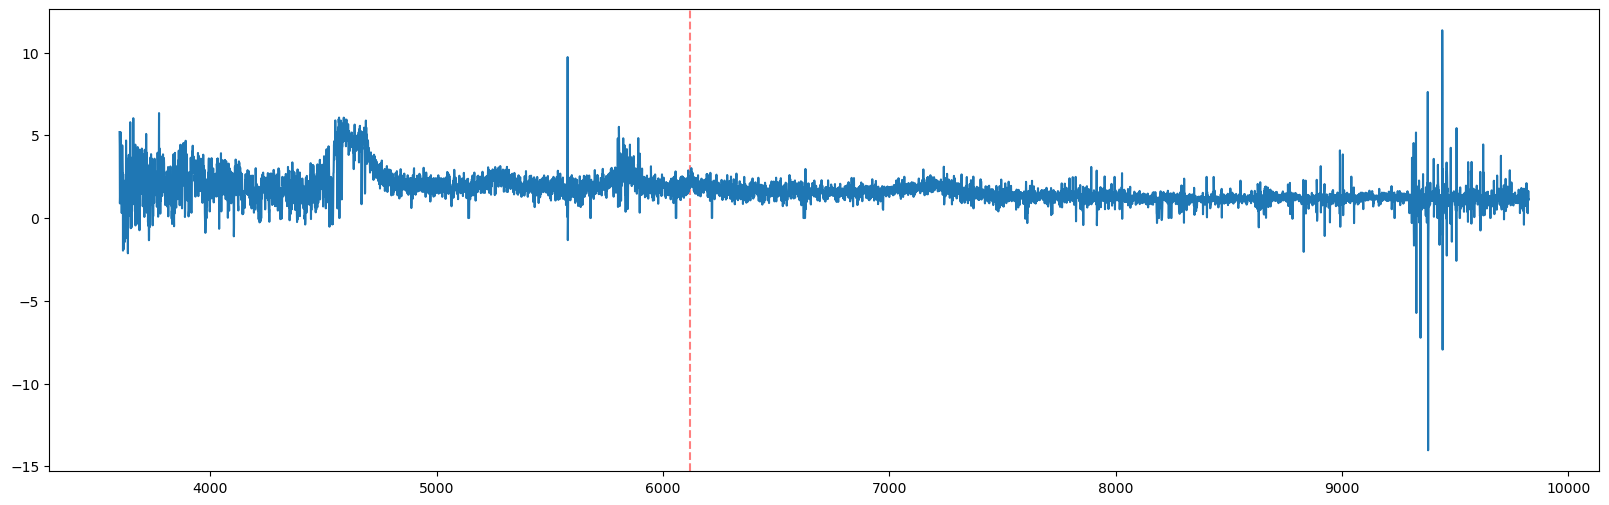


Example data:
TARGETID: 39627827728882466
Redshift: 2.544092756837901
Fluxes: [3.32920933 3.67207551 3.57942915 ... 3.28912163 3.12448573 3.07237744]
ivar [ 0.06038144  0.05819774  0.0700234  ...  9.42334557  9.98120594
 11.41585064]
Labels: 1
LAE Redshift: 4.964600871022507
LAE NAME SPHINX_z4_haloid193795_dir_4
LAE intflux 1.0708034075241941



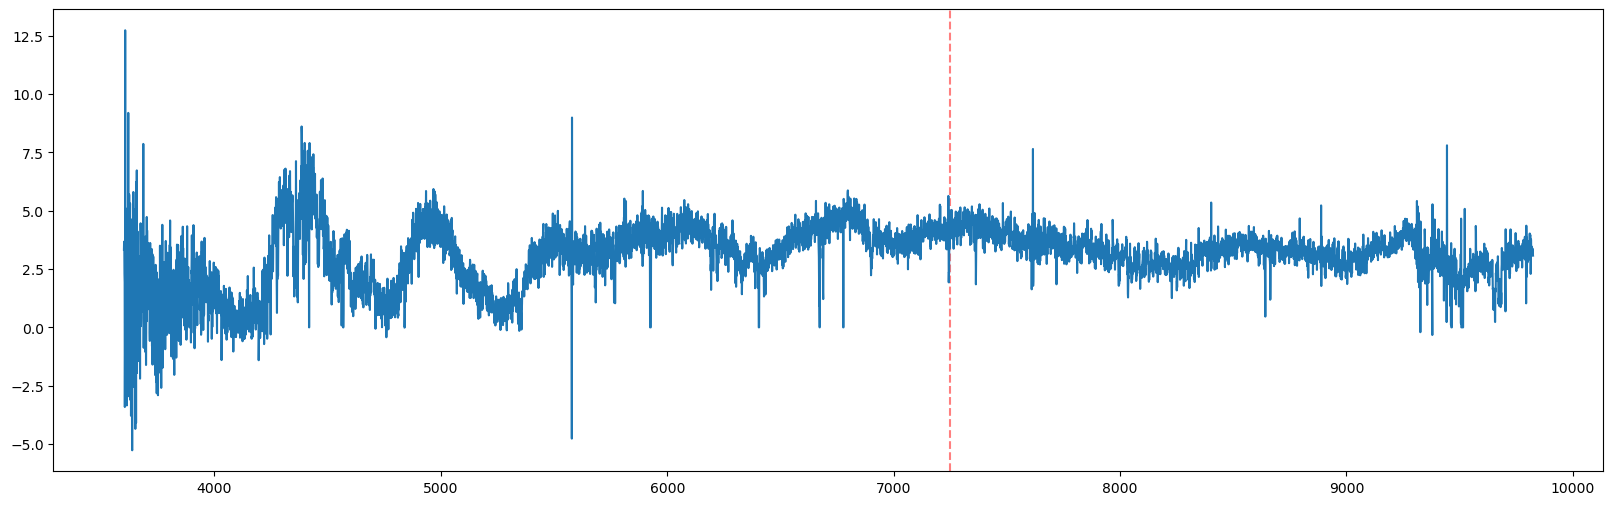


Example data:
TARGETID: 39627827737265540
Redshift: 2.338185973511783
Fluxes: [-1.30424392 -1.10482478  0.33591571 ...  0.7099179   0.15328835
  0.46943548]
ivar [ 0.5466882   0.50666595  0.57963508 ... 26.50695038 33.17060852
 44.120327  ]
Labels: 1
LAE Redshift: 4.427151501910661
LAE NAME SPHINX_z4_haloid124037_dir_9
LAE intflux 1.0171211566107994



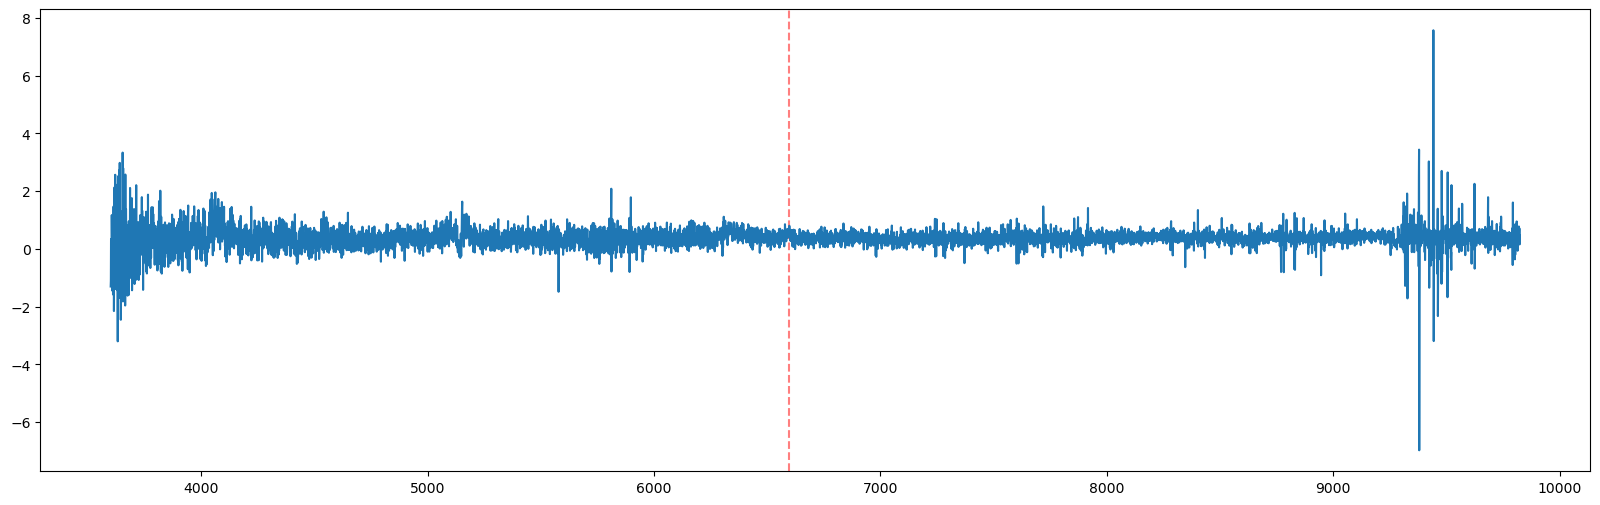


Example data:
TARGETID: 39627827737266699
Redshift: 1.6477329778540541
Fluxes: [0.06377243 0.0151406  1.29917932 ... 0.51430148 0.12030802 0.56025964]
ivar [ 0.18205619  0.10777543  0.12922466 ... 12.29924965 16.85564041
 19.04087448]
Labels: 1
LAE Redshift: 2.9503922532642477
LAE NAME ZoomSim_timestep120_direction133
LAE intflux 2.0217122644775922



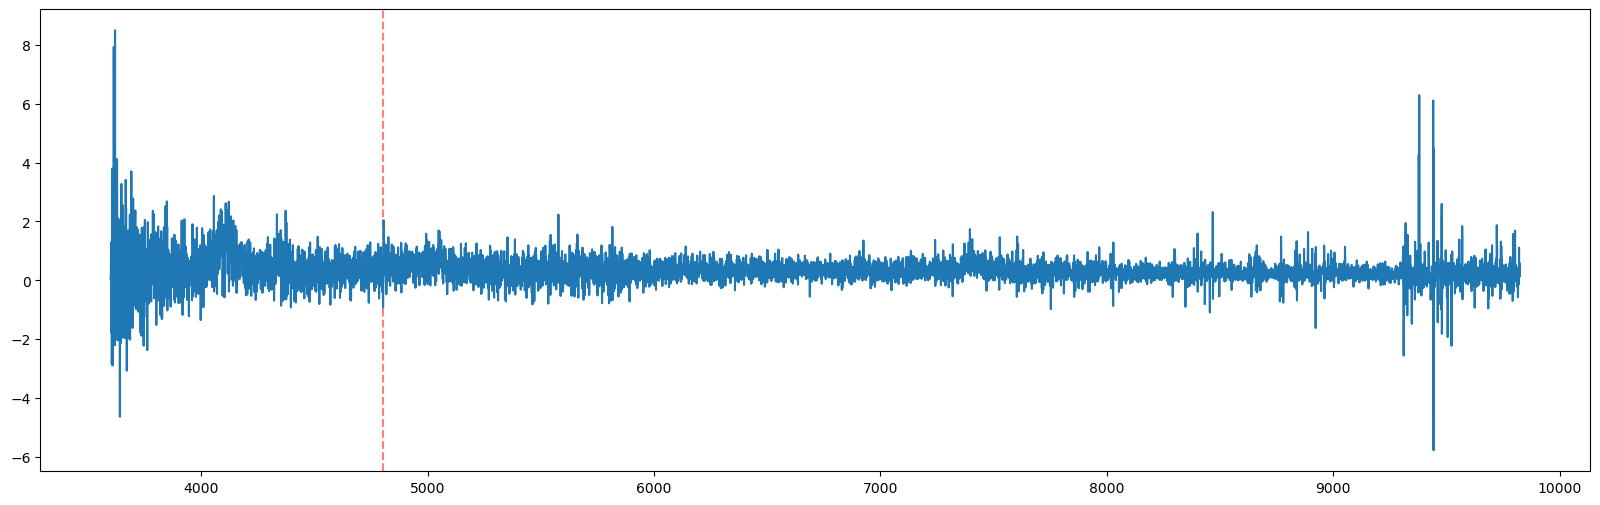


Example data:
TARGETID: 39627827737270190
Redshift: 1.1063730370972482
Fluxes: [4.83948946 3.56331277 4.28183508 ... 0.89995271 0.38890693 0.76891065]
ivar [ 0.07442637  0.05391511  0.07403179 ... 11.90958214 14.91131115
 18.91922951]
Labels: 1
LAE Redshift: 3.155320278848645
LAE NAME ZoomSim_timestep127_direction284
LAE intflux 1.0074476981612062



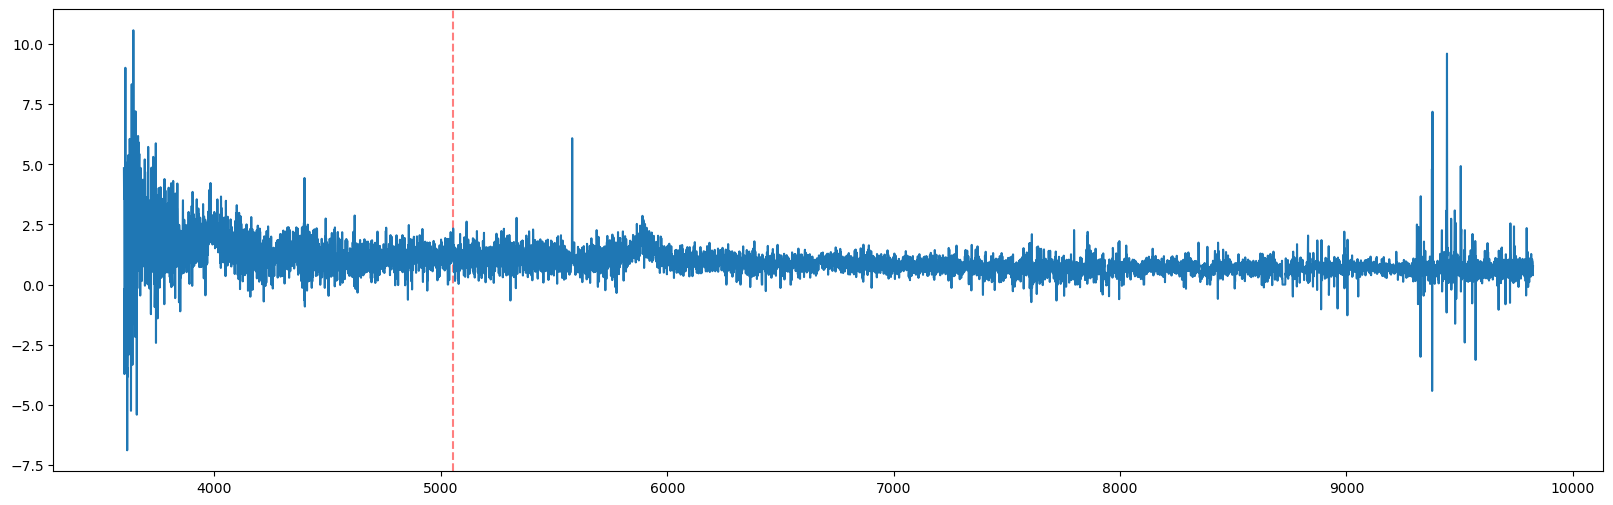


Example data:
TARGETID: 39627827741461549
Redshift: 1.61676216743646
Fluxes: [ 4.59013796  5.25081921  1.92440832 ... -0.24207567 -0.31182608
  0.35185862]
ivar [ 0.08171821  0.06177331  0.10426094 ... 12.14106369 16.21932411
 18.44659424]
Labels: 1
LAE Redshift: 2.884532070873677
LAE NAME ZoomSim_timestep131_direction21
LAE intflux 5.238998000635621



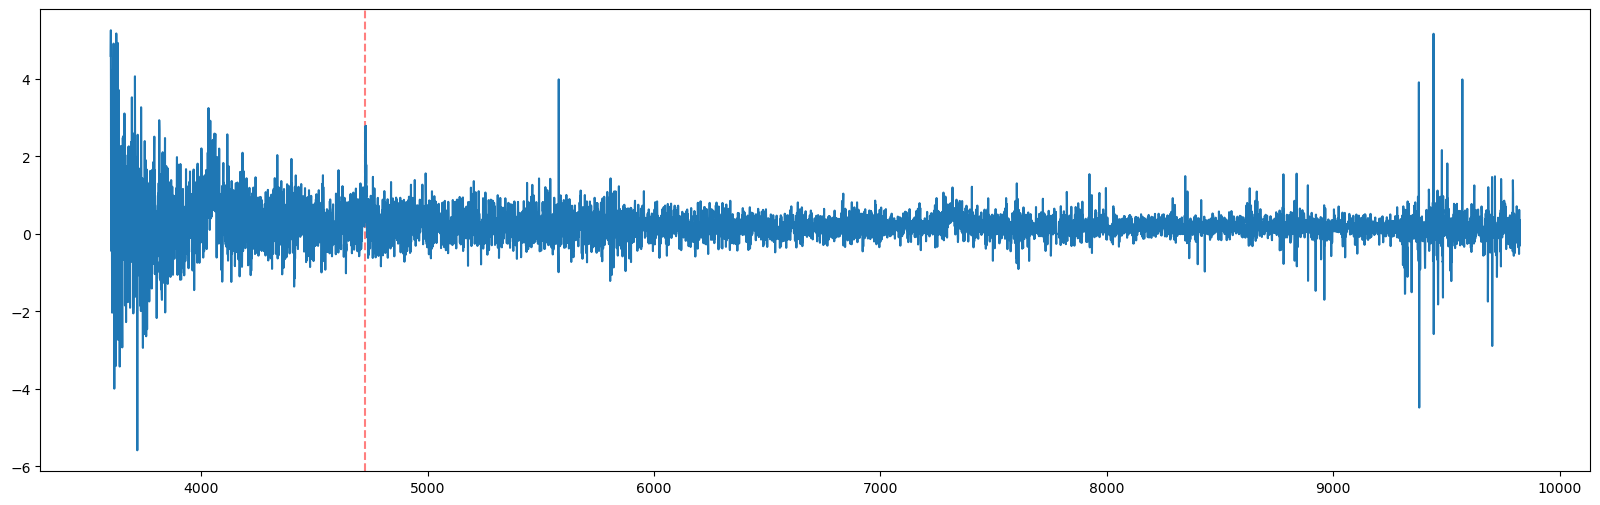


Example data:
TARGETID: 39627827741461553
Redshift: 2.6720093659190307
Fluxes: [4.02889299 6.60474014 6.02379131 ... 1.10485327 0.68333942 0.77269673]
ivar [ 0.08242136  0.06956329  0.12570165 ... 10.46786499 14.3301096
 19.87890053]
Labels: 1
LAE Redshift: 4.886673710060977
LAE NAME SPHINX_z5_haloid257242_dir_8
LAE intflux 1.4536038389864612



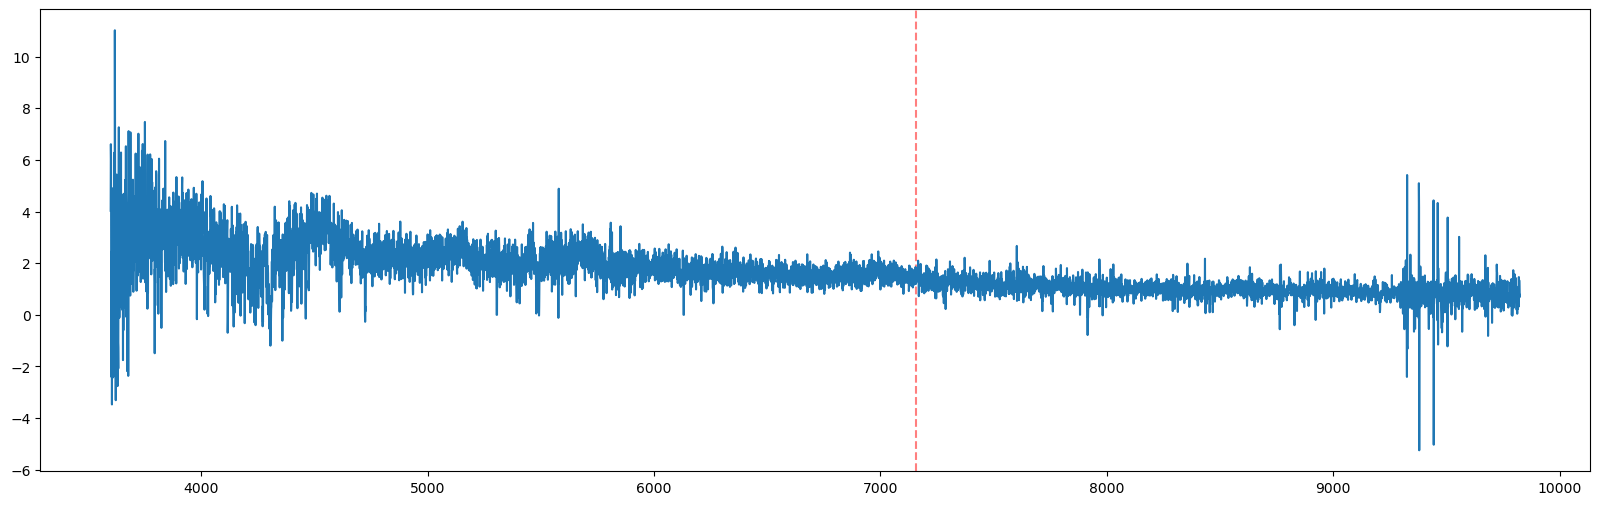


Example data:
TARGETID: 39627827741464689
Redshift: 1.3451521879454917
Fluxes: [ 4.93610954 -1.71589947  4.67621183 ...  0.16938251  0.75407523
  0.08841167]
ivar [ 0.12425565  0.08315875  0.15667315 ... 10.35168934 13.72345352
 14.57045555]
Labels: 1
LAE Redshift: 4.968555711941365
LAE NAME SPHINX_z4_haloid137486_dir_5
LAE intflux 1.376665571681199



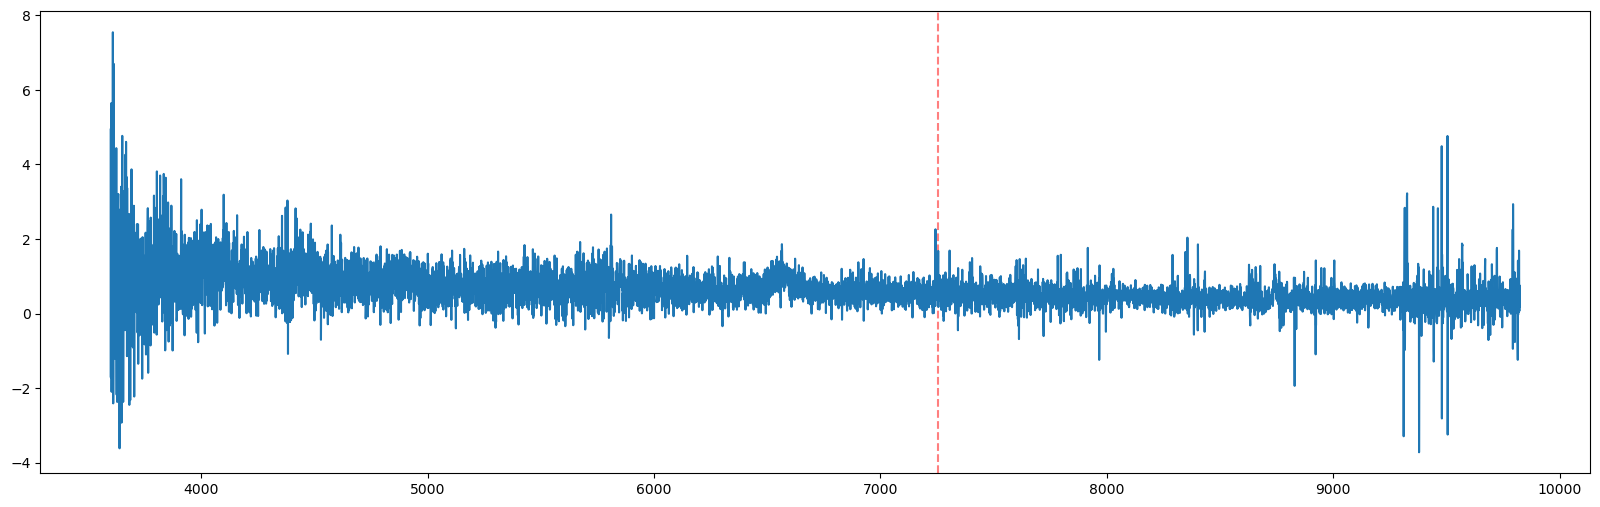


Example data:
TARGETID: 39627827745653792
Redshift: 2.9152524939154545
Fluxes: [-0.57276422  0.88871938 -0.92341483 ...  0.36817977  0.39321259
  0.63090932]
ivar [ 0.4000423   0.36312729  0.41387749 ... 55.56691742 82.9400177
 96.9519577 ]
Labels: 1
LAE Redshift: 3.9041739427505764
LAE NAME ZoomSim_timestep159_direction165
LAE intflux 1.4811530512565796



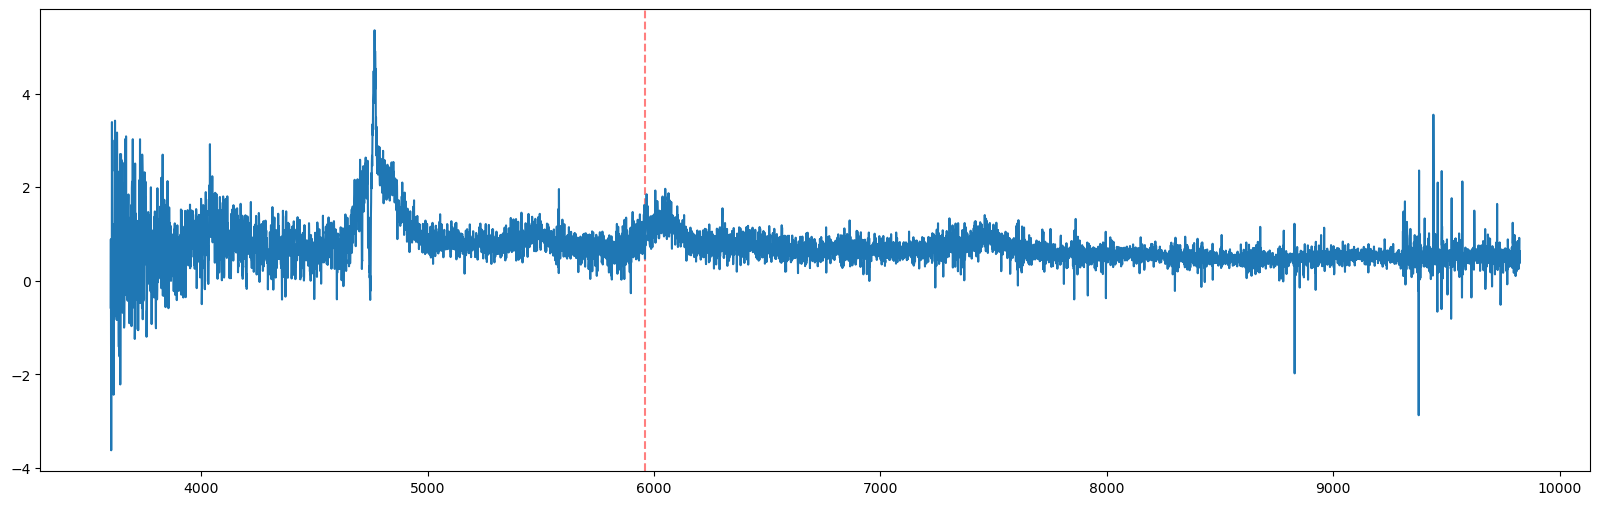


Example data:
TARGETID: 39627827749847205
Redshift: 1.798714069812579
Fluxes: [14.30138874 12.98253727 12.13378048 ...  2.99888921  3.05910325
  3.43267512]
ivar [ 0.18490639  0.12278666  0.11409071 ... 27.00995445 28.68767166
 29.09538078]
Labels: 1
LAE Redshift: 3.0814810760067255
LAE NAME ZoomSim_timestep126_direction70
LAE intflux 1.7816361537538168



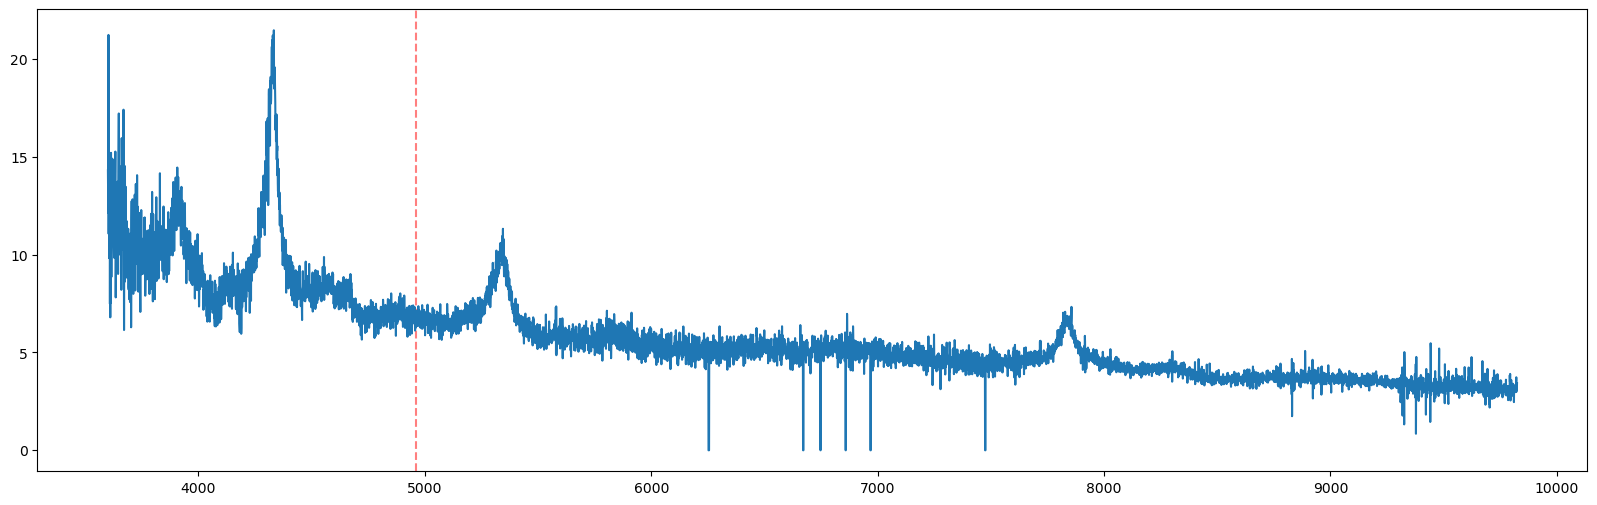


Example data:
TARGETID: 39627827754048083
Redshift: 1.0760548604774622
Fluxes: [ 1.87451792  2.83909941 -2.75387669 ...  0.30227435 -0.13495062
  0.06516185]
ivar [ 0.09401507  0.09608239  0.09609279 ... 12.21594715 14.36461163
 15.87799072]
Labels: 1
LAE Redshift: 2.2894148270591117
LAE NAME ZoomSim_timestep119_direction255
LAE intflux 4.553289406967126



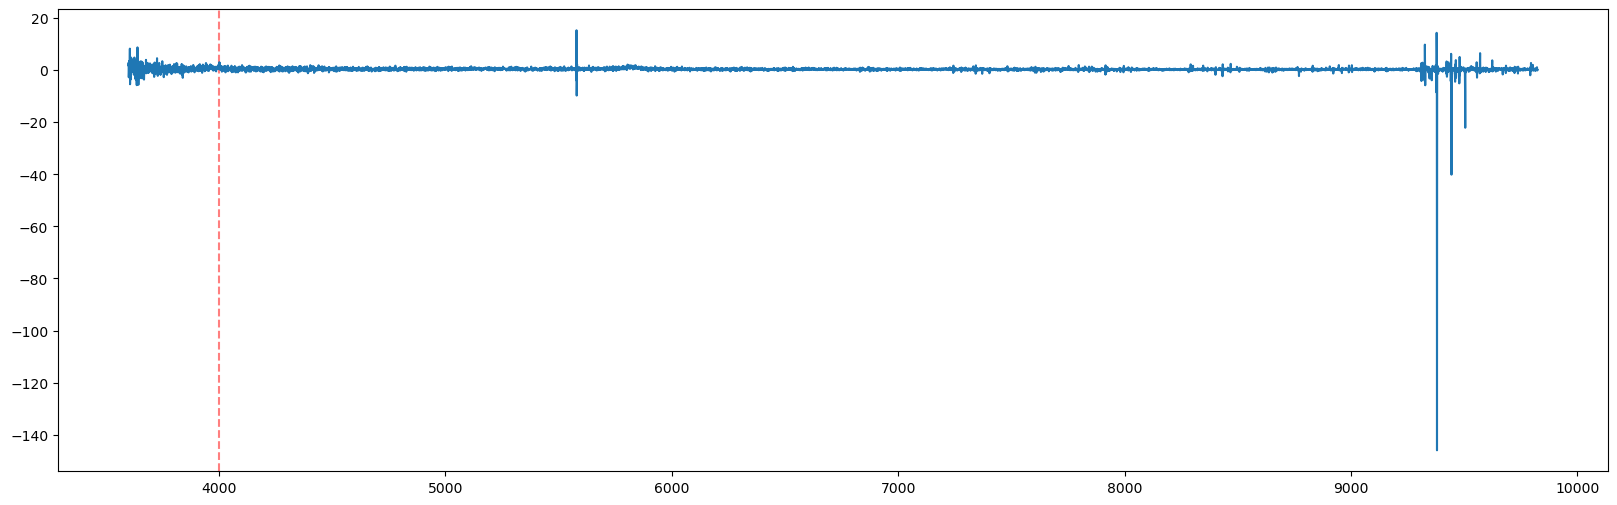


Example data:
TARGETID: 39627827758236227
Redshift: 0.8477500393632124
Fluxes: [4.83483982 0.19973591 2.88484478 ... 0.27418151 0.73628861 0.59717548]
ivar [ 0.23961687  0.24593832  0.21693698 ... 19.31177139 25.24905586
 31.26425552]
Labels: 1
LAE Redshift: 3.253560538628154
LAE NAME ZoomSim_timestep100_direction169
LAE intflux 1.1929741484424794



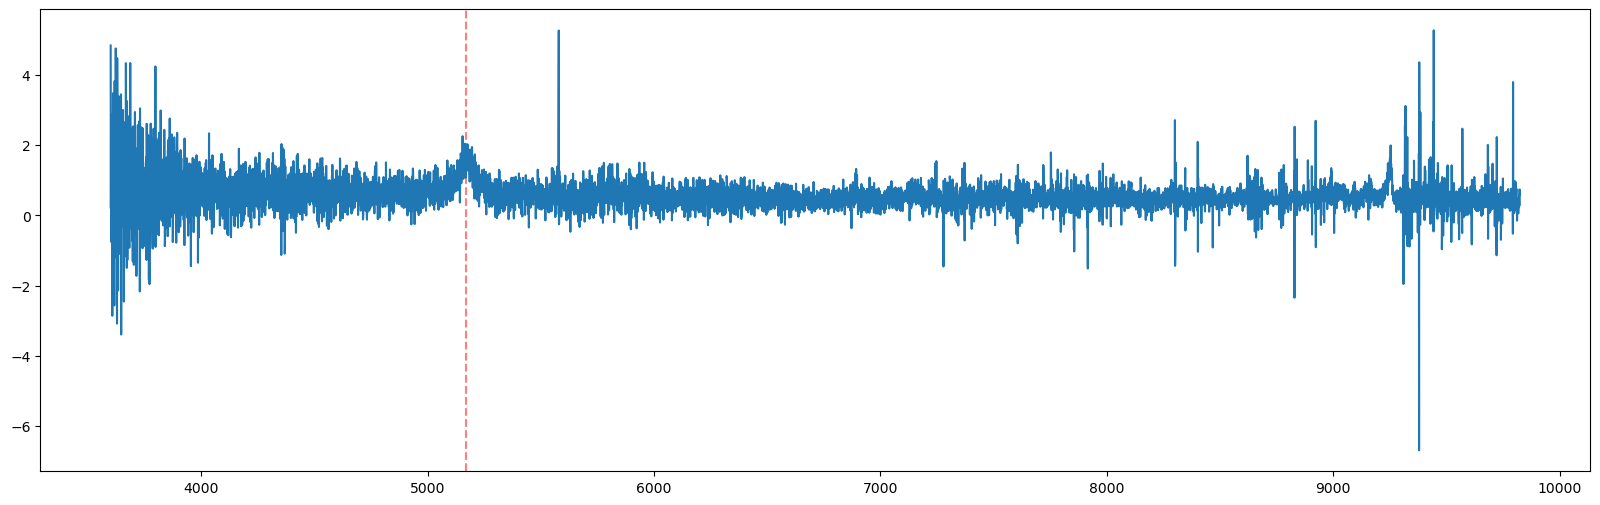


Example data:
TARGETID: 39627827758238469
Redshift: 1.5551656492483927
Fluxes: [ 4.93334341 -0.37898377  2.74837899 ...  0.78814912  0.51362664
  0.92556804]
ivar [ 0.11848322  0.10739643  0.11187136 ... 10.9161005  14.45456314
 18.11208153]
Labels: 1
LAE Redshift: 4.15275813479471
LAE NAME ZoomSim_timestep153_direction96
LAE intflux 1.022013679092832



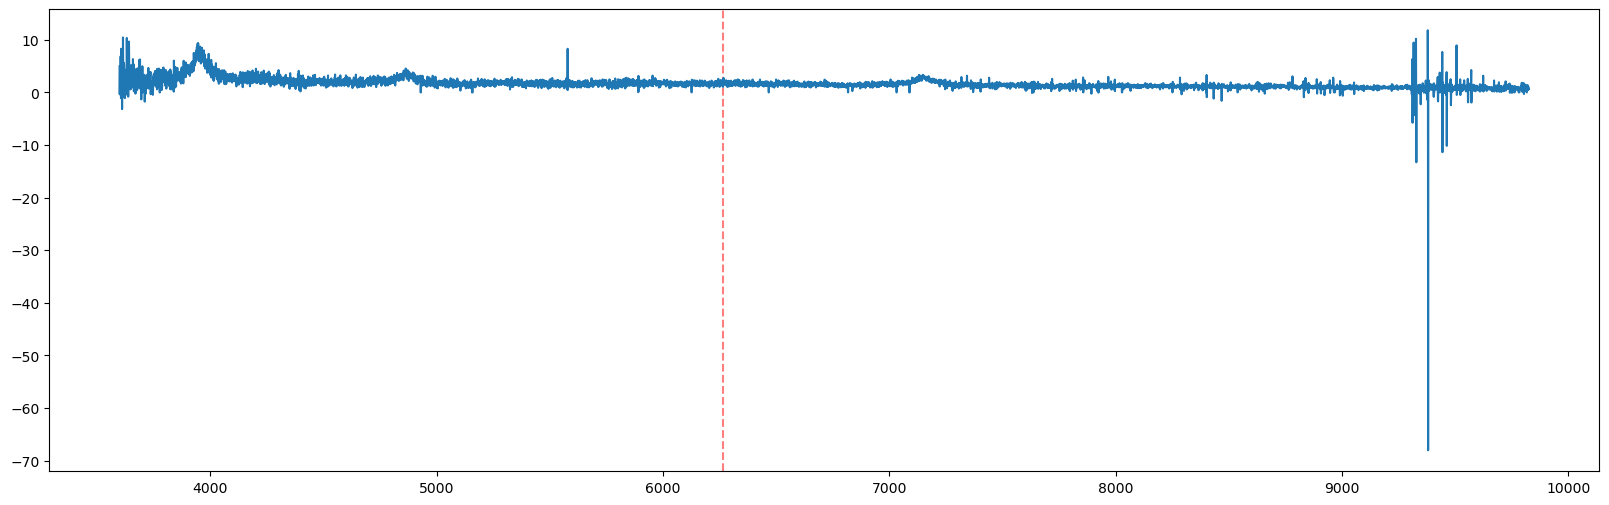


Example data:
TARGETID: 39627827758239143
Redshift: 1.4482730697402475
Fluxes: [ 1.78767765  4.66627216 -3.89114451 ...  0.42586625  0.61291552
  0.51006347]
ivar [ 0.22496569  0.23791605  0.19968934 ... 18.9033947  24.67546844
 26.4039402 ]
Labels: 1
LAE Redshift: 2.368427875414162
LAE NAME ZoomSim_timestep102_direction42
LAE intflux 1.0211687755971064



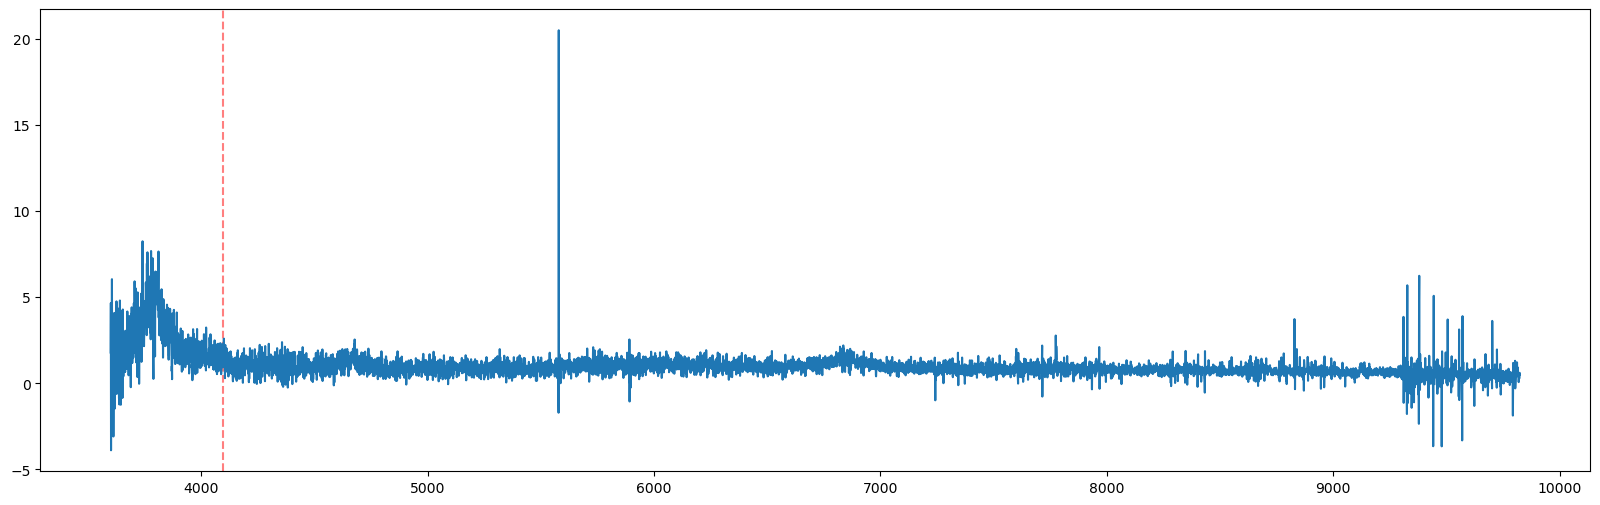


Example data:
TARGETID: 39627827758240582
Redshift: 2.7972650123199467
Fluxes: [ 4.52102137  0.70202672 -1.26891625 ... -0.09505127 -0.16486877
  0.13652106]
ivar [ 0.24742761  0.2078851   0.26335797 ... 47.58605957 79.63806152
 94.70471191]
Labels: 1
LAE Redshift: 5.330999250550796
LAE NAME SPHINX_z4_haloid27649_dir_3
LAE intflux 2.0335695606623547



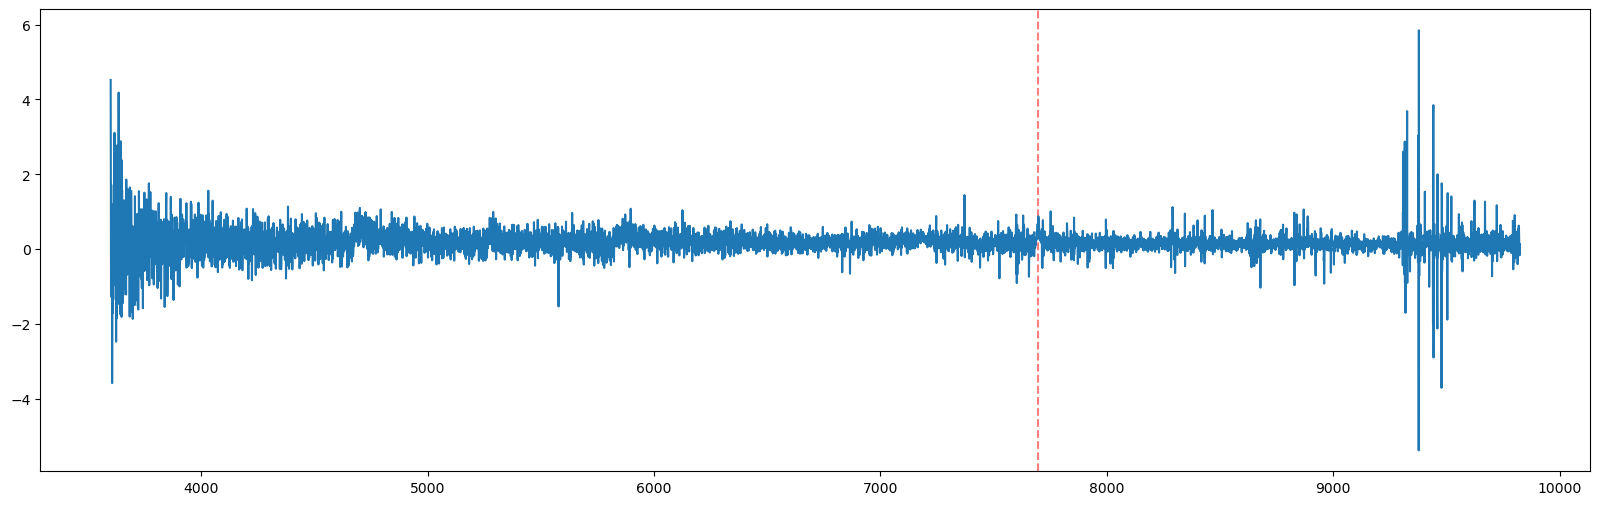


Example data:
TARGETID: 39627827766629916
Redshift: 2.385749198582602
Fluxes: [1.66976094 5.17495775 3.24502754 ... 1.16069436 1.09751952 1.01630998]
ivar [ 0.29839492  0.28167701  0.30404356 ... 31.62047958 39.1246109
 47.25457764]
Labels: 1
LAE Redshift: 5.8370587950622035
LAE NAME SPHINX_z4_haloid170103_dir_9
LAE intflux 1.3286622879700758



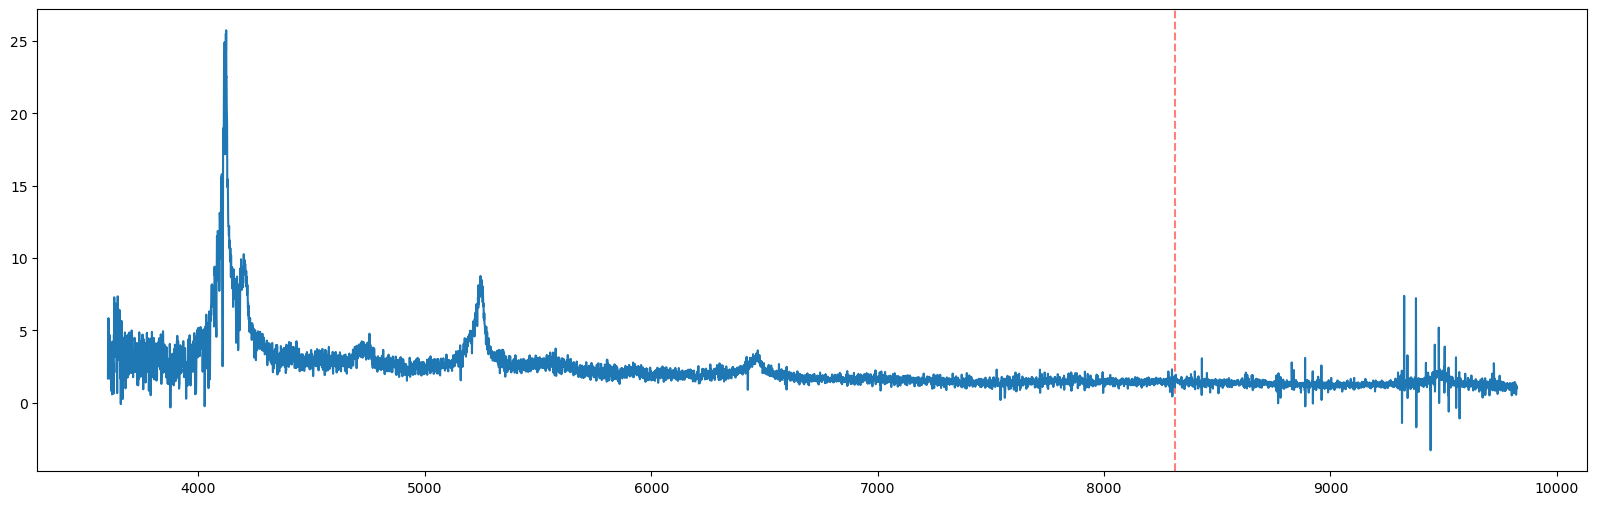


Example data:
TARGETID: 39627827770821426
Redshift: 1.7975207317378357
Fluxes: [-0.79625547 -2.55211043  0.65431011 ...  0.44810399 -0.00296682
 -0.13931052]
ivar [ 0.15965968  0.21783796  0.21836512 ... 15.44425201 20.90498352
 37.50954056]
Labels: 1
LAE Redshift: 2.608804303536161
LAE NAME ZoomSim_timestep102_direction102
LAE intflux 4.34972617502789



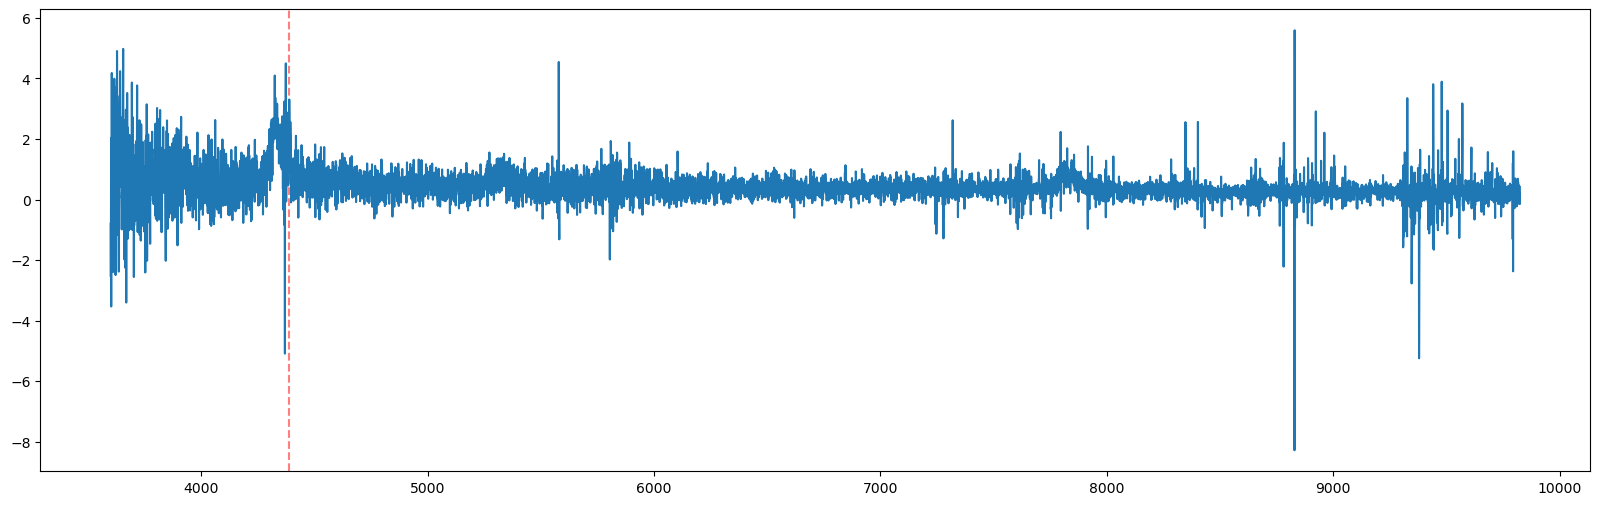


Example data:
TARGETID: 39627827775017725
Redshift: 1.9197659499312343
Fluxes: [6.38171911 1.30550539 1.0565201  ... 0.03115519 0.18463948 0.21992166]
ivar [ 0.09800964  0.1410189   0.12262875 ... 13.99034214 17.2781868
 28.43428802]
Labels: 1
LAE Redshift: 5.486752014065694
LAE NAME SPHINX_z5_haloid148728_dir_2
LAE intflux 1.962970327382121



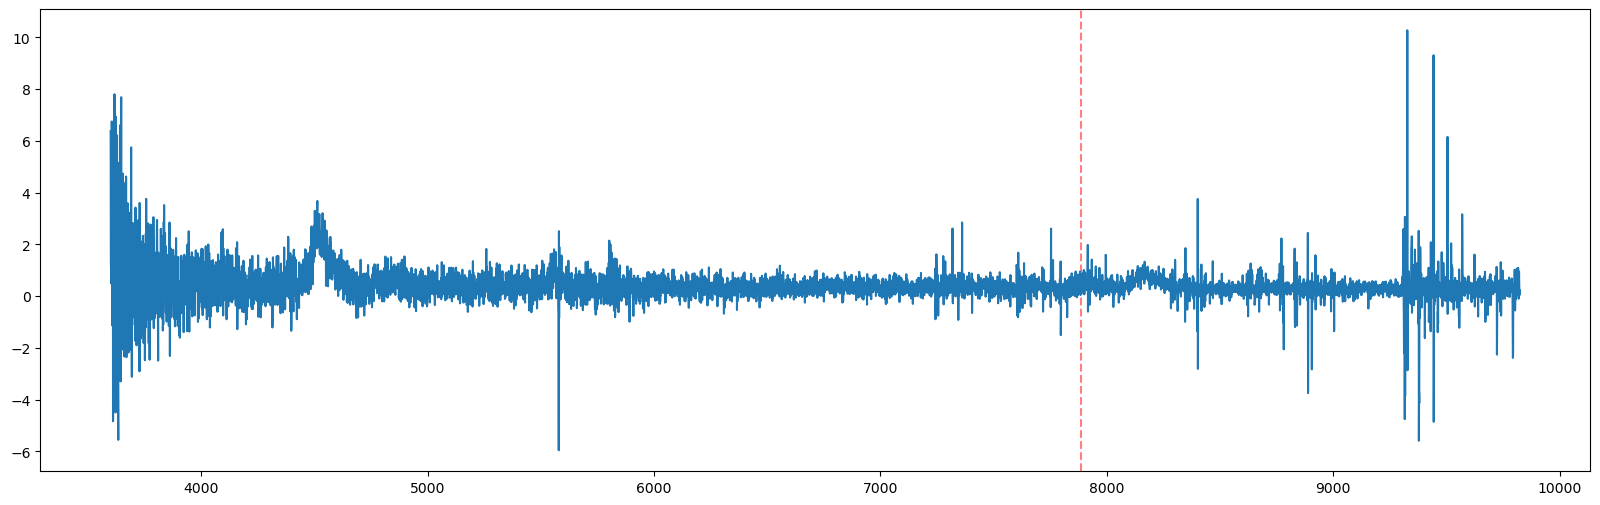


Example data:
TARGETID: 39627827783404681
Redshift: 0.19814654835015244
Fluxes: [0.95070511 0.77332735 0.89358872 ... 3.24114656 3.84896779 3.89467359]
ivar [ 0.09605242  0.0813605   0.09378971 ... 12.37209702 13.20301247
 13.8159132 ]
Labels: 1
LAE Redshift: 4.100967010516982
LAE NAME ZoomSim_timestep151_direction174
LAE intflux 2.7666287215581296



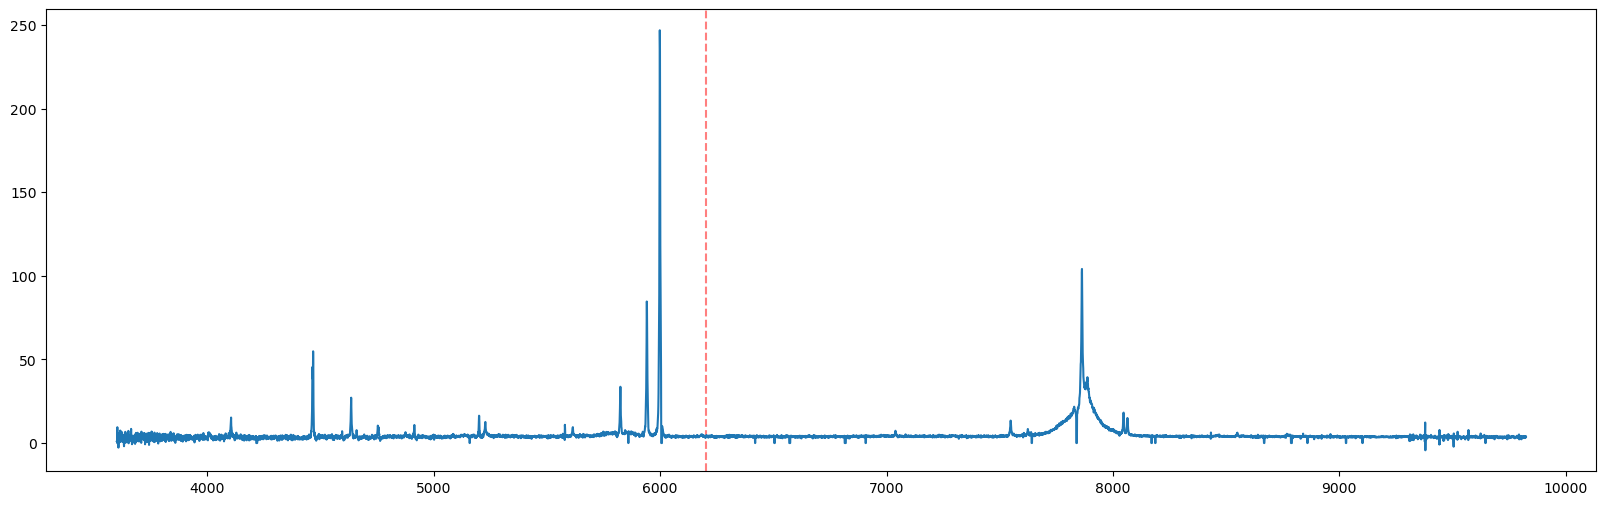


Example data:
TARGETID: 39627827783406125
Redshift: 1.227722009273372
Fluxes: [12.97830677 14.90978909 13.23764706 ...  2.7814393   1.98590255
  0.        ]
ivar [ 0.11207597  0.08432566  0.09091918 ... 11.43187237 10.46404076
  0.        ]
Labels: 1
LAE Redshift: 4.435262388899491
LAE NAME SPHINX_z6_haloid234666_dir_6
LAE intflux 2.029418080606628



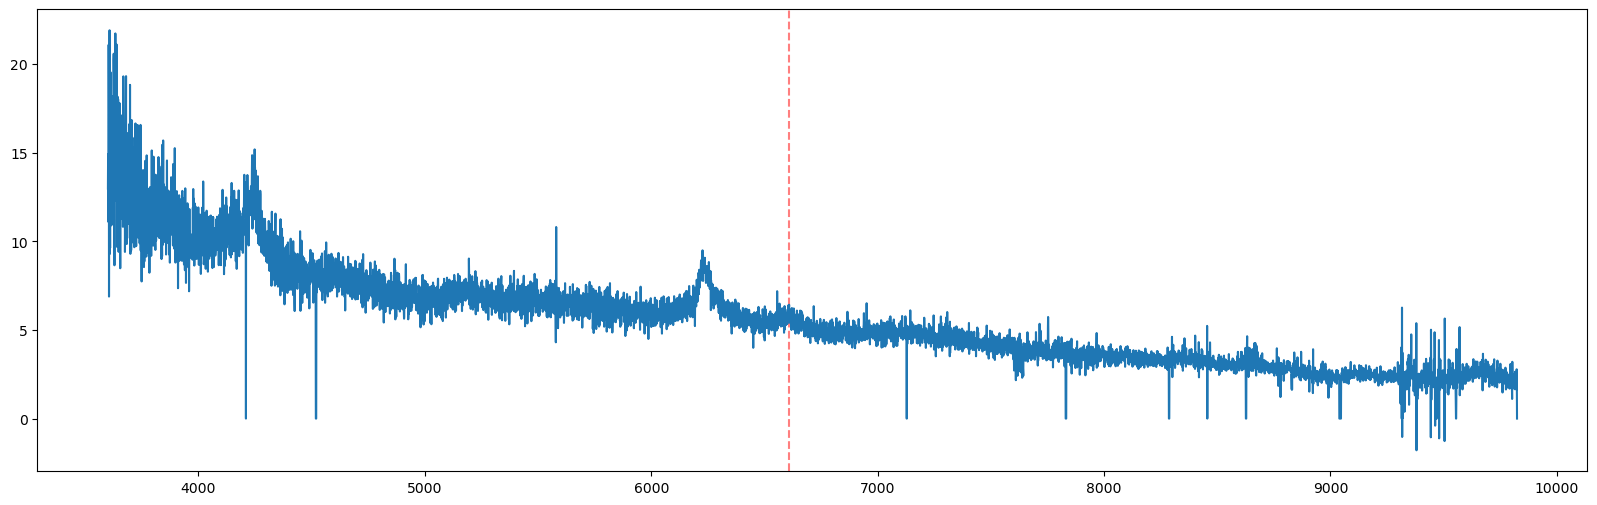


Example data:
TARGETID: 39627827787598623
Redshift: 1.869927989172631
Fluxes: [-1.56658757 -5.19377661 -0.20586863 ...  0.35268697  0.56781065
  0.1424391 ]
ivar [ 0.14800425  0.14655942  0.13113664 ... 10.72821999 17.09199333
 32.08868408]
Labels: 1
LAE Redshift: 5.996945629916968
LAE NAME SPHINX_z4_haloid464887_dir_5
LAE intflux 2.0771321403127168



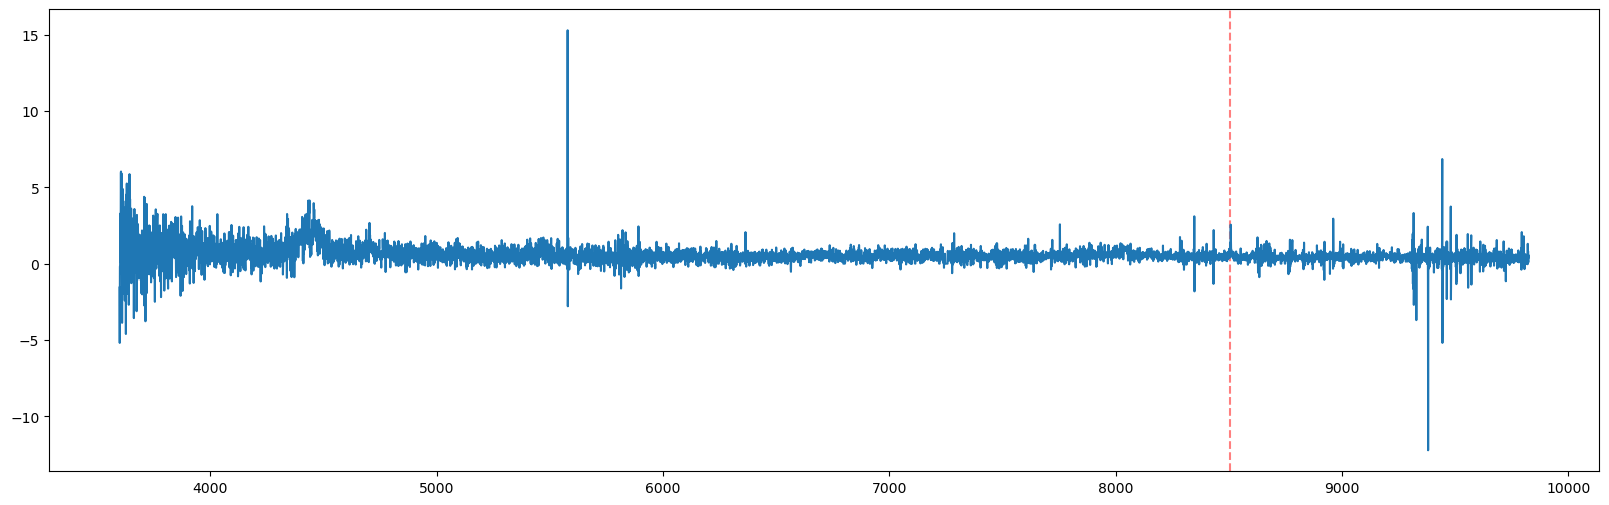


Example data:
TARGETID: 39627827787601524
Redshift: 1.5936716630517584
Fluxes: [-1.88774979  0.94104159 -2.2474041  ...  0.30285838  0.27283418
 -0.23586747]
ivar [ 0.18836592  0.19006206  0.17613922 ... 13.56796265 22.51046181
 38.91328812]
Labels: 1
LAE Redshift: 4.253659861870378
LAE NAME SPHINX_z4_haloid114152_dir_2
LAE intflux 1.6173921513669074



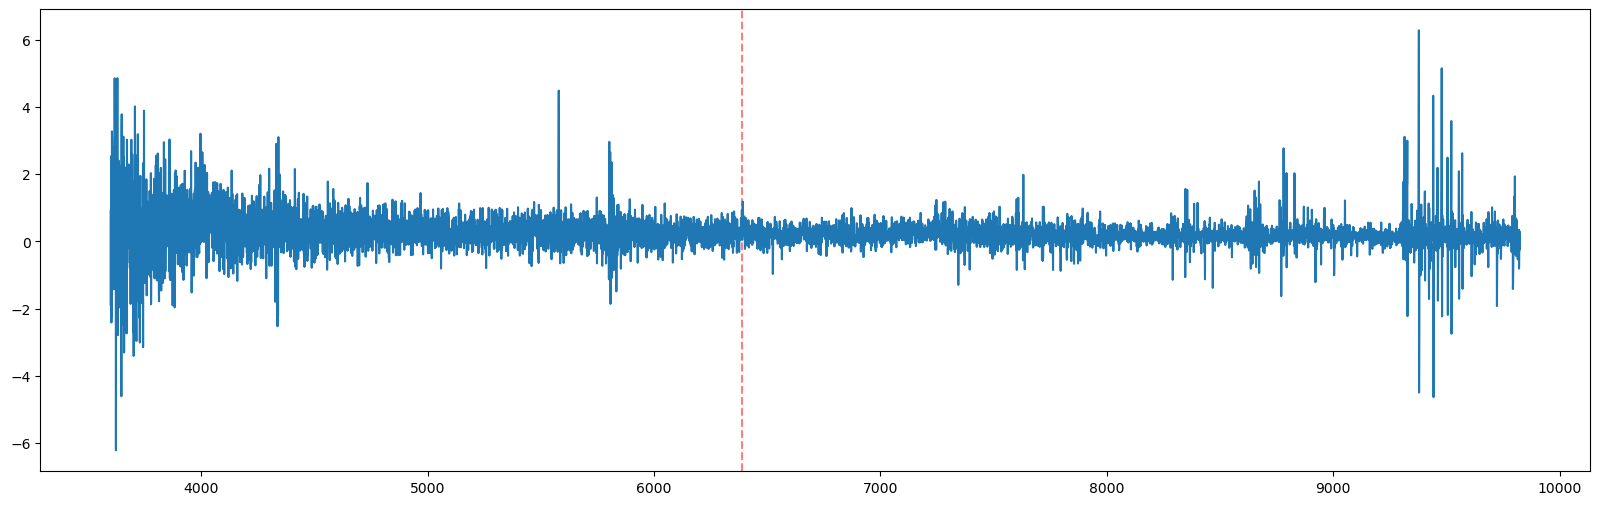


Example data:
TARGETID: 39627827791790364
Redshift: 0.798422966798326
Fluxes: [ 0.81221151 -1.35572398 -0.10393386 ...  0.27264792  0.67706388
  0.07725963]
ivar [ 0.22061501  0.21207231  0.19413117 ... 13.23808098 18.41108322
 27.54963875]
Labels: 1
LAE Redshift: 4.064971313736678
LAE NAME ZoomSim_timestep119_direction33
LAE intflux 1.2269734824332261



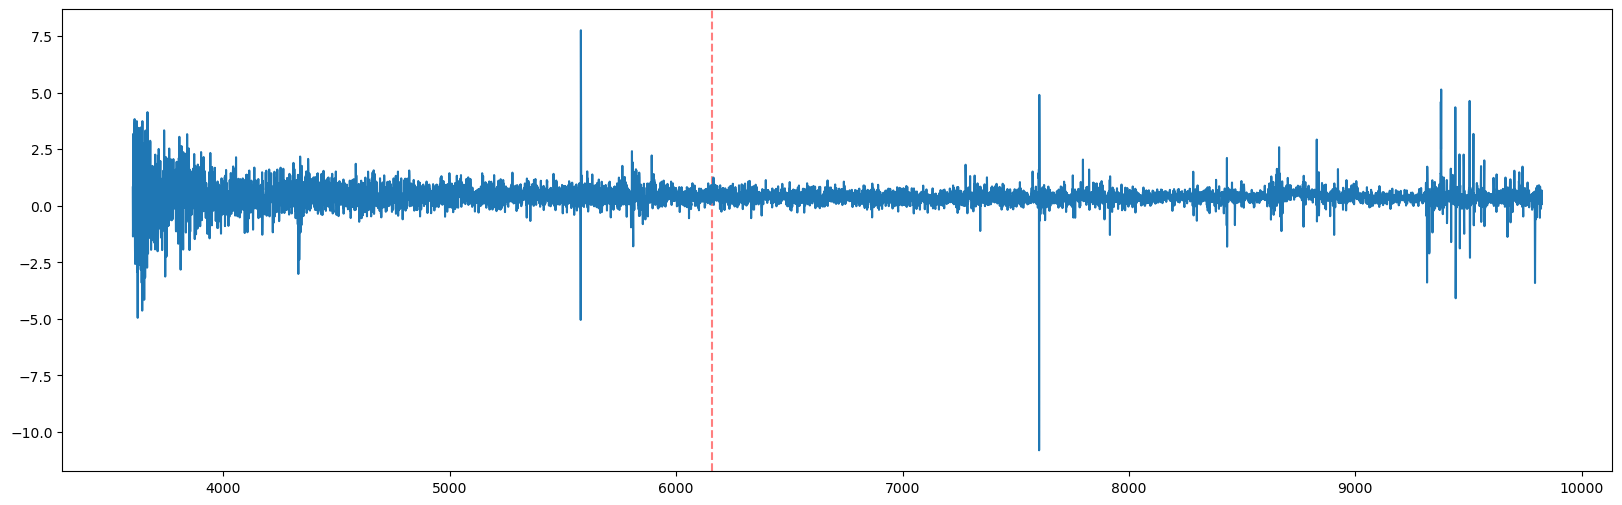


Example data:
TARGETID: 39627827791791325
Redshift: 2.50497779915149
Fluxes: [ 9.21767139 10.16653442 11.69007397 ...  2.57708573  3.34206748
  2.91852641]
ivar [ 0.39042735  0.34689331  0.30597621 ... 19.3487854  20.45334053
 20.15045738]
Labels: 1
LAE Redshift: 5.296517051082821
LAE NAME SPHINX_z6_haloid360858_dir_0
LAE intflux 1.0415514375811192



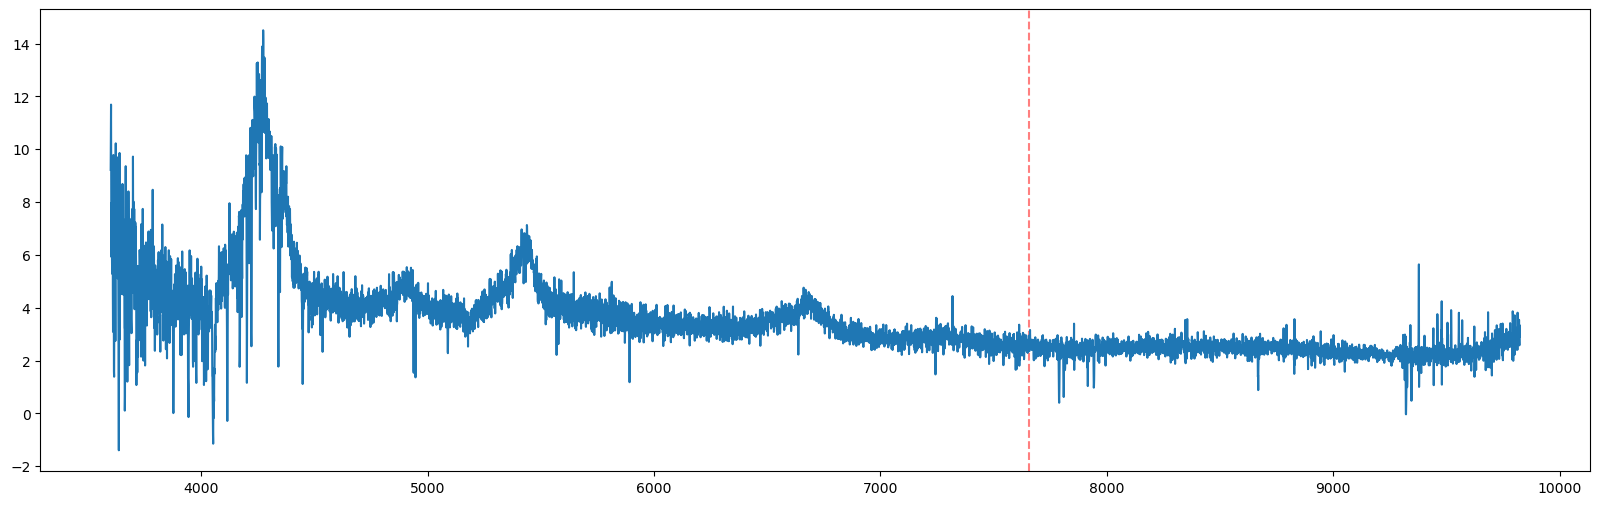


Example data:
TARGETID: 39627827791793267
Redshift: 2.0268412072209023
Fluxes: [4.70586586 7.6268034  7.75396585 ... 1.33478904 1.23513889 0.70765412]
ivar [ 0.2172834   0.1827355   0.14607355 ... 12.47567558 17.00181389
 22.53902626]
Labels: 1
LAE Redshift: 4.982516084955166
LAE NAME SPHINX_z5_haloid256926_dir_1
LAE intflux 2.9514516221413816



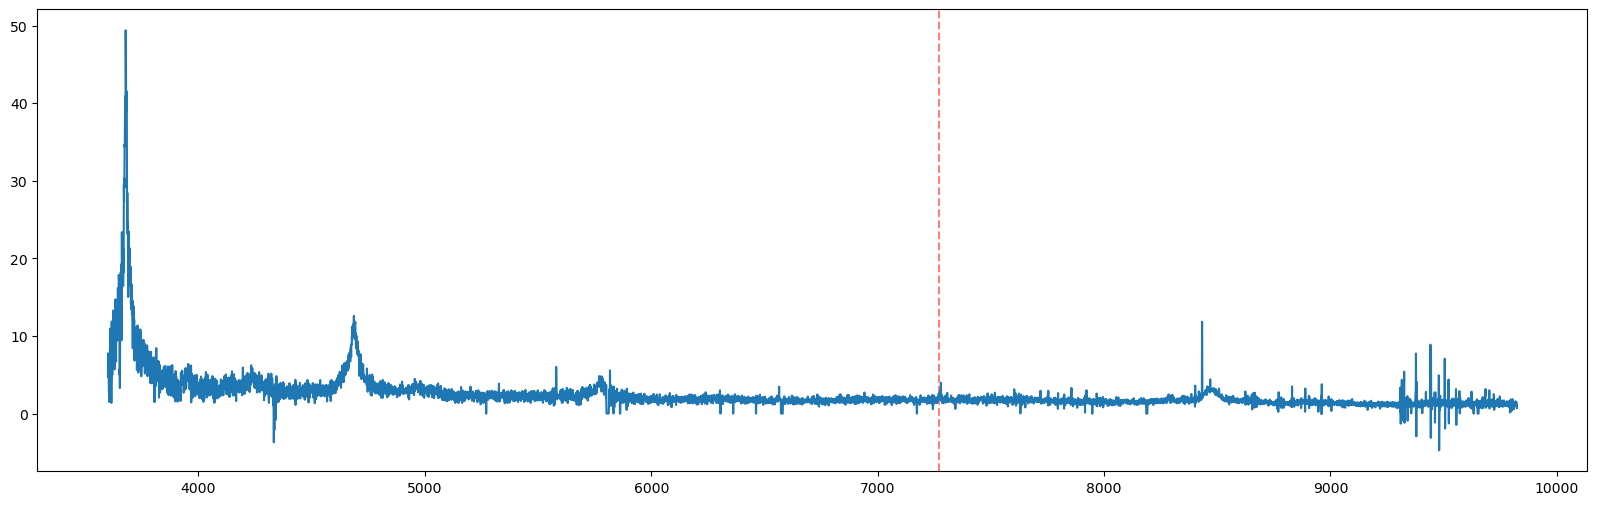


Example data:
TARGETID: 39627833760291300
Redshift: 0.7502650230386144
Fluxes: [ 2.58769846 -0.66884679  0.06495681 ...  0.72107708  0.70974112
  0.85084414]
ivar [ 0.09781986  0.10811177  0.1287712  ... 11.23384953 15.82614803
 21.5400219 ]
Labels: 1
LAE Redshift: 3.229981655317918
LAE NAME ZoomSim_timestep119_direction8
LAE intflux 1.5245993831666491



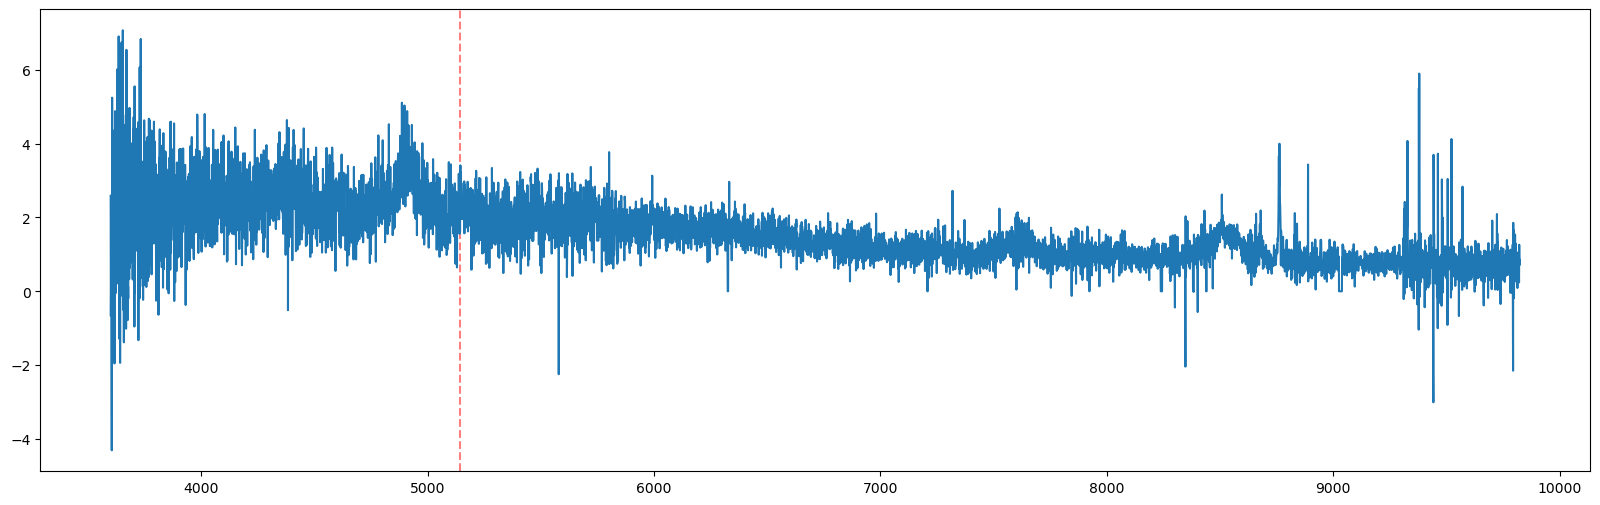


Example data:
TARGETID: 39627833768677677
Redshift: 2.931378135680008
Fluxes: [6.93603373 5.29730415 1.09173512 ... 0.41283941 1.63137364 0.62916207]
ivar [ 0.06185141  0.05583709  0.06296471 ... 11.87494469 13.73471832
 19.25189781]
Labels: 1
LAE Redshift: 5.878013111918913
LAE NAME SPHINX_z4_haloid114152_dir_4
LAE intflux 1.2911170935184646



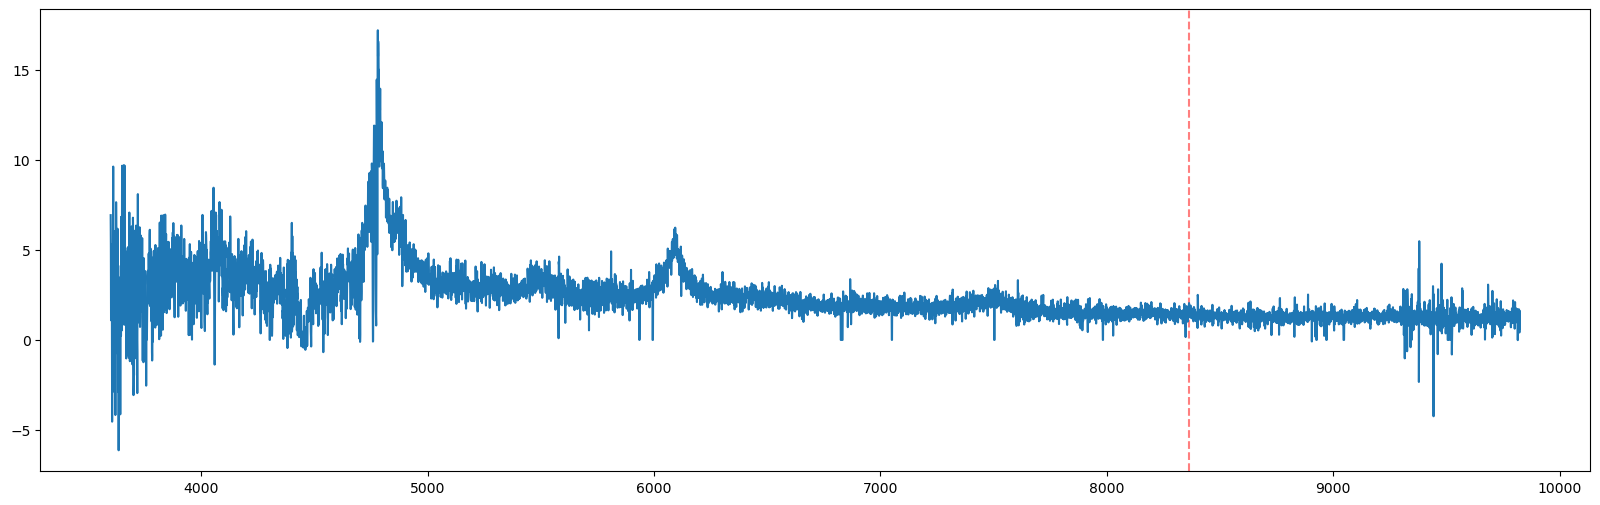


Example data:
TARGETID: 39627833777065848
Redshift: 2.287061349319659
Fluxes: [ 1.35658348  5.1539588  -1.06503427 ...  0.62356997  0.40297604
  0.2661089 ]
ivar [ 0.13713752  0.08635595  0.11658585 ... 11.45076561 15.57606506
 17.44376564]
Labels: 1
LAE Redshift: 2.5953634159675247
LAE NAME ZoomSim_timestep92_direction69
LAE intflux 1.4740573442066338



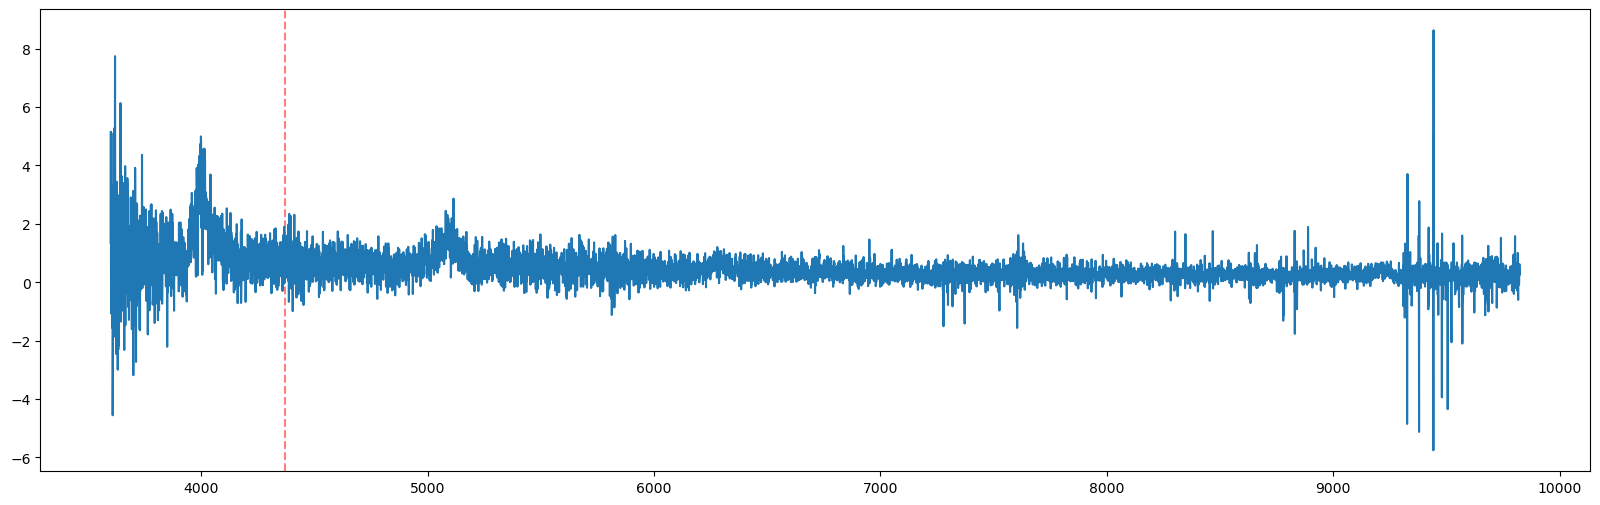


Example data:
TARGETID: 39627833781261293
Redshift: 2.450549753663198
Fluxes: [4.85362911 1.49089813 0.60834152 ... 1.28061831 1.27530313 1.26883113]
ivar [ 0.27864134  0.19801152  0.28080955 ... 24.0695858  31.0217514
 34.71558762]
Labels: 1
LAE Redshift: 4.930984785694091
LAE NAME SPHINX_z4_haloid47341_dir_0
LAE intflux 2.721639485165759



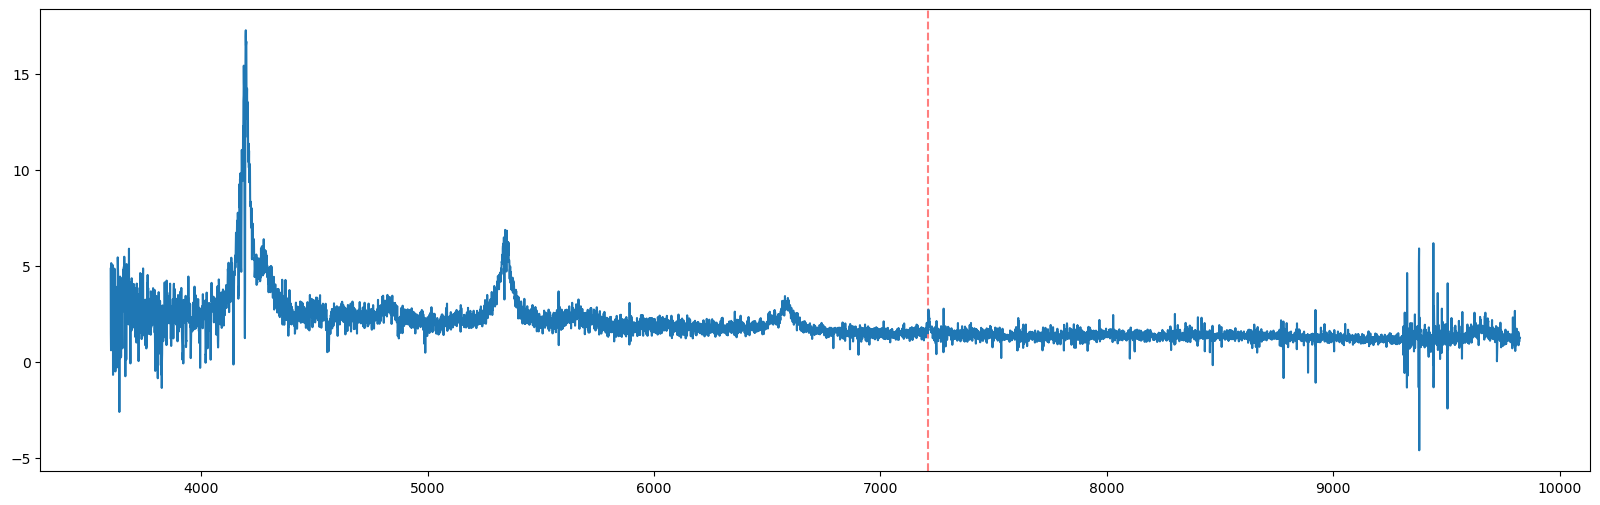


Example data:
TARGETID: 39627833785450871
Redshift: 1.6303436803793527
Fluxes: [1.9140687  6.45667505 2.59617567 ... 0.45040157 0.13944866 0.72283185]
ivar [ 0.46501863  0.39766783  0.47564784 ... 28.14217186 38.75714874
 51.37727737]
Labels: 1
LAE Redshift: 4.695203305694099
LAE NAME SPHINX_z4_haloid116611_dir_6
LAE intflux 2.6108395304088643



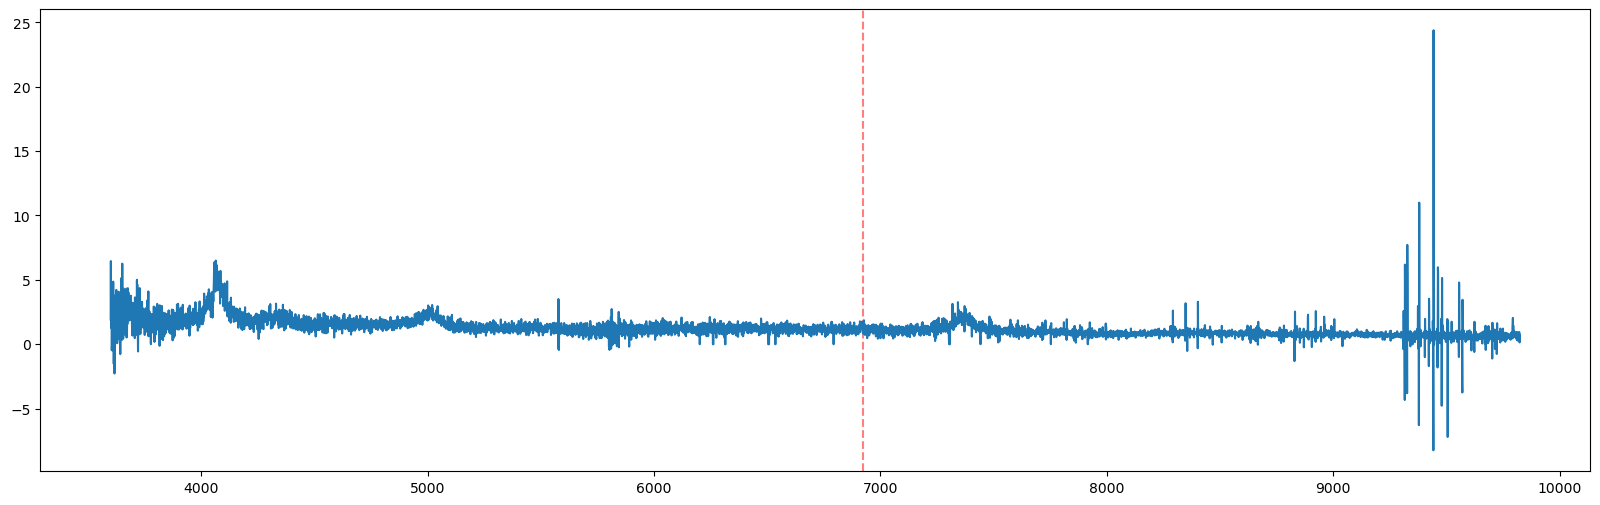


Example data:
TARGETID: 39627833785454416
Redshift: 1.517385738205137
Fluxes: [-0.82640254 -5.70340824 -5.52903891 ...  0.49781552  0.11422397
  0.08903682]
ivar [ 0.07913251  0.05598288  0.08485445 ... 10.62128735 14.62287045
 19.48445511]
Labels: 1
LAE Redshift: 4.649993060779001
LAE NAME SPHINX_z5_haloid30899_dir_5
LAE intflux 1.0154490677323498



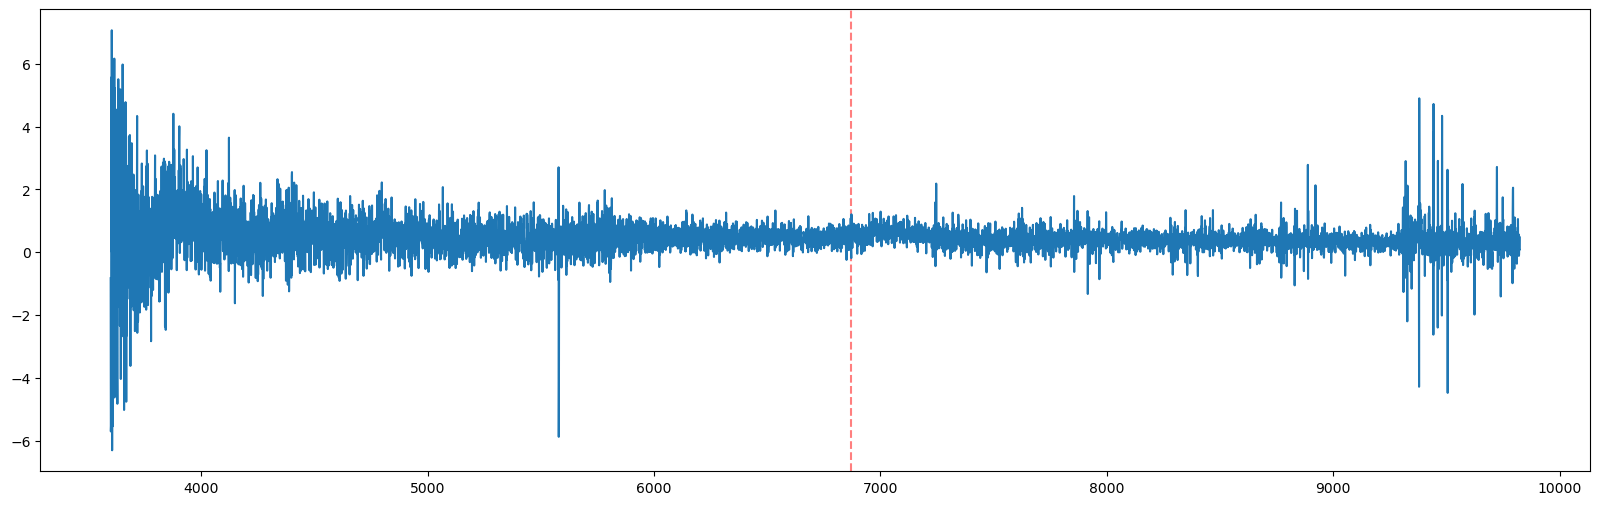


Example data:
TARGETID: 39627833789647154
Redshift: 2.3789338181360464
Fluxes: [-11.27576542   1.8639605    0.54548901 ...   0.05116443   0.3061358
   0.42053905]
ivar [4.62538004e-02 4.19169925e-02 6.18522093e-02 ... 3.25760345e+01
 5.16953850e+01 5.95712776e+01]
Labels: 1
LAE Redshift: 3.449195601932379
LAE NAME ZoomSim_timestep145_direction271
LAE intflux 1.1918930900317364



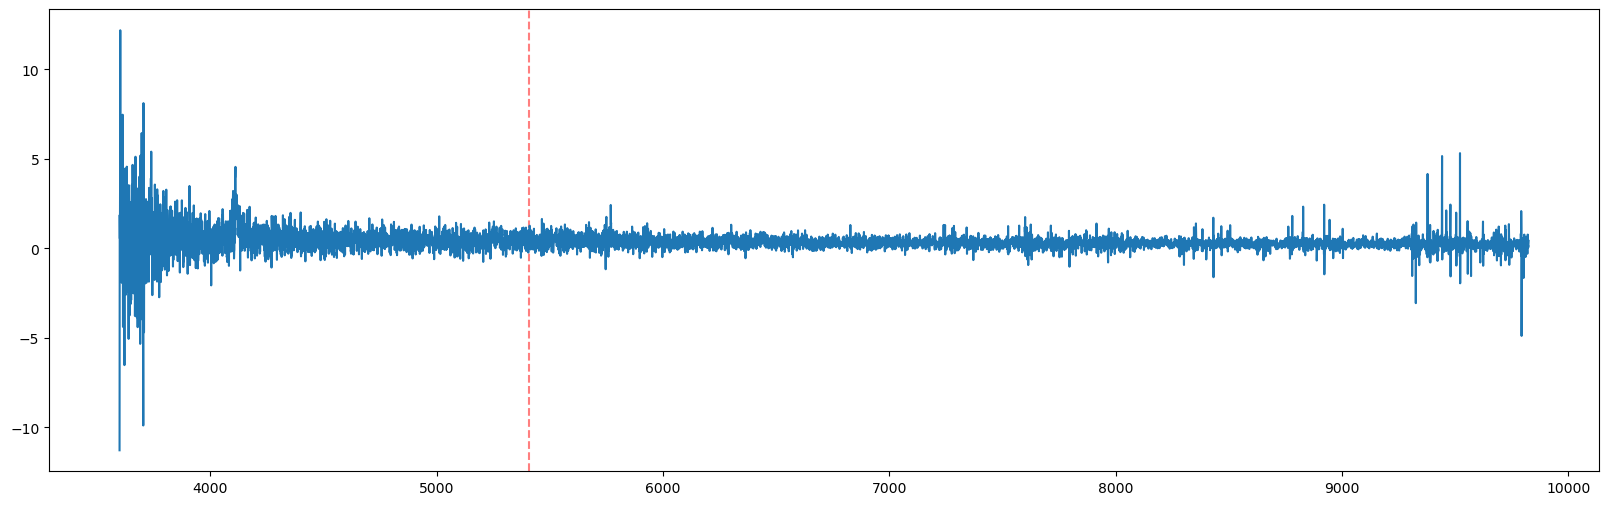


Example data:
TARGETID: 39627833798034724
Redshift: 1.055095380551107
Fluxes: [1.04650557 1.9338758  0.97229606 ... 0.54239434 0.55669785 0.85760576]
ivar [ 0.27562574  0.26259699  0.23065564 ... 18.06231499 25.98752403
 26.40591049]
Labels: 1
LAE Redshift: 3.2578394096664876
LAE NAME ZoomSim_timestep115_direction110
LAE intflux 1.6152853949220962



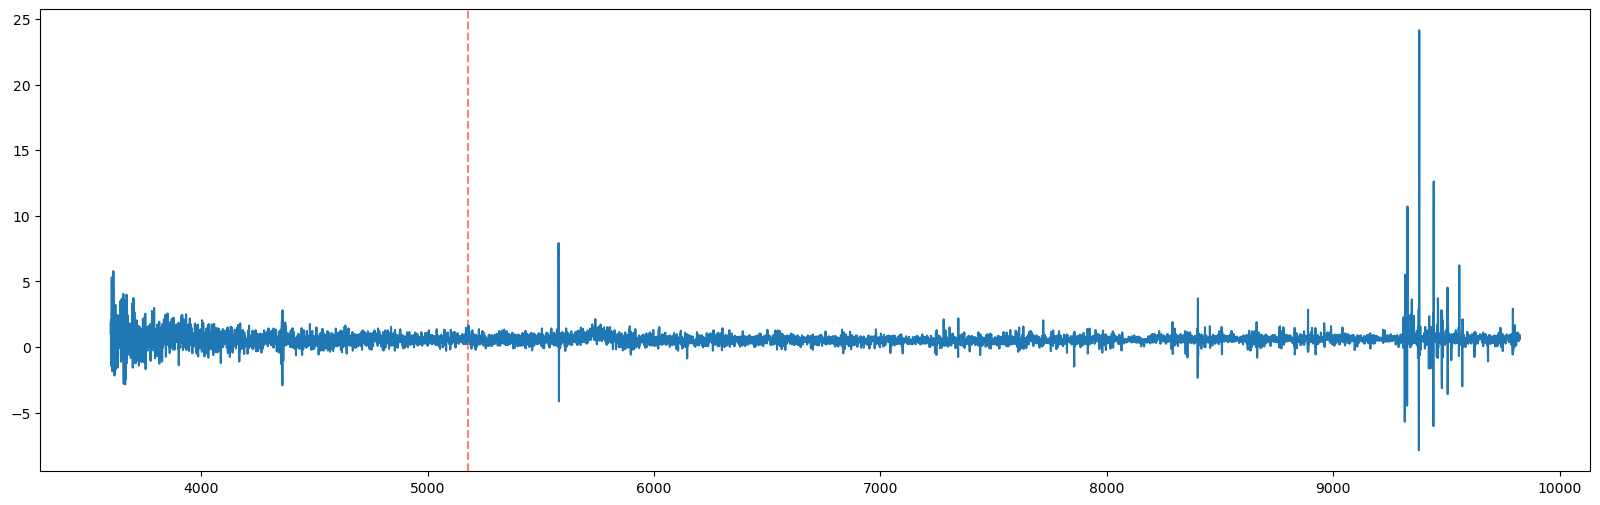


Example data:
TARGETID: 39627833798035169
Redshift: 1.133213237063484
Fluxes: [4.1866951  4.218009   6.08648968 ... 0.53911036 0.33703238 0.5013923 ]
ivar [ 0.23846948  0.26379099  0.21607345 ... 18.77832985 24.902565
 26.31848907]
Labels: 1
LAE Redshift: 2.474819740467984
LAE NAME ZoomSim_timestep113_direction94
LAE intflux 1.7211009387095546



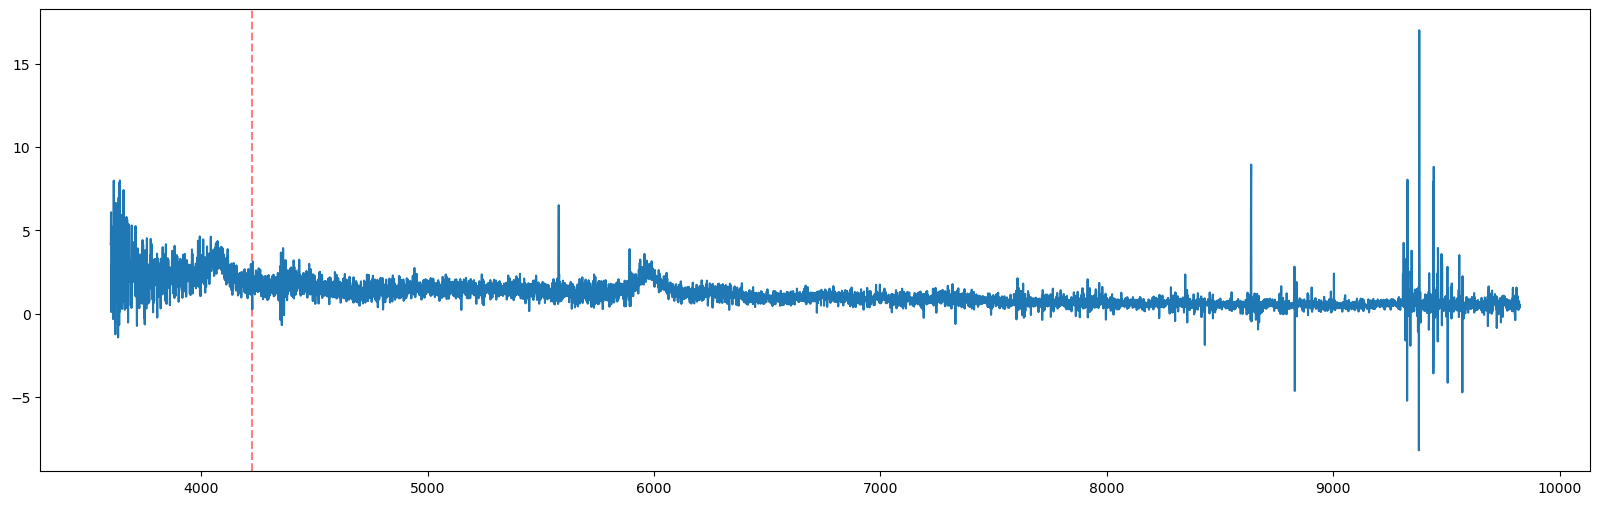

In [57]:
N=100
i=0
n=0

min_wave, max_wave = 1200, 1230
while n<N:
    if labels[i]==1:
        n+=1
        print("\nExample data:")
        print("TARGETID:", target_ids[i])
        print("Redshift:", redshifts[i])
        print("Fluxes:", fluxes[i])
        print("ivar", ivar[i])
        print("Labels:", labels[i])
        print("LAE Redshift:", elg_redshift[i])
        print("LAE NAME", ename[i])
        print("LAE intflux", lae_intflux[i])
        print()

        plt.figure(figsize = (20,6))
        r = 1215.67 * (1 + elg_redshift[i])
        plt.axvline(r, color = 'red', linestyle = '--', alpha=0.5)
        pixels = np.linspace(3600, 9824, 7781)
        plt.plot(pixels, fluxes[i])
        #plt.xlim(min_wave*(1+elg_redshift[i]), max_wave*(1+elg_redshift[i]))
        plt.show()
    i+=1

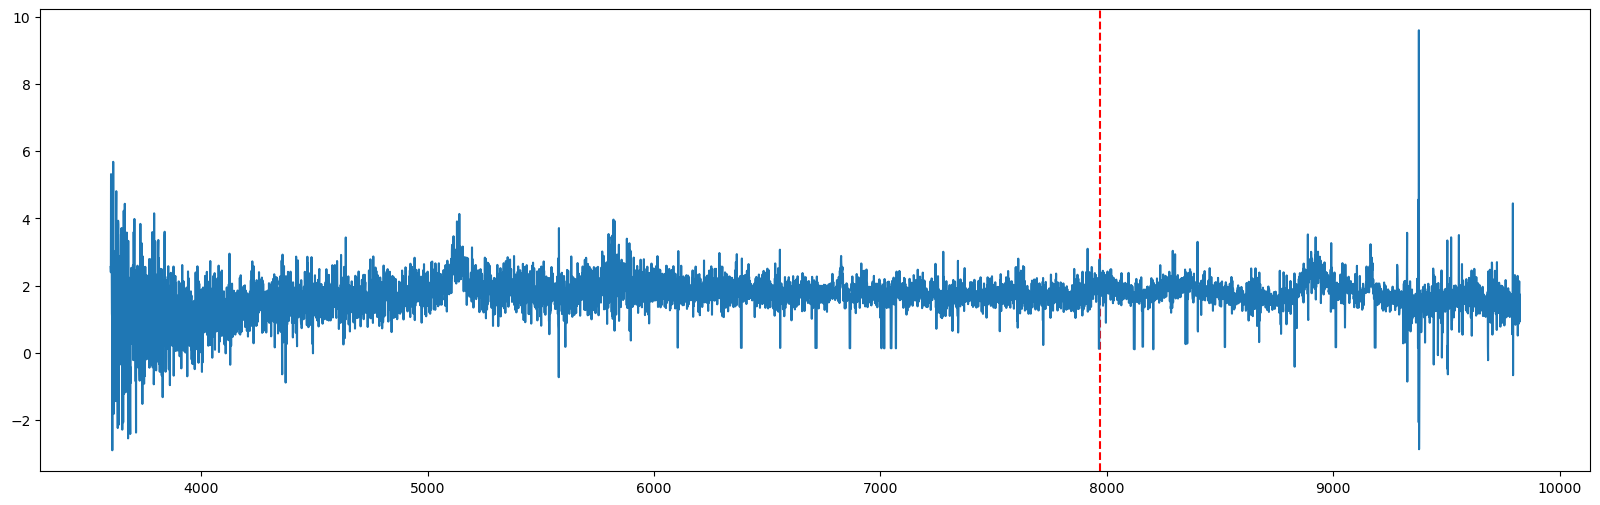

In [13]:
import matplotlib.pyplot as plt
Flux = fluxes[i]
plt.figure(figsize = (20,6))
r = 1215.67 * (1 + elg_redshift[i])
plt.axvline(r, color = 'red', linestyle = '--', alpha=0.5)

wavelength_min = 3600  # in AA
wavelength_max = 9824.  # in AA

# Create an array of 7781 linearly spaced values within this range
pixels = np.linspace(wavelength_min, wavelength_max, 7781)



plt.plot(pixels, fluxes[i])
#plt.plot(pixels, 1/np.sqrt(ivar[i]))


In [14]:
r

7968.888119499714